In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

In [3]:
# Load data
train_data = pd.read_csv('/Users/deekshithlabba/Documents/100 days of ML/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/deekshithlabba/Documents/100 days of ML/6644a1e287df6_test_data_with_samplefeatures.csv')

In [4]:
# Feature Engineering
train_data['winner_01'] = np.where(train_data['team2'] == train_data['winner'], 1, 0)
train_data['toss_winner_01'] = np.where(train_data['toss winner'] == train_data['team2'], 1, 0)
test_data['toss_winner_01'] = np.where(test_data['toss winner'] == test_data['team2'], 1, 0)
train_data['toss_decision_01'] = np.where(train_data['toss decision'] == 'bat', 1, 0)
test_data['toss_decision_01'] = np.where(test_data['toss decision'] == 'bat', 1, 0)

In [5]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       'toss decision', 'venue', 'city', 'match_dt', 'lighting', 'series_name',
       'season', 'ground_id', 'team_count_50runs_last15', 'team_winp_last5',
       'team1only_avg_runs_last15', 'team1_winp_team2_last15',
       'ground_avg_runs_last15', 'winner_01', 'toss_winner_01',
       'toss_decision_01'],
      dtype='object')

In [6]:
additional_data_bowler=pd.read_csv('/Users/deekshithlabba/Documents/100 days of ML/663e2b2c60743_bowler_level_scorecard.csv')

In [7]:
additional_data_batsman=pd.read_csv('/Users/deekshithlabba/Documents/100 days of ML/663e2b548c98c_batsman_level_scorecard.csv')

In [8]:
additional_data_match=pd.read_csv('/Users/deekshithlabba/Documents/100 days of ML/664389efa0868_match_level_scorecard.csv')

In [9]:
additional_data_batsman.duplicated().sum()

0

In [10]:
# Check for duplicates in additional_data_match
duplicates = additional_data_match.duplicated(subset=['match_dt', 'team1', 'team2'], keep=False)
duplicate_entries = additional_data_match[duplicates]
print(duplicate_entries)
# Remove duplicates by keeping the first occurrence
additional_data_match = additional_data_match.drop_duplicates(subset=['match_dt', 'team1', 'team2'], keep='first')


      match id team1 team2 winner       by  win amount toss winner  \
1091   9433864    Ne    Le     Ne     runs         4.0          Ne   
1607   9433829    Ne    Le     Le  wickets         6.0          Le   

     toss decision     venue        city  ... inning2_runs inning2_wickets  \
1091           bat  Tt Be Nm  Nottingham  ...        164.0             8.0   
1607         field  Od Td Mr  Manchester  ...        139.0             4.0   

     inning2_balls team1_id  \
1091         121.0     8987   
1607         106.0     8917   

                                       team1_roster_ids team2_id  \
1091  4003390.0:1749075.0:7328110.0:4172447.0:442521...     8301   
1607  4873700.0:8040164.0:2286472.0:2157770.0:464530...     8182   

                                       team2_roster_ids     series_type  \
1091  2340372.0:4887336.0:6003584.0:2658431.0:321829...  other_domestic   
1607  4685568.0:2162782.0:82228.0:2827327.0:2672214....  other_domestic   

      winner_id  player_of_th

In [11]:
# Ensure all data is sorted by date
train_data = train_data.sort_values(by='match_dt')
test_data = test_data.sort_values(by='match_dt')
additional_data_bowler = additional_data_bowler.sort_values(by='match_dt')
additional_data_batsman = additional_data_batsman.sort_values(by='match_dt')
additional_data_match = additional_data_match.sort_values(by='match_dt')

In [12]:
train_data.head()


match id  team1  team1_id  \
616   8887675  Be Ht     33921   
298   8887689  Ph Ss     33935   
902   8887703  Me Ss     33949   
476   8887717  Ht Hs     33928   
604   8887731  Be Ht     33921   

                                      team1_roster_ids  team2  team2_id  \
616  2286472.0:3114803.0:3651472.0:5786766.0:762026...  Ht Hs     33928   
298  3507090.0:3535783.0:1626526.0:1798705.0:350188...  Me Ss     33949   
902  2340519.0:7880018.0:4393374.0:2275195.0:390107...  Me Rs     33942   
476  4223883.0:1611364.0:2161599.0:2340372.0:584320...  Ae Ss     33914   
604  3062149.0:8415665.0:3585350.0:5786766.0:153920...  Me Rs     33942   

                                      team2_roster_ids winner  winner_id  \
616  1611364.0:4223883.0:2161599.0:6381962.0:234037...  Be Ht      33921   
298  4003390.0:7960994.0:2275195.0:4393374.0:390107...  Ph Ss      33935   
902  5406540.0:37351.0:46794.0:2336473.0:7534687.0:...  Me Rs      33942   
476  4239038.0:5492318.0:5056134.0:1635773.0:546900...  Ae Ss      33914   
604  5406540.0:37351.0:46794.0:2336473.0:7537067.0:...  Me Rs      33942   

    toss winner  ...   season ground_id team_count_50runs_last15  \
616       Ht Hs  ...  2021/22      6348                 0.583333   
298       Ph Ss  ...  2021/22      2932                 1.222222   
902       Me Ss  ...  2021/22       440                 0.400000   
476       Ae Ss  ...  2021/22       930                 1.000000   
604       Me Rs  ...  2021/22      3961                 0.363636   

    team_winp_last5 team1only_avg_runs_last15 team1_winp_team2_last15  \
616        0.672131                166.933333                     0.0   
298        1.327869                178.733333                   100.0   
902       41.000000                171.066667                    50.0   
476       61.000000                173.333333                   100.0   
604        1.952381                167.000000                   100.0   

    ground_avg_runs_last15  winner_01  toss_winner_01  toss_decision_01  
616             162.333333          0               1                 0  
298                    NaN          0               0                 1  
902             162.687500          1               0                 1  
476             161.045455          1               1                 0  
604                    NaN          1               1                 0  

[5 rows x 26 columns]

In [13]:
test_data.shape

(271, 23)

In [14]:
train_data.isnull().sum()

match id                      0
team1                         0
team1_id                      0
team1_roster_ids              0
team2                         0
team2_id                      0
team2_roster_ids              0
winner                        0
winner_id                     0
toss winner                   0
toss decision                 0
venue                         0
city                          0
match_dt                      0
lighting                      0
series_name                   0
season                        0
ground_id                     0
team_count_50runs_last15      0
team_winp_last5               0
team1only_avg_runs_last15    21
team1_winp_team2_last15       0
ground_avg_runs_last15       53
winner_01                     0
toss_winner_01                0
toss_decision_01              0
dtype: int64

In [15]:
additional_data_bowler.head()

match id bowler  bowler_id                             bowler_details  \
0    8638034  BV Ss  6718396.0   NZ:Right-hand bat:Right-arm medium-fast:   
23   8588005   W Sd  7537067.0  AUS:Right-hand bat:Right-arm medium-fast:   
22   8588005   P Hu  8339701.0        AUS:Right-hand bat:Legbreak googly:   
21   8588005  Md Ni   181404.0     AFG:Right-hand bat:Right-arm offbreak:   
19   8588005  KW Rn  1905847.0  AUS:Right-hand bat:Right-arm fast-medium:   

    is_bowler_captain  is_bowler_keeper  inning  runs  wicket_count  \
0                 0.0               0.0       1    21             0   
23                0.0               0.0       2     5             0   
22                0.0               0.0       2    20             0   
21                0.0               0.0       2    10             0   
19                0.0               0.0       2    14             0   

    balls_bowled  economy  maiden  dots  Fours  Sixes  wides  noballs  \
0             12    10.50       0   3.0      1      1      3        1   
23             6     5.00       0   4.0      1      0      0        0   
22            18     6.67       0   4.0      1      0      1        0   
21             6    10.00       0   0.0      1      0      0        0   
19            12     7.00       0   4.0      2      0      0        0   

      match_dt  
0   2021-01-01  
23  2021-01-01  
22  2021-01-01  
21  2021-01-01  
19  2021-01-01

In [16]:
additional_data_batsman.columns

Index(['match id', 'batsman', 'batsman_id', 'batsman_details',
       'is_batsman_captain', 'is_batsman_keeper', 'inning', 'runs',
       'balls_faced', 'over_faced_first', 'wicket kind', 'out_by_bowler',
       'out_by_fielder', 'bowler_id', 'bowler_details', 'is_bowler_keeper',
       'is_bowler_captain', 'strike_rate', 'Fours', 'Sixes', 'match_dt'],
      dtype='object')

In [17]:
additional_data_bowler.columns

Index(['match id', 'bowler', 'bowler_id', 'bowler_details',
       'is_bowler_captain', 'is_bowler_keeper', 'inning', 'runs',
       'wicket_count', 'balls_bowled', 'economy', 'maiden', 'dots', 'Fours',
       'Sixes', 'wides', 'noballs', 'match_dt'],
      dtype='object')

In [18]:
# Convert 'match_dt' columns to datetime format in both DataFrames
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Helper function to calculate player mean runs up to a given date
def calculate_past_player_mean_runs(match_dt):
    past_matches = additional_data_batsman[additional_data_batsman['match_dt'] < match_dt]
    return past_matches.groupby('batsman_id')['runs'].mean().reset_index()

# Function to calculate team mean runs based on past matches up to the current match date
def calculate_team_mean_runs(roster_ids, player_mean_runs):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_runs = player_mean_runs[player_mean_runs['batsman_id'].isin(player_ids)]['runs']
    return mean_runs.mean() if not mean_runs.empty else 0

# Calculate team1 and team2 mean runs based on past matches
def calculate_team_mean_runs_for_past_matches(row):
    player_mean_runs_up_to_date = calculate_past_player_mean_runs(row['match_dt'])
    team1_mean_runs = calculate_team_mean_runs(row['team1_roster_ids'], player_mean_runs_up_to_date)
    team2_mean_runs = calculate_team_mean_runs(row['team2_roster_ids'], player_mean_runs_up_to_date)
    return team1_mean_runs, team2_mean_runs

# Apply the function to each row in train_data
mean_runs_results = train_data.apply(lambda row: calculate_team_mean_runs_for_past_matches(row), axis=1)
train_data['team1_mean_runs'] = mean_runs_results.apply(lambda x: x[0])
train_data['team2_mean_runs'] = mean_runs_results.apply(lambda x: x[1])

# Calculate the ratio of team1 mean runs to team2 mean runs
train_data['team1_by_2_runs'] = train_data['team1_mean_runs'] / train_data['team2_mean_runs']

# Handle cases where division by zero might occur
train_data['team1_by_2_runs'] = train_data['team1_by_2_runs'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new feature
print(train_data[['team1', 'team2', 'match_dt', 'team1_mean_runs', 'team2_mean_runs', 'team1_by_2_runs']].head())


     team1  team2   match_dt  team1_mean_runs  team2_mean_runs  \
616  Be Ht  Ht Hs 2022-01-01        14.447394        18.013604   
298  Ph Ss  Me Ss 2022-01-02        16.352617        15.748791   
902  Me Ss  Me Rs 2022-01-03        11.103505        15.665799   
476  Ht Hs  Ae Ss 2022-01-05        17.687494        16.863379   
604  Be Ht  Me Rs 2022-01-06        16.937879        14.552530   

     team1_by_2_runs  
616         0.802027  
298         1.038341  
902         0.708774  
476         1.048870  
604         1.163913  


In [19]:
# Convert 'match_dt' columns to datetime format in both DataFrames
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Helper function to calculate player mean runs up to a given date
def calculate_past_player_mean_runs(match_dt):
    past_matches = additional_data_batsman[additional_data_batsman['match_dt'] < match_dt]
    return past_matches.groupby('batsman_id')['runs'].mean().reset_index()

# Function to calculate team mean runs based on past matches up to the current match date
def calculate_team_mean_runs(roster_ids, player_mean_runs):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_runs = player_mean_runs[player_mean_runs['batsman_id'].isin(player_ids)]['runs']
    return mean_runs.mean() if not mean_runs.empty else 0

# Calculate team1 and team2 mean runs based on past matches
def calculate_team_mean_runs_for_past_matches(row):
    player_mean_runs_up_to_date = calculate_past_player_mean_runs(row['match_dt'])
    team1_mean_runs = calculate_team_mean_runs(row['team1_roster_ids'], player_mean_runs_up_to_date)
    team2_mean_runs = calculate_team_mean_runs(row['team2_roster_ids'], player_mean_runs_up_to_date)
    return team1_mean_runs, team2_mean_runs

# Apply the function to each row in test_data
mean_runs_results = test_data.apply(lambda row: calculate_team_mean_runs_for_past_matches(row), axis=1)
test_data['team1_mean_runs'] = mean_runs_results.apply(lambda x: x[0])
test_data['team2_mean_runs'] = mean_runs_results.apply(lambda x: x[1])

# Calculate the ratio of team1 mean runs to team2 mean runs
test_data['team1_by_2_runs'] = test_data['team1_mean_runs'] / test_data['team2_mean_runs']

# Handle cases where division by zero might occur
test_data['team1_by_2_runs'] = test_data['team1_by_2_runs'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new feature
print(test_data[['team1', 'team2', 'match_dt', 'team1_mean_runs', 'team2_mean_runs', 'team1_by_2_runs']].head())


     team1  team2   match_dt  team1_mean_runs  team2_mean_runs  \
269  Sy Tr  Me Rs 2022-01-08        17.472551        13.949386   
80   Ht Hs  Sy Tr 2022-01-10        18.452582        17.472551   
251  Ae Ss  Be Ht 2022-01-12        14.472032        19.658171   
48   Ht Hs  Sy Tr 2022-01-13        18.130839        17.472551   
155  Ae Ss  Me Ss 2022-01-15        16.786910        13.902327   

     team1_by_2_runs  
269         1.252568  
80          1.056090  
251         0.736184  
48          1.037676  
155         1.207489  


In [20]:
# Convert 'match_dt' columns to datetime format in both DataFrames
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Helper function to calculate player mean runs for the last 5 matches up to a given date, inning-wise
def calculate_past_player_mean_runs(match_dt, inning):
    past_matches = additional_data_batsman[(additional_data_batsman['match_dt'] < match_dt) &
                                           (additional_data_batsman['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('batsman_id').head(15)
    return past_matches.groupby('batsman_id')['runs'].mean().reset_index()

# Function to calculate team mean runs based on past matches up to the current match date, inning-wise
def calculate_team_mean_runs(roster_ids, player_mean_runs):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_runs = player_mean_runs[player_mean_runs['batsman_id'].isin(player_ids)]['runs']
    return mean_runs.mean() if not mean_runs.empty else 0

# Calculate team1 and team2 mean runs based on past matches, inning-wise
def calculate_team_mean_runs_for_past_matches(row, inning):
    player_mean_runs_up_to_date = calculate_past_player_mean_runs(row['match_dt'], inning)
    team1_mean_runs = calculate_team_mean_runs(row['team1_roster_ids'], player_mean_runs_up_to_date)
    team2_mean_runs = calculate_team_mean_runs(row['team2_roster_ids'], player_mean_runs_up_to_date)
    return team1_mean_runs, team2_mean_runs

# Apply the function to each row in train_data for both innings
mean_runs_results_inning1 = train_data.apply(lambda row: calculate_team_mean_runs_for_past_matches(row, 1), axis=1)
train_data['team1_mean_runs_inning1'] = mean_runs_results_inning1.apply(lambda x: x[0])
train_data['team2_mean_runs_inning1'] = mean_runs_results_inning1.apply(lambda x: x[1])

mean_runs_results_inning2 = train_data.apply(lambda row: calculate_team_mean_runs_for_past_matches(row, 2), axis=1)
train_data['team1_mean_runs_inning2'] = mean_runs_results_inning2.apply(lambda x: x[0])
train_data['team2_mean_runs_inning2'] = mean_runs_results_inning2.apply(lambda x: x[1])

# Calculate the ratio of team1 mean runs to team2 mean runs for each inning
train_data['team1_by_2_runs_inning1'] = train_data['team1_mean_runs_inning1'] / train_data['team2_mean_runs_inning1']
train_data['team1_by_2_runs_inning2'] = train_data['team1_mean_runs_inning2'] / train_data['team2_mean_runs_inning2']

# Handle cases where division by zero might occur
train_data['team1_by_2_runs_inning1'] = train_data['team1_by_2_runs_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_runs_inning2'] = train_data['team1_by_2_runs_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'team1_mean_runs_inning1', 'team2_mean_runs_inning1', 'team1_by_2_runs_inning1', 'team1_mean_runs_inning2', 'team2_mean_runs_inning2', 'team1_by_2_runs_inning2']].head())


     team1  team2   match_dt  team1_mean_runs_inning1  \
616  Be Ht  Ht Hs 2022-01-01                13.926840   
298  Ph Ss  Me Ss 2022-01-02                16.507033   
902  Me Ss  Me Rs 2022-01-03                24.220370   
476  Ht Hs  Ae Ss 2022-01-05                27.841558   
604  Be Ht  Me Rs 2022-01-06                14.254167   

     team2_mean_runs_inning1  team1_by_2_runs_inning1  \
616                25.228030                 0.552038   
298                26.710732                 0.617993   
902                17.857517                 1.356312   
476                19.307292                 1.442023   
604                19.326602                 0.737541   

     team1_mean_runs_inning2  team2_mean_runs_inning2  team1_by_2_runs_inning2  
616                14.130952                15.662737                 0.902202  
298                13.662121                13.036395                 1.047998  
902                 9.554630                14.000694                 0

In [21]:
# Convert 'match_dt' columns to datetime format in both DataFrames
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Helper function to calculate player mean runs for the last 5 matches up to a given date, inning-wise
def calculate_past_player_mean_runs(match_dt, inning):
    past_matches = additional_data_batsman[(additional_data_batsman['match_dt'] < match_dt) &
                                           (additional_data_batsman['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('batsman_id').head(15)
    return past_matches.groupby('batsman_id')['runs'].mean().reset_index()

# Function to calculate team mean runs based on past matches up to the current match date, inning-wise
def calculate_team_mean_runs(roster_ids, player_mean_runs):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_runs = player_mean_runs[player_mean_runs['batsman_id'].isin(player_ids)]['runs']
    return mean_runs.mean() if not mean_runs.empty else 0

# Calculate team1 and team2 mean runs based on past matches, inning-wise
def calculate_team_mean_runs_for_past_matches(row, inning):
    player_mean_runs_up_to_date = calculate_past_player_mean_runs(row['match_dt'], inning)
    team1_mean_runs = calculate_team_mean_runs(row['team1_roster_ids'], player_mean_runs_up_to_date)
    team2_mean_runs = calculate_team_mean_runs(row['team2_roster_ids'], player_mean_runs_up_to_date)
    return team1_mean_runs, team2_mean_runs

# Apply the function to each row in test_data for both innings
mean_runs_results_inning1 = test_data.apply(lambda row: calculate_team_mean_runs_for_past_matches(row, 1), axis=1)
test_data['team1_mean_runs_inning1'] = mean_runs_results_inning1.apply(lambda x: x[0])
test_data['team2_mean_runs_inning1'] = mean_runs_results_inning1.apply(lambda x: x[1])

mean_runs_results_inning2 = test_data.apply(lambda row: calculate_team_mean_runs_for_past_matches(row, 2), axis=1)
test_data['team1_mean_runs_inning2'] = mean_runs_results_inning2.apply(lambda x: x[0])
test_data['team2_mean_runs_inning2'] = mean_runs_results_inning2.apply(lambda x: x[1])

# Calculate the ratio of team1 mean runs to team2 mean runs for each inning
test_data['team1_by_2_runs_inning1'] = test_data['team1_mean_runs_inning1'] / test_data['team2_mean_runs_inning1']
test_data['team1_by_2_runs_inning2'] = test_data['team1_mean_runs_inning2'] / test_data['team2_mean_runs_inning2']

# Handle cases where division by zero might occur
test_data['team1_by_2_runs_inning1'] = test_data['team1_by_2_runs_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_runs_inning2'] = test_data['team1_by_2_runs_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'team1_mean_runs_inning1', 'team2_mean_runs_inning1', 'team1_by_2_runs_inning1', 'team1_mean_runs_inning2', 'team2_mean_runs_inning2', 'team1_by_2_runs_inning2']].head())


     team1  team2   match_dt  team1_mean_runs_inning1  \
269  Sy Tr  Me Rs 2022-01-08                20.123214   
80   Ht Hs  Sy Tr 2022-01-10                18.857576   
251  Ae Ss  Be Ht 2022-01-12                13.991538   
48   Ht Hs  Sy Tr 2022-01-13                18.469697   
155  Ae Ss  Me Ss 2022-01-15                15.669872   

     team2_mean_runs_inning1  team1_by_2_runs_inning1  \
269                21.079085                 0.954653   
80                 20.123214                 0.937106   
251                19.772222                 0.707636   
48                 20.123214                 0.917830   
155                15.609293                 1.003881   

     team1_mean_runs_inning2  team2_mean_runs_inning2  team1_by_2_runs_inning2  
269                15.509259                12.670707                 1.224025  
80                 17.210000                15.509259                 1.109660  
251                15.834568                15.747449                 1

In [22]:
# Convert 'match_dt' columns to datetime format in both DataFrames
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Function to calculate player mean strike rate for the last 5 matches up to a given date, inning-wise
def calculate_past_player_mean_strike_rate(match_dt, inning):
    past_matches = additional_data_batsman[(additional_data_batsman['match_dt'] < match_dt) &
                                           (additional_data_batsman['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('batsman_id').head(10)
    return past_matches.groupby('batsman_id')['strike_rate'].mean().reset_index()

# Function to calculate team mean strike rate based on past matches up to the current match date, inning-wise
def calculate_team_mean_strike(roster_ids, player_mean_strike):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_strike = player_mean_strike[player_mean_strike['batsman_id'].isin(player_ids)]['strike_rate']
    return mean_strike.mean() if not mean_strike.empty else 0

# Calculate team1 and team2 mean strike rates based on past matches, inning-wise
def calculate_team_mean_strike_for_past_matches(row, inning):
    player_mean_strike_up_to_date = calculate_past_player_mean_strike_rate(row['match_dt'], inning)
    team1_mean_strike = calculate_team_mean_strike(row['team1_roster_ids'], player_mean_strike_up_to_date)
    team2_mean_strike = calculate_team_mean_strike(row['team2_roster_ids'], player_mean_strike_up_to_date)
    return team1_mean_strike, team2_mean_strike

# Apply the function to each row in train_data for both innings
mean_strike_results_inning1 = train_data.apply(lambda row: calculate_team_mean_strike_for_past_matches(row, 1), axis=1)
train_data['team1_mean_strike_1st'] = mean_strike_results_inning1.apply(lambda x: x[0])
train_data['team2_mean_strike_1st'] = mean_strike_results_inning1.apply(lambda x: x[1])

mean_strike_results_inning2 = train_data.apply(lambda row: calculate_team_mean_strike_for_past_matches(row, 2), axis=1)
train_data['team1_mean_strike_2nd'] = mean_strike_results_inning2.apply(lambda x: x[0])
train_data['team2_mean_strike_2nd'] = mean_strike_results_inning2.apply(lambda x: x[1])

# Calculate the ratio of team1 mean strike rates to team2 mean strike rates for each inning
train_data['team1_by_2_strike_1st'] = train_data['team1_mean_strike_1st'] / train_data['team2_mean_strike_1st']
train_data['team1_by_2_strike_2nd'] = train_data['team1_mean_strike_2nd'] / train_data['team2_mean_strike_2nd']

# Handle cases where division by zero might occur
train_data['team1_by_2_strike_1st'] = train_data['team1_by_2_strike_1st'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_strike_2nd'] = train_data['team1_by_2_strike_2nd'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'team1_mean_strike_1st', 'team2_mean_strike_1st', 'team1_by_2_strike_1st', 'team1_mean_strike_2nd', 'team2_mean_strike_2nd', 'team1_by_2_strike_2nd']].head())


     team1  team2   match_dt  team1_mean_strike_1st  team2_mean_strike_1st  \
616  Be Ht  Ht Hs 2022-01-01              96.668494             113.527563   
298  Ph Ss  Me Ss 2022-01-02             123.813329             127.022535   
902  Me Ss  Me Rs 2022-01-03             119.437380             108.866716   
476  Ht Hs  Ae Ss 2022-01-05             134.015286             120.036021   
604  Be Ht  Me Rs 2022-01-06             123.684000             106.419888   

     team1_by_2_strike_1st  team1_mean_strike_2nd  team2_mean_strike_2nd  \
616               0.851498             106.189975             109.693556   
298               0.974735              96.577490             109.713449   
902               1.097097              84.600546              96.663183   
476               1.116459             118.047379             111.219994   
604               1.162226             124.418896              97.014396   

     team1_by_2_strike_2nd  
616               0.968060  
298             

In [23]:
# Convert 'match_dt' columns to datetime format in both DataFrames
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Function to calculate player mean strike rate for the last 5 matches up to a given date, inning-wise
def calculate_past_player_mean_strike_rate(match_dt, inning):
    past_matches = additional_data_batsman[(additional_data_batsman['match_dt'] < match_dt) &
                                           (additional_data_batsman['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('batsman_id').head(10)
    return past_matches.groupby('batsman_id')['strike_rate'].mean().reset_index()

# Function to calculate team mean strike rate based on past matches up to the current match date, inning-wise
def calculate_team_mean_strike(roster_ids, player_mean_strike):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_strike = player_mean_strike[player_mean_strike['batsman_id'].isin(player_ids)]['strike_rate']
    return mean_strike.mean() if not mean_strike.empty else 0

# Calculate team1 and team2 mean strike rates based on past matches, inning-wise
def calculate_team_mean_strike_for_past_matches(row, inning):
    player_mean_strike_up_to_date = calculate_past_player_mean_strike_rate(row['match_dt'], inning)
    team1_mean_strike = calculate_team_mean_strike(row['team1_roster_ids'], player_mean_strike_up_to_date)
    team2_mean_strike = calculate_team_mean_strike(row['team2_roster_ids'], player_mean_strike_up_to_date)
    return team1_mean_strike, team2_mean_strike

# Apply the function to each row in test_data for both innings
mean_strike_results_inning1 = test_data.apply(lambda row: calculate_team_mean_strike_for_past_matches(row, 1), axis=1)
test_data['team1_mean_strike_1st'] = mean_strike_results_inning1.apply(lambda x: x[0])
test_data['team2_mean_strike_1st'] = mean_strike_results_inning1.apply(lambda x: x[1])

mean_strike_results_inning2 = test_data.apply(lambda row: calculate_team_mean_strike_for_past_matches(row, 2), axis=1)
test_data['team1_mean_strike_2nd'] = mean_strike_results_inning2.apply(lambda x: x[0])
test_data['team2_mean_strike_2nd'] = mean_strike_results_inning2.apply(lambda x: x[1])

# Calculate the ratio of team1 mean strike rates to team2 mean strike rates for each inning
test_data['team1_by_2_strike_1st'] = test_data['team1_mean_strike_1st'] / test_data['team2_mean_strike_1st']
test_data['team1_by_2_strike_2nd'] = test_data['team1_mean_strike_2nd'] / test_data['team2_mean_strike_2nd']

# Handle cases where division by zero might occur
test_data['team1_by_2_strike_1st'] = test_data['team1_by_2_strike_1st'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_strike_2nd'] = test_data['team1_by_2_strike_2nd'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'team1_mean_strike_1st', 'team2_mean_strike_1st', 'team1_by_2_strike_1st', 'team1_mean_strike_2nd', 'team2_mean_strike_2nd', 'team1_by_2_strike_2nd']].head())


     team1  team2   match_dt  team1_mean_strike_1st  team2_mean_strike_1st  \
269  Sy Tr  Me Rs 2022-01-08             120.175479              98.229235   
80   Ht Hs  Sy Tr 2022-01-10             114.909030             120.175479   
251  Ae Ss  Be Ht 2022-01-12              92.778494             101.410889   
48   Ht Hs  Sy Tr 2022-01-13             116.564758             120.175479   
155  Ae Ss  Me Ss 2022-01-15              95.225278             100.900244   

     team1_by_2_strike_1st  team1_mean_strike_2nd  team2_mean_strike_2nd  \
269               1.223419              97.006704             109.172808   
80                0.956177             120.967856              97.006704   
251               0.914877             103.625679             126.796940   
48                0.969955             121.979535              97.006704   
155               0.943757             106.503235              91.357554   

     team1_by_2_strike_2nd  
269               0.888561  
80              

In [24]:
# Convert 'match_dt' columns to datetime format in both DataFrames
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Helper function to calculate total number of fours and sixes for the last 10 matches up to a given date, inning-wise
def calculate_past_player_fours_sixes(match_dt, inning):
    past_matches = additional_data_batsman[(additional_data_batsman['match_dt'] < match_dt) &
                                           (additional_data_batsman['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('batsman_id').head(10)
    return past_matches.groupby('batsman_id')[['Fours', 'Sixes']].sum().reset_index()

# Function to calculate team max fours and sixes based on past matches up to the current match date, inning-wise
def calculate_team_max_fours_sixes(roster_ids, player_fours_sixes):
    if pd.isna(roster_ids):
        return 0, 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    team_fours_sixes = player_fours_sixes[player_fours_sixes['batsman_id'].isin(player_ids)]
    max_fours = team_fours_sixes['Fours'].max() if not team_fours_sixes.empty else 0
    max_sixes = team_fours_sixes['Sixes'].max() if not team_fours_sixes.empty else 0
    return max_fours, max_sixes

# Calculate team1 and team2 max fours and sixes based on past matches, inning-wise
def calculate_team_max_fours_sixes_for_past_matches(row, inning):
    player_fours_sixes_up_to_date = calculate_past_player_fours_sixes(row['match_dt'], inning)
    team1_max_fours, team1_max_sixes = calculate_team_max_fours_sixes(row['team1_roster_ids'], player_fours_sixes_up_to_date)
    team2_max_fours, team2_max_sixes = calculate_team_max_fours_sixes(row['team2_roster_ids'], player_fours_sixes_up_to_date)
    return team1_max_fours, team2_max_fours, team1_max_sixes, team2_max_sixes

# Apply the function to each row in train_data for both innings
max_fours_sixes_results_inning1 = train_data.apply(lambda row: calculate_team_max_fours_sixes_for_past_matches(row, 1), axis=1)
train_data['team1_max_fours_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[0])
train_data['team2_max_fours_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[1])
train_data['team1_max_sixes_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[2])
train_data['team2_max_sixes_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[3])

max_fours_sixes_results_inning2 = train_data.apply(lambda row: calculate_team_max_fours_sixes_for_past_matches(row, 2), axis=1)
train_data['team1_max_fours_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[0])
train_data['team2_max_fours_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[1])
train_data['team1_max_sixes_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[2])
train_data['team2_max_sixes_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[3])

# Calculate the ratios of the maximum number of fours and sixes for team1 to team2 for each inning
train_data['team1_by_2_max_fours_inning1'] = train_data['team1_max_fours_inning1'] / train_data['team2_max_fours_inning1']
train_data['team1_by_2_max_fours_inning2'] = train_data['team1_max_fours_inning2'] / train_data['team2_max_fours_inning2']
train_data['team1_by_2_max_sixes_inning1'] = train_data['team1_max_sixes_inning1'] / train_data['team2_max_sixes_inning1']
train_data['team1_by_2_max_sixes_inning2'] = train_data['team1_max_sixes_inning2'] / train_data['team2_max_sixes_inning2']

# Handle cases where division by zero might occur
train_data['team1_by_2_max_fours_inning1'] = train_data['team1_by_2_max_fours_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_fours_inning2'] = train_data['team1_by_2_max_fours_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_sixes_inning1'] = train_data['team1_by_2_max_sixes_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_sixes_inning2'] = train_data['team1_by_2_max_sixes_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'team1_max_fours_inning1', 'team2_max_fours_inning1', 'team1_by_2_max_fours_inning1', 
                 'team1_max_fours_inning2', 'team2_max_fours_inning2', 'team1_by_2_max_fours_inning2',
                 'team1_max_sixes_inning1', 'team2_max_sixes_inning1', 'team1_by_2_max_sixes_inning1', 
                 'team1_max_sixes_inning2', 'team2_max_sixes_inning2', 'team1_by_2_max_sixes_inning2']].head())


     team1  team2   match_dt  team1_max_fours_inning1  \
616  Be Ht  Ht Hs 2022-01-01                     49.0   
298  Ph Ss  Me Ss 2022-01-02                     31.0   
902  Me Ss  Me Rs 2022-01-03                     23.0   
476  Ht Hs  Ae Ss 2022-01-05                     28.0   
604  Be Ht  Me Rs 2022-01-06                      9.0   

     team2_max_fours_inning1  team1_by_2_max_fours_inning1  \
616                     28.0                      1.750000   
298                     35.0                      0.885714   
902                     32.0                      0.718750   
476                     37.0                      0.756757   
604                     32.0                      0.281250   

     team1_max_fours_inning2  team2_max_fours_inning2  \
616                     22.0                     19.0   
298                     27.0                     26.0   
902                     20.0                     19.0   
476                     16.0                     19.0   

In [25]:
# Convert 'match_dt' columns to datetime format in both DataFrames
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])
additional_data_batsman['match_dt'] = pd.to_datetime(additional_data_batsman['match_dt'])

# Helper function to calculate total number of fours and sixes for the last 10 matches up to a given date, inning-wise
def calculate_past_player_fours_sixes(match_dt, inning):
    past_matches = additional_data_batsman[(additional_data_batsman['match_dt'] < match_dt) &
                                           (additional_data_batsman['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('batsman_id').head(10)
    return past_matches.groupby('batsman_id')[['Fours', 'Sixes']].sum().reset_index()

# Function to calculate team max fours and sixes based on past matches up to the current match date, inning-wise
def calculate_team_max_fours_sixes(roster_ids, player_fours_sixes):
    if pd.isna(roster_ids):
        return 0, 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    team_fours_sixes = player_fours_sixes[player_fours_sixes['batsman_id'].isin(player_ids)]
    max_fours = team_fours_sixes['Fours'].max() if not team_fours_sixes.empty else 0
    max_sixes = team_fours_sixes['Sixes'].max() if not team_fours_sixes.empty else 0
    return max_fours, max_sixes

# Calculate team1 and team2 max fours and sixes based on past matches, inning-wise
def calculate_team_max_fours_sixes_for_past_matches(row, inning):
    player_fours_sixes_up_to_date = calculate_past_player_fours_sixes(row['match_dt'], inning)
    team1_max_fours, team1_max_sixes = calculate_team_max_fours_sixes(row['team1_roster_ids'], player_fours_sixes_up_to_date)
    team2_max_fours, team2_max_sixes = calculate_team_max_fours_sixes(row['team2_roster_ids'], player_fours_sixes_up_to_date)
    return team1_max_fours, team2_max_fours, team1_max_sixes, team2_max_sixes

# Apply the function to each row in test_data for both innings
max_fours_sixes_results_inning1 = test_data.apply(lambda row: calculate_team_max_fours_sixes_for_past_matches(row, 1), axis=1)
test_data['team1_max_fours_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[0])
test_data['team2_max_fours_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[1])
test_data['team1_max_sixes_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[2])
test_data['team2_max_sixes_inning1'] = max_fours_sixes_results_inning1.apply(lambda x: x[3])

max_fours_sixes_results_inning2 = test_data.apply(lambda row: calculate_team_max_fours_sixes_for_past_matches(row, 2), axis=1)
test_data['team1_max_fours_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[0])
test_data['team2_max_fours_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[1])
test_data['team1_max_sixes_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[2])
test_data['team2_max_sixes_inning2'] = max_fours_sixes_results_inning2.apply(lambda x: x[3])

# Calculate the ratios of the maximum number of fours and sixes for team1 to team2 for each inning
test_data['team1_by_2_max_fours_inning1'] = test_data['team1_max_fours_inning1'] / test_data['team2_max_fours_inning1']
test_data['team1_by_2_max_fours_inning2'] = test_data['team1_max_fours_inning2'] / test_data['team2_max_fours_inning2']
test_data['team1_by_2_max_sixes_inning1'] = test_data['team1_max_sixes_inning1'] / test_data['team2_max_sixes_inning1']
test_data['team1_by_2_max_sixes_inning2'] = test_data['team1_max_sixes_inning2'] / test_data['team2_max_sixes_inning2']

# Handle cases where division by zero might occur
test_data['team1_by_2_max_fours_inning1'] = test_data['team1_by_2_max_fours_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_fours_inning2'] = test_data['team1_by_2_max_fours_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_sixes_inning1'] = test_data['team1_by_2_max_sixes_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_sixes_inning2'] = test_data['team1_by_2_max_sixes_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'team1_max_fours_inning1', 'team2_max_fours_inning1', 'team1_by_2_max_fours_inning1', 
                 'team1_max_fours_inning2', 'team2_max_fours_inning2', 'team1_by_2_max_fours_inning2',
                 'team1_max_sixes_inning1', 'team2_max_sixes_inning1', 'team1_by_2_max_sixes_inning1', 
                 'team1_max_sixes_inning2', 'team2_max_sixes_inning2', 'team1_by_2_max_sixes_inning2']].head())


     team1  team2   match_dt  team1_max_fours_inning1  \
269  Sy Tr  Me Rs 2022-01-08                     39.0   
80   Ht Hs  Sy Tr 2022-01-10                     28.0   
251  Ae Ss  Be Ht 2022-01-12                     37.0   
48   Ht Hs  Sy Tr 2022-01-13                     28.0   
155  Ae Ss  Me Ss 2022-01-15                     37.0   

     team2_max_fours_inning1  team1_by_2_max_fours_inning1  \
269                     32.0                      1.218750   
80                      39.0                      0.717949   
251                     42.0                      0.880952   
48                      39.0                      0.717949   
155                     35.0                      1.057143   

     team1_max_fours_inning2  team2_max_fours_inning2  \
269                     17.0                     18.0   
80                      26.0                     17.0   
251                     20.0                     22.0   
48                      26.0                     17.0   

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

((array([-3.96055491, -3.743457  , -3.62462214, ...,  3.62462214,
          3.743457  ,  3.96055491]),
  array([0, 0, 0, ..., 2, 2, 3])),
 (0.07652399644317197, 0.033604833054641604, 0.40920686289123986))

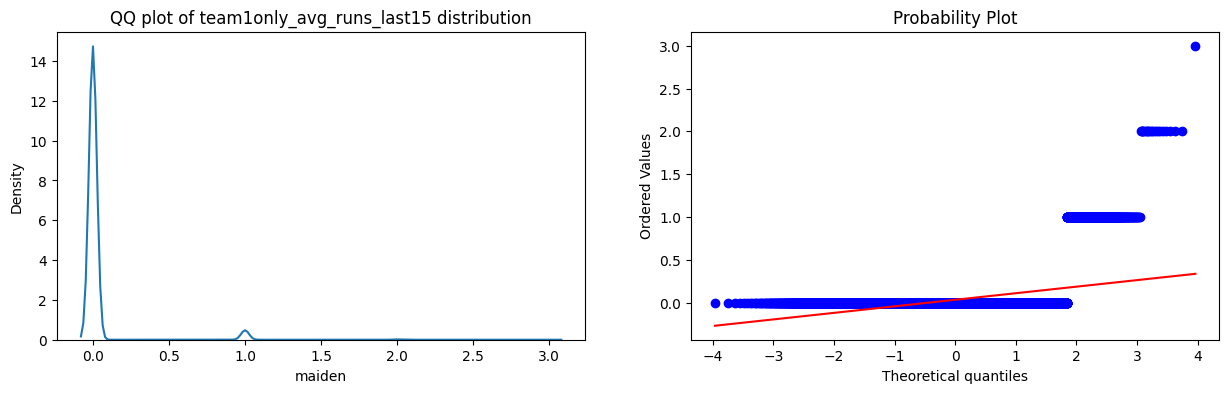

In [27]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,4))
ax1.set_title("maiden distribution")
sns.kdeplot(additional_data_bowler['maiden'],ax=ax1)
ax1.set_title("QQ plot of team1only_avg_runs_last15 distribution")
stats.probplot(additional_data_bowler['maiden'],plot=ax2)
# sns.kdeplot(x_transformed_df['ground_avg_runs_last15'],ax=ax1)


In [28]:
# Convert 'match_dt' columns to datetime format in both DataFrames
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Function to calculate player mean economy rate for the last 5 matches up to a given date, inning-wise
def calculate_past_player_mean_economy_rate(match_dt, inning):
    past_matches = additional_data_bowler[(additional_data_bowler['match_dt'] < match_dt) &
                                          (additional_data_bowler['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('bowler_id').head(10)
    return past_matches.groupby('bowler_id')['economy'].mean().reset_index()

# Function to calculate team mean economy rate based on past matches up to the current match date, inning-wise
def calculate_team_mean_economy(roster_ids, player_mean_economy):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_economy = player_mean_economy[player_mean_economy['bowler_id'].isin(player_ids)]['economy']
    return mean_economy.mean() if not mean_economy.empty else 0

# Calculate team1 and team2 mean economy rates based on past matches, inning-wise
def calculate_team_mean_economy_for_past_matches(row, inning):
    player_mean_economy_up_to_date = calculate_past_player_mean_economy_rate(row['match_dt'], inning)
    team1_mean_economy = calculate_team_mean_economy(row['team1_roster_ids'], player_mean_economy_up_to_date)
    team2_mean_economy = calculate_team_mean_economy(row['team2_roster_ids'], player_mean_economy_up_to_date)
    return team1_mean_economy, team2_mean_economy

# Apply the function to each row in train_data for both innings
mean_economy_results_inning1 = train_data.apply(lambda row: calculate_team_mean_economy_for_past_matches(row, 1), axis=1)
train_data['team1_mean_economy_1st'] = mean_economy_results_inning1.apply(lambda x: x[0])
train_data['team2_mean_economy_1st'] = mean_economy_results_inning1.apply(lambda x: x[1])

mean_economy_results_inning2 = train_data.apply(lambda row: calculate_team_mean_economy_for_past_matches(row, 2), axis=1)
train_data['team1_mean_economy_2nd'] = mean_economy_results_inning2.apply(lambda x: x[0])
train_data['team2_mean_economy_2nd'] = mean_economy_results_inning2.apply(lambda x: x[1])

# Calculate the ratio of team1 mean economy rates to team2 mean economy rates for each inning
train_data['team1_by_2_economy_1st'] = train_data['team1_mean_economy_1st'] / train_data['team2_mean_economy_1st']
train_data['team1_by_2_economy_2nd'] = train_data['team1_mean_economy_2nd'] / train_data['team2_mean_economy_2nd']

# Handle cases where division by zero might occur
train_data['team1_by_2_economy_1st'] = train_data['team1_by_2_economy_1st'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_economy_2nd'] = train_data['team1_by_2_economy_2nd'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'team1_mean_economy_1st', 'team2_mean_economy_1st', 'team1_by_2_economy_1st', 'team1_mean_economy_2nd', 'team2_mean_economy_2nd', 'team1_by_2_economy_2nd']].head())


     team1  team2   match_dt  team1_mean_economy_1st  team2_mean_economy_1st  \
616  Be Ht  Ht Hs 2022-01-01                8.607292                7.820151   
298  Ph Ss  Me Ss 2022-01-02                7.818940               11.204667   
902  Me Ss  Me Rs 2022-01-03               10.572240                8.295865   
476  Ht Hs  Ae Ss 2022-01-05                9.028571                9.352000   
604  Be Ht  Me Rs 2022-01-06                7.780000                8.775238   

     team1_by_2_economy_1st  team1_mean_economy_2nd  team2_mean_economy_2nd  \
616                1.100655                8.156250                8.413726   
298                0.697829                8.092508                8.876333   
902                1.274399                9.042778                7.851738   
476                0.965416               10.154556                7.355593   
604                0.886586                6.430000                7.756738   

     team1_by_2_economy_2nd  
616           

In [29]:
# Convert 'match_dt' columns to datetime format in both DataFrames
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Function to calculate player mean economy rate for the last 5 matches up to a given date, inning-wise
def calculate_past_player_mean_economy_rate(match_dt, inning):
    past_matches = additional_data_bowler[(additional_data_bowler['match_dt'] < match_dt) &
                                          (additional_data_bowler['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('bowler_id').head(10)
    return past_matches.groupby('bowler_id')['economy'].mean().reset_index()

# Function to calculate team mean economy rate based on past matches up to the current match date, inning-wise
def calculate_team_mean_economy(roster_ids, player_mean_economy):
    if pd.isna(roster_ids):
        return 0
    player_ids = [float(id) for id in roster_ids.split(':')]
    mean_economy = player_mean_economy[player_mean_economy['bowler_id'].isin(player_ids)]['economy']
    return mean_economy.mean() if not mean_economy.empty else 0

# Calculate team1 and team2 mean economy rates based on past matches, inning-wise
def calculate_team_mean_economy_for_past_matches(row, inning):
    player_mean_economy_up_to_date = calculate_past_player_mean_economy_rate(row['match_dt'], inning)
    team1_mean_economy = calculate_team_mean_economy(row['team1_roster_ids'], player_mean_economy_up_to_date)
    team2_mean_economy = calculate_team_mean_economy(row['team2_roster_ids'], player_mean_economy_up_to_date)
    return team1_mean_economy, team2_mean_economy

# Apply the function to each row in test_data for both innings
mean_economy_results_inning1 = test_data.apply(lambda row: calculate_team_mean_economy_for_past_matches(row, 1), axis=1)
test_data['team1_mean_economy_1st'] = mean_economy_results_inning1.apply(lambda x: x[0])
test_data['team2_mean_economy_1st'] = mean_economy_results_inning1.apply(lambda x: x[1])

mean_economy_results_inning2 = test_data.apply(lambda row: calculate_team_mean_economy_for_past_matches(row, 2), axis=1)
test_data['team1_mean_economy_2nd'] = mean_economy_results_inning2.apply(lambda x: x[0])
test_data['team2_mean_economy_2nd'] = mean_economy_results_inning2.apply(lambda x: x[1])

# Calculate the ratio of team1 mean economy rates to team2 mean economy rates for each inning
test_data['team1_by_2_economy_1st'] = test_data['team1_mean_economy_1st'] / test_data['team2_mean_economy_1st']
test_data['team1_by_2_economy_2nd'] = test_data['team1_mean_economy_2nd'] / test_data['team2_mean_economy_2nd']

# Handle cases where division by zero might occur
test_data['team1_by_2_economy_1st'] = test_data['team1_by_2_economy_1st'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_economy_2nd'] = test_data['team1_by_2_economy_2nd'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'team1_mean_economy_1st', 'team2_mean_economy_1st', 'team1_by_2_economy_1st', 'team1_mean_economy_2nd', 'team2_mean_economy_2nd', 'team1_by_2_economy_2nd']].head())


     team1  team2   match_dt  team1_mean_economy_1st  team2_mean_economy_1st  \
269  Sy Tr  Me Rs 2022-01-08                8.730357                8.245238   
80   Ht Hs  Sy Tr 2022-01-10                7.479750                8.730357   
251  Ae Ss  Be Ht 2022-01-12                8.702250                8.330500   
48   Ht Hs  Sy Tr 2022-01-13                8.794781                8.730357   
155  Ae Ss  Me Ss 2022-01-15                8.569000               10.239739   

     team1_by_2_economy_1st  team1_mean_economy_2nd  team2_mean_economy_2nd  \
269                1.058836                8.358218                7.511833   
80                 0.856752                9.602439                8.358218   
251                1.044625                6.824375                9.996111   
48                 1.007379                9.602439                8.358218   
155                0.836838                7.503900                8.747271   

     team1_by_2_economy_2nd  
269           

In [30]:
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])  # Ensure date is in datetime format
additional_data_bowler['dots'] = additional_data_bowler['dots'].astype(float)

# Sort the data by bowler_id and match_dt
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

def get_last_5_matches_avg_dots_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['dots'].mean()
    return past_matches.tail(10)['dots'].mean()

def calculate_team_avg_dots_last5(team_roster, match_dt, bowler_data, inning):
    player_ids = list(map(float, team_roster.split(':')))
    avg_dots_list = []
    for player_id in player_ids:
        player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
        avg_dots = get_last_5_matches_avg_dots_up_to(match_dt, player_data)
        avg_dots_list.append(avg_dots)
    if avg_dots_list:
        return sum(avg_dots_list) / len(avg_dots_list)
    else:
        return float('nan')

for inning in [1, 2]:
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    train_data[f'team1_avg_dots_inning{inning}_last5'] = train_data.apply(
        lambda row: calculate_team_avg_dots_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
    train_data[f'team2_avg_dots_inning{inning}_last5'] = train_data.apply(
        lambda row: calculate_team_avg_dots_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

    # Calculate the ratio of team1 to team2 average dots for the last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_avg_dots_inning{inning}_last5']
        team2_avg = row[f'team2_avg_dots_inning{inning}_last5']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    train_data[f'team1_by_2_dots_inning{inning}_last5'] = train_data.apply(calculate_ratio, axis=1)

# Handle missing values
train_data.fillna(0, inplace=True)


In [31]:
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])  # Ensure date is in datetime format
additional_data_bowler['dots'] = additional_data_bowler['dots'].astype(float)

# Sort the data by bowler_id and match_dt
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

def get_last_5_matches_avg_dots_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['dots'].mean()
    return past_matches.tail(10)['dots'].mean()

def calculate_team_avg_dots_last5(team_roster, match_dt, bowler_data, inning):
    player_ids = list(map(float, team_roster.split(':')))
    avg_dots_list = []
    for player_id in player_ids:
        player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
        avg_dots = get_last_5_matches_avg_dots_up_to(match_dt, player_data)
        avg_dots_list.append(avg_dots)
    if avg_dots_list:
        return sum(avg_dots_list) / len(avg_dots_list)
    else:
        return float('nan')

for inning in [1, 2]:
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    test_data[f'team1_avg_dots_inning{inning}_last5'] = test_data.apply(
        lambda row: calculate_team_avg_dots_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
    test_data[f'team2_avg_dots_inning{inning}_last5'] = test_data.apply(
        lambda row: calculate_team_avg_dots_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

    # Calculate the ratio of team1 to team2 average dots for the last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_avg_dots_inning{inning}_last5']
        team2_avg = row[f'team2_avg_dots_inning{inning}_last5']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    test_data[f'team1_by_2_dots_inning{inning}_last5'] = test_data.apply(calculate_ratio, axis=1)

# Handle missing values
test_data.fillna(0, inplace=True)


In [32]:
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])  # Ensure date is in datetime format

# Sort the data by bowler_id and match_dt
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

def get_last_5_matches_avg_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['maiden'].mean()
    return past_matches.tail(10)['maiden'].mean()

def calculate_team_avg_maidens_last5(team_roster, match_dt, bowler_data):
    player_ids = list(map(float, team_roster.split(':')))
    avg_maidens_list = []
    for player_id in player_ids:
        player_data = bowler_data[bowler_data['bowler_id'] == player_id]
        avg_maidens = get_last_5_matches_avg_up_to(match_dt, player_data)
        avg_maidens_list.append(avg_maidens)
    if avg_maidens_list:
        return sum(avg_maidens_list) / len(avg_maidens_list)
    else:
        return float('nan')

for inning in [1, 2]:
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    train_data[f'team1_avg_maidens_inning{inning}_last5'] = train_data.apply(
        lambda row: calculate_team_avg_maidens_last5(row['team1_roster_ids'], row['match_dt'], inning_data), axis=1)
    
    train_data[f'team2_avg_maidens_inning{inning}_last5'] = train_data.apply(
        lambda row: calculate_team_avg_maidens_last5(row['team2_roster_ids'], row['match_dt'], inning_data), axis=1)

    # Calculate the ratio of team1 to team2 average maidens for the last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_avg_maidens_inning{inning}_last5']
        team2_avg = row[f'team2_avg_maidens_inning{inning}_last5']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    train_data[f'team1_by_2_maidens_inning{inning}_last5'] = train_data.apply(calculate_ratio, axis=1)

# Handle missing values
train_data.fillna(0, inplace=True)


In [33]:
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])  # Ensure date is in datetime format

# Sort the data by bowler_id and match_dt
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

def get_last_5_matches_avg_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['maiden'].mean()
    return past_matches.tail(10)['maiden'].mean()

def calculate_team_avg_maidens_last5(team_roster, match_dt, bowler_data):
    player_ids = list(map(float, team_roster.split(':')))
    avg_maidens_list = []
    for player_id in player_ids:
        player_data = bowler_data[bowler_data['bowler_id'] == player_id]
        avg_maidens = get_last_5_matches_avg_up_to(match_dt, player_data)
        avg_maidens_list.append(avg_maidens)
    if avg_maidens_list:
        return sum(avg_maidens_list) / len(avg_maidens_list)
    else:
        return float('nan')

for inning in [1, 2]:
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    test_data[f'team1_avg_maidens_inning{inning}_last5'] = test_data.apply(
        lambda row: calculate_team_avg_maidens_last5(row['team1_roster_ids'], row['match_dt'], inning_data), axis=1)
    
    test_data[f'team2_avg_maidens_inning{inning}_last5'] = test_data.apply(
        lambda row: calculate_team_avg_maidens_last5(row['team2_roster_ids'], row['match_dt'], inning_data), axis=1)

    # Calculate the ratio of team1 to team2 average maidens for the last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_avg_maidens_inning{inning}_last5']
        team2_avg = row[f'team2_avg_maidens_inning{inning}_last5']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    test_data[f'team1_by_2_maidens_inning{inning}_last5'] = test_data.apply(calculate_ratio, axis=1)

# Handle missing values
test_data.fillna(0, inplace=True)


In [34]:
additional_data_bowler.columns

Index(['match id', 'bowler', 'bowler_id', 'bowler_details',
       'is_bowler_captain', 'is_bowler_keeper', 'inning', 'runs',
       'wicket_count', 'balls_bowled', 'economy', 'maiden', 'dots', 'Fours',
       'Sixes', 'wides', 'noballs', 'match_dt'],
      dtype='object')

In [35]:
# Convert 'match_dt' columns to datetime format in both DataFrames
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Helper function to calculate total number of wides and no-balls conceded for the last 10 matches up to a given date, inning-wise
def calculate_past_bowler_extras(match_dt, inning):
    past_matches = additional_data_bowler[(additional_data_bowler['match_dt'] < match_dt) &
                                          (additional_data_bowler['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('bowler_id').head(10)
    return past_matches.groupby('bowler_id')[['wides', 'noballs']].sum().reset_index()

# Function to calculate team max wides and no-balls conceded based on past matches up to the current match date, inning-wise
def calculate_team_max_conceded_extras(roster_ids, bowler_extras):
    if pd.isna(roster_ids):
        return 0, 0
    bowler_ids = [float(id) for id in roster_ids.split(':')]
    team_extras = bowler_extras[bowler_extras['bowler_id'].isin(bowler_ids)]
    max_wides = team_extras['wides'].max() if not team_extras.empty else 0
    max_noballs = team_extras['noballs'].max() if not team_extras.empty else 0
    return max_wides, max_noballs

# Calculate team1 and team2 max wides and no-balls conceded based on past matches, inning-wise
def calculate_team_max_conceded_extras_for_past_matches(row, inning):
    bowler_extras_up_to_date = calculate_past_bowler_extras(row['match_dt'], inning)
    team1_max_wides, team1_max_noballs = calculate_team_max_conceded_extras(row['team1_roster_ids'], bowler_extras_up_to_date)
    team2_max_wides, team2_max_noballs = calculate_team_max_conceded_extras(row['team2_roster_ids'], bowler_extras_up_to_date)
    return team1_max_wides, team2_max_wides, team1_max_noballs, team2_max_noballs

# Apply the function to each row in train_data for both innings
max_extras_results_inning1 = train_data.apply(lambda row: calculate_team_max_conceded_extras_for_past_matches(row, 1), axis=1)
train_data['team1_max_conceded_wides_inning1'] = max_extras_results_inning1.apply(lambda x: x[0])
train_data['team2_max_conceded_wides_inning1'] = max_extras_results_inning1.apply(lambda x: x[1])
train_data['team1_max_conceded_noballs_inning1'] = max_extras_results_inning1.apply(lambda x: x[2])
train_data['team2_max_conceded_noballs_inning1'] = max_extras_results_inning1.apply(lambda x: x[3])

max_extras_results_inning2 = train_data.apply(lambda row: calculate_team_max_conceded_extras_for_past_matches(row, 2), axis=1)
train_data['team1_max_conceded_wides_inning2'] = max_extras_results_inning2.apply(lambda x: x[0])
train_data['team2_max_conceded_wides_inning2'] = max_extras_results_inning2.apply(lambda x: x[1])
train_data['team1_max_conceded_noballs_inning2'] = max_extras_results_inning2.apply(lambda x: x[2])
train_data['team2_max_conceded_noballs_inning2'] = max_extras_results_inning2.apply(lambda x: x[3])

# Calculate the ratios of the maximum number of wides and no-balls conceded for team1 to team2 for each inning
train_data['team1_by_2_max_conceded_wides_inning1'] = train_data['team1_max_conceded_wides_inning1'] / train_data['team2_max_conceded_wides_inning1']
train_data['team1_by_2_max_conceded_wides_inning2'] = train_data['team1_max_conceded_wides_inning2'] / train_data['team2_max_conceded_wides_inning2']
train_data['team1_by_2_max_conceded_noballs_inning1'] = train_data['team1_max_conceded_noballs_inning1'] / train_data['team2_max_conceded_noballs_inning1']
train_data['team1_by_2_max_conceded_noballs_inning2'] = train_data['team1_max_conceded_noballs_inning2'] / train_data['team2_max_conceded_noballs_inning2']

# Handle cases where division by zero might occur
train_data['team1_by_2_max_conceded_wides_inning1'] = train_data['team1_by_2_max_conceded_wides_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_conceded_wides_inning2'] = train_data['team1_by_2_max_conceded_wides_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_conceded_noballs_inning1'] = train_data['team1_by_2_max_conceded_noballs_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_conceded_noballs_inning2'] = train_data['team1_by_2_max_conceded_noballs_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'team1_max_conceded_wides_inning1', 'team2_max_conceded_wides_inning1', 'team1_by_2_max_conceded_wides_inning1', 
                 'team1_max_conceded_wides_inning2', 'team2_max_conceded_wides_inning2', 'team1_by_2_max_conceded_wides_inning2',
                 'team1_max_conceded_noballs_inning1', 'team2_max_conceded_noballs_inning1', 'team1_by_2_max_conceded_noballs_inning1', 
                 'team1_max_conceded_noballs_inning2', 'team2_max_conceded_noballs_inning2', 'team1_by_2_max_conceded_noballs_inning2']].head())


     team1  team2   match_dt  team1_max_conceded_wides_inning1  \
616  Be Ht  Ht Hs 2022-01-01                                14   
298  Ph Ss  Me Ss 2022-01-02                                10   
902  Me Ss  Me Rs 2022-01-03                                 9   
476  Ht Hs  Ae Ss 2022-01-05                                 7   
604  Be Ht  Me Rs 2022-01-06                                 5   

     team2_max_conceded_wides_inning1  team1_by_2_max_conceded_wides_inning1  \
616                                10                                   1.40   
298                                 8                                   1.25   
902                                 9                                   1.00   
476                                 4                                   1.75   
604                                10                                   0.50   

     team1_max_conceded_wides_inning2  team2_max_conceded_wides_inning2  \
616                                 4          

In [36]:
# Convert 'match_dt' columns to datetime format in both DataFrames
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Helper function to calculate total number of wides and no-balls conceded for the last 10 matches up to a given date, inning-wise
def calculate_past_bowler_extras(match_dt, inning):
    past_matches = additional_data_bowler[(additional_data_bowler['match_dt'] < match_dt) &
                                          (additional_data_bowler['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('bowler_id').head(10)
    return past_matches.groupby('bowler_id')[['wides', 'noballs']].sum().reset_index()

# Function to calculate team max wides and no-balls conceded based on past matches up to the current match date, inning-wise
def calculate_team_max_conceded_extras(roster_ids, bowler_extras):
    if pd.isna(roster_ids):
        return 0, 0
    bowler_ids = [float(id) for id in roster_ids.split(':')]
    team_extras = bowler_extras[bowler_extras['bowler_id'].isin(bowler_ids)]
    max_wides = team_extras['wides'].max() if not team_extras.empty else 0
    max_noballs = team_extras['noballs'].max() if not team_extras.empty else 0
    return max_wides, max_noballs

# Calculate team1 and team2 max wides and no-balls conceded based on past matches, inning-wise
def calculate_team_max_conceded_extras_for_past_matches(row, inning):
    bowler_extras_up_to_date = calculate_past_bowler_extras(row['match_dt'], inning)
    team1_max_wides, team1_max_noballs = calculate_team_max_conceded_extras(row['team1_roster_ids'], bowler_extras_up_to_date)
    team2_max_wides, team2_max_noballs = calculate_team_max_conceded_extras(row['team2_roster_ids'], bowler_extras_up_to_date)
    return team1_max_wides, team2_max_wides, team1_max_noballs, team2_max_noballs

# Apply the function to each row in test_data for both innings
max_extras_results_inning1 = test_data.apply(lambda row: calculate_team_max_conceded_extras_for_past_matches(row, 1), axis=1)
test_data['team1_max_conceded_wides_inning1'] = max_extras_results_inning1.apply(lambda x: x[0])
test_data['team2_max_conceded_wides_inning1'] = max_extras_results_inning1.apply(lambda x: x[1])
test_data['team1_max_conceded_noballs_inning1'] = max_extras_results_inning1.apply(lambda x: x[2])
test_data['team2_max_conceded_noballs_inning1'] = max_extras_results_inning1.apply(lambda x: x[3])

max_extras_results_inning2 = test_data.apply(lambda row: calculate_team_max_conceded_extras_for_past_matches(row, 2), axis=1)
test_data['team1_max_conceded_wides_inning2'] = max_extras_results_inning2.apply(lambda x: x[0])
test_data['team2_max_conceded_wides_inning2'] = max_extras_results_inning2.apply(lambda x: x[1])
test_data['team1_max_conceded_noballs_inning2'] = max_extras_results_inning2.apply(lambda x: x[2])
test_data['team2_max_conceded_noballs_inning2'] = max_extras_results_inning2.apply(lambda x: x[3])

# Calculate the ratios of the maximum number of wides and no-balls conceded for team1 to team2 for each inning
test_data['team1_by_2_max_conceded_wides_inning1'] = test_data['team1_max_conceded_wides_inning1'] / test_data['team2_max_conceded_wides_inning1']
test_data['team1_by_2_max_conceded_wides_inning2'] = test_data['team1_max_conceded_wides_inning2'] / test_data['team2_max_conceded_wides_inning2']
test_data['team1_by_2_max_conceded_noballs_inning1'] = test_data['team1_max_conceded_noballs_inning1'] / test_data['team2_max_conceded_noballs_inning1']
test_data['team1_by_2_max_conceded_noballs_inning2'] = test_data['team1_max_conceded_noballs_inning2'] / test_data['team2_max_conceded_noballs_inning2']

# Handle cases where division by zero might occur
test_data['team1_by_2_max_conceded_wides_inning1'] = test_data['team1_by_2_max_conceded_wides_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_conceded_wides_inning2'] = test_data['team1_by_2_max_conceded_wides_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_conceded_noballs_inning1'] = test_data['team1_by_2_max_conceded_noballs_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_conceded_noballs_inning2'] = test_data['team1_by_2_max_conceded_noballs_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'team1_max_conceded_wides_inning1', 'team2_max_conceded_wides_inning1', 'team1_by_2_max_conceded_wides_inning1', 
                 'team1_max_conceded_wides_inning2', 'team2_max_conceded_wides_inning2', 'team1_by_2_max_conceded_wides_inning2',
                 'team1_max_conceded_noballs_inning1', 'team2_max_conceded_noballs_inning1', 'team1_by_2_max_conceded_noballs_inning1', 
                 'team1_max_conceded_noballs_inning2', 'team2_max_conceded_noballs_inning2', 'team1_by_2_max_conceded_noballs_inning2']].head())


     team1  team2   match_dt  team1_max_conceded_wides_inning1  \
269  Sy Tr  Me Rs 2022-01-08                                 9   
80   Ht Hs  Sy Tr 2022-01-10                                12   
251  Ae Ss  Be Ht 2022-01-12                                 4   
48   Ht Hs  Sy Tr 2022-01-13                                12   
155  Ae Ss  Me Ss 2022-01-15                                 4   

     team2_max_conceded_wides_inning1  team1_by_2_max_conceded_wides_inning1  \
269                                11                               0.818182   
80                                  9                               1.333333   
251                                14                               0.285714   
48                                  9                               1.333333   
155                                 9                               0.444444   

     team1_max_conceded_wides_inning2  team2_max_conceded_wides_inning2  \
269                                15          

In [37]:
# Convert 'match_dt' columns to datetime format in both DataFrames
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Helper function to calculate total number of fours and sixes conceded for the last 10 matches up to a given date, inning-wise
def calculate_past_bowler_fours_sixes(match_dt, inning):
    past_matches = additional_data_bowler[(additional_data_bowler['match_dt'] < match_dt) &
                                          (additional_data_bowler['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('bowler_id').head(10)
    return past_matches.groupby('bowler_id')[['Fours', 'Sixes']].sum().reset_index()

# Function to calculate team max fours and sixes conceded based on past matches up to the current match date, inning-wise
def calculate_team_max_conceded_fours_sixes(roster_ids, bowler_fours_sixes):
    if pd.isna(roster_ids):
        return 0, 0
    bowler_ids = [float(id) for id in roster_ids.split(':')]
    team_fours_sixes = bowler_fours_sixes[bowler_fours_sixes['bowler_id'].isin(bowler_ids)]
    max_fours = team_fours_sixes['Fours'].max() if not team_fours_sixes.empty else 0
    max_sixes = team_fours_sixes['Sixes'].max() if not team_fours_sixes.empty else 0
    return max_fours, max_sixes

# Calculate team1 and team2 max fours and sixes conceded based on past matches, inning-wise
def calculate_team_max_conceded_fours_sixes_for_past_matches(row, inning):
    bowler_fours_sixes_up_to_date = calculate_past_bowler_fours_sixes(row['match_dt'], inning)
    team1_max_fours, team1_max_sixes = calculate_team_max_conceded_fours_sixes(row['team1_roster_ids'], bowler_fours_sixes_up_to_date)
    team2_max_fours, team2_max_sixes = calculate_team_max_conceded_fours_sixes(row['team2_roster_ids'], bowler_fours_sixes_up_to_date)
    return team1_max_fours, team2_max_fours, team1_max_sixes, team2_max_sixes

# Apply the function to each row in train_data for both innings
max_conceded_fours_sixes_results_inning1 = train_data.apply(lambda row: calculate_team_max_conceded_fours_sixes_for_past_matches(row, 1), axis=1)
train_data['team1_max_conceded_fours_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[0])
train_data['team2_max_conceded_fours_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[1])
train_data['team1_max_conceded_sixes_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[2])
train_data['team2_max_conceded_sixes_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[3])

max_conceded_fours_sixes_results_inning2 = train_data.apply(lambda row: calculate_team_max_conceded_fours_sixes_for_past_matches(row, 2), axis=1)
train_data['team1_max_conceded_fours_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[0])
train_data['team2_max_conceded_fours_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[1])
train_data['team1_max_conceded_sixes_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[2])
train_data['team2_max_conceded_sixes_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[3])

# Calculate the ratios of the maximum number of fours and sixes conceded for team1 to team2 for each inning
train_data['team1_by_2_max_conceded_fours_inning1'] = train_data['team1_max_conceded_fours_inning1'] / train_data['team2_max_conceded_fours_inning1']
train_data['team1_by_2_max_conceded_fours_inning2'] = train_data['team1_max_conceded_fours_inning2'] / train_data['team2_max_conceded_fours_inning2']
train_data['team1_by_2_max_conceded_sixes_inning1'] = train_data['team1_max_conceded_sixes_inning1'] / train_data['team2_max_conceded_sixes_inning1']
train_data['team1_by_2_max_conceded_sixes_inning2'] = train_data['team1_max_conceded_sixes_inning2'] / train_data['team2_max_conceded_sixes_inning2']

# Handle cases where division by zero might occur
train_data['team1_by_2_max_conceded_fours_inning1'] = train_data['team1_by_2_max_conceded_fours_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_conceded_fours_inning2'] = train_data['team1_by_2_max_conceded_fours_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_conceded_sixes_inning1'] = train_data['team1_by_2_max_conceded_sixes_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
train_data['team1_by_2_max_conceded_sixes_inning2'] = train_data['team1_by_2_max_conceded_sixes_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'team1_max_conceded_fours_inning1', 'team2_max_conceded_fours_inning1', 'team1_by_2_max_conceded_fours_inning1', 
                 'team1_max_conceded_fours_inning2', 'team2_max_conceded_fours_inning2', 'team1_by_2_max_conceded_fours_inning2',
                 'team1_max_conceded_sixes_inning1', 'team2_max_conceded_sixes_inning1', 'team1_by_2_max_conceded_sixes_inning1', 
                 'team1_max_conceded_sixes_inning2', 'team2_max_conceded_sixes_inning2', 'team1_by_2_max_conceded_sixes_inning2']].head())


     team1  team2   match_dt  team1_max_conceded_fours_inning1  \
616  Be Ht  Ht Hs 2022-01-01                                28   
298  Ph Ss  Me Ss 2022-01-02                                22   
902  Me Ss  Me Rs 2022-01-03                                35   
476  Ht Hs  Ae Ss 2022-01-05                                23   
604  Be Ht  Me Rs 2022-01-06                                21   

     team2_max_conceded_fours_inning1  team1_by_2_max_conceded_fours_inning1  \
616                                34                               0.823529   
298                                38                               0.578947   
902                                37                               0.945946   
476                                19                               1.210526   
604                                38                               0.552632   

     team1_max_conceded_fours_inning2  team2_max_conceded_fours_inning2  \
616                                16          

In [38]:
# Convert 'match_dt' columns to datetime format in both DataFrames
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Helper function to calculate total number of fours and sixes conceded for the last 10 matches up to a given date, inning-wise
def calculate_past_bowler_fours_sixes(match_dt, inning):
    past_matches = additional_data_bowler[(additional_data_bowler['match_dt'] < match_dt) &
                                          (additional_data_bowler['inning'] == inning)]
    past_matches = past_matches.sort_values(by='match_dt', ascending=False).groupby('bowler_id').head(10)
    return past_matches.groupby('bowler_id')[['Fours', 'Sixes']].sum().reset_index()

# Function to calculate team max fours and sixes conceded based on past matches up to the current match date, inning-wise
def calculate_team_max_conceded_fours_sixes(roster_ids, bowler_fours_sixes):
    if pd.isna(roster_ids):
        return 0, 0
    bowler_ids = [float(id) for id in roster_ids.split(':')]
    team_fours_sixes = bowler_fours_sixes[bowler_fours_sixes['bowler_id'].isin(bowler_ids)]
    max_fours = team_fours_sixes['Fours'].max() if not team_fours_sixes.empty else 0
    max_sixes = team_fours_sixes['Sixes'].max() if not team_fours_sixes.empty else 0
    return max_fours, max_sixes

# Calculate team1 and team2 max fours and sixes conceded based on past matches, inning-wise
def calculate_team_max_conceded_fours_sixes_for_past_matches(row, inning):
    bowler_fours_sixes_up_to_date = calculate_past_bowler_fours_sixes(row['match_dt'], inning)
    team1_max_fours, team1_max_sixes = calculate_team_max_conceded_fours_sixes(row['team1_roster_ids'], bowler_fours_sixes_up_to_date)
    team2_max_fours, team2_max_sixes = calculate_team_max_conceded_fours_sixes(row['team2_roster_ids'], bowler_fours_sixes_up_to_date)
    return team1_max_fours, team2_max_fours, team1_max_sixes, team2_max_sixes

# Apply the function to each row in test_data for both innings
max_conceded_fours_sixes_results_inning1 = test_data.apply(lambda row: calculate_team_max_conceded_fours_sixes_for_past_matches(row, 1), axis=1)
test_data['team1_max_conceded_fours_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[0])
test_data['team2_max_conceded_fours_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[1])
test_data['team1_max_conceded_sixes_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[2])
test_data['team2_max_conceded_sixes_inning1'] = max_conceded_fours_sixes_results_inning1.apply(lambda x: x[3])

max_conceded_fours_sixes_results_inning2 = test_data.apply(lambda row: calculate_team_max_conceded_fours_sixes_for_past_matches(row, 2), axis=1)
test_data['team1_max_conceded_fours_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[0])
test_data['team2_max_conceded_fours_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[1])
test_data['team1_max_conceded_sixes_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[2])
test_data['team2_max_conceded_sixes_inning2'] = max_conceded_fours_sixes_results_inning2.apply(lambda x: x[3])

# Calculate the ratios of the maximum number of fours and sixes conceded for team1 to team2 for each inning
test_data['team1_by_2_max_conceded_fours_inning1'] = test_data['team1_max_conceded_fours_inning1'] / test_data['team2_max_conceded_fours_inning1']
test_data['team1_by_2_max_conceded_fours_inning2'] = test_data['team1_max_conceded_fours_inning2'] / test_data['team2_max_conceded_fours_inning2']
test_data['team1_by_2_max_conceded_sixes_inning1'] = test_data['team1_max_conceded_sixes_inning1'] / test_data['team2_max_conceded_sixes_inning1']
test_data['team1_by_2_max_conceded_sixes_inning2'] = test_data['team1_max_conceded_sixes_inning2'] / test_data['team2_max_conceded_sixes_inning2']

# Handle cases where division by zero might occur
test_data['team1_by_2_max_conceded_fours_inning1'] = test_data['team1_by_2_max_conceded_fours_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_conceded_fours_inning2'] = test_data['team1_by_2_max_conceded_fours_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_conceded_sixes_inning1'] = test_data['team1_by_2_max_conceded_sixes_inning1'].replace([float('inf'), -float('inf')], 0).fillna(0)
test_data['team1_by_2_max_conceded_sixes_inning2'] = test_data['team1_by_2_max_conceded_sixes_inning2'].replace([float('inf'), -float('inf')], 0).fillna(0)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'team1_max_conceded_fours_inning1', 'team2_max_conceded_fours_inning1', 'team1_by_2_max_conceded_fours_inning1', 
                 'team1_max_conceded_fours_inning2', 'team2_max_conceded_fours_inning2', 'team1_by_2_max_conceded_fours_inning2',
                 'team1_max_conceded_sixes_inning1', 'team2_max_conceded_sixes_inning1', 'team1_by_2_max_conceded_sixes_inning1', 
                 'team1_max_conceded_sixes_inning2', 'team2_max_conceded_sixes_inning2', 'team1_by_2_max_conceded_sixes_inning2']].head())


     team1  team2   match_dt  team1_max_conceded_fours_inning1  \
269  Sy Tr  Me Rs 2022-01-08                                22   
80   Ht Hs  Sy Tr 2022-01-10                                22   
251  Ae Ss  Be Ht 2022-01-12                                18   
48   Ht Hs  Sy Tr 2022-01-13                                22   
155  Ae Ss  Me Ss 2022-01-15                                13   

     team2_max_conceded_fours_inning1  team1_by_2_max_conceded_fours_inning1  \
269                                36                               0.611111   
80                                 22                               1.000000   
251                                24                               0.750000   
48                                 22                               1.000000   
155                                20                               0.650000   

     team1_max_conceded_fours_inning2  team2_max_conceded_fours_inning2  \
269                                37          

In [39]:
# # Convert relevant columns to float if they are not already
# additional_data_bowler['wides'] = additional_data_bowler['wides'].astype(float)
# additional_data_bowler['noballs'] = additional_data_bowler['noballs'].astype(float)

# # Ensure date is in datetime format and sort by bowler_id and match_dt
# additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])
# additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

# # Calculate average wides and no-balls per bowler per inning
# bowler_avg_wides_noballs = additional_data_bowler.groupby(['bowler_id', 'inning'])[['wides', 'noballs']].mean().reset_index()
# bowler_avg_wides_noballs['wides_noballs'] = bowler_avg_wides_noballs['wides'] + bowler_avg_wides_noballs['noballs']
# bowler_avg_wides_noballs = bowler_avg_wides_noballs[['bowler_id', 'inning', 'wides_noballs']]

# # Function to get the average wides and no-balls for a player in the last 5 matches up to a specific date
# def get_last_5_matches_avg_wides_noballs_up_to(match_dt, bowler_data):
#     past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
#     if len(past_matches) < 5:
#         return past_matches['wides_noballs'].mean()
#     return past_matches.tail(5)['wides_noballs'].mean()

# # Function to calculate the average wides and no-balls for a team per innings using the last 5 matches
# def calculate_team_avg_wides_noballs_last5(team_roster, match_dt, bowler_data, inning):
#     player_ids = list(map(float, team_roster.split(':')))
#     avg_wides_noballs_list = []
#     for player_id in player_ids:
#         player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
#         avg_wides_noballs = get_last_5_matches_avg_wides_noballs_up_to(match_dt, player_data)
#         avg_wides_noballs_list.append(avg_wides_noballs)
#     if avg_wides_noballs_list:
#         return sum(avg_wides_noballs_list) / len(avg_wides_noballs_list)
#     else:
#         return float('nan')

# # Calculate average wides and no-balls for team1 and team2 for both innings using the last 5 matches
# for inning in [1, 2]:
#     inning_data = bowler_avg_wides_noballs[bowler_avg_wides_noballs['inning'] == inning]
    
#     train_data[f'team1_avg_wides_noballs_inning{inning}_last5'] = train_data.apply(
#         lambda row: calculate_team_avg_wides_noballs_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
#     train_data[f'team2_avg_wides_noballs_inning{inning}_last5'] = train_data.apply(
#         lambda row: calculate_team_avg_wides_noballs_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

#     # Calculate the ratio of team1 to team2 average wides_noballs for the last 5 matches, avoiding division by zero
#     def calculate_ratio(row):
#         team1_avg = row[f'team1_avg_wides_noballs_inning{inning}_last5']
#         team2_avg = row[f'team2_avg_wides_noballs_inning{inning}_last5']
#         if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
#             return float('nan')
#         return team1_avg / team2_avg

#     train_data[f'team1_by_2_wides_noballs_inning{inning}_last5'] = train_data.apply(calculate_ratio, axis=1)

# # Handle missing values
# train_data.fillna(0, inplace=True)


In [40]:
# # Convert relevant columns to float if they are not already
# additional_data_bowler['wides'] = additional_data_bowler['wides'].astype(float)
# additional_data_bowler['noballs'] = additional_data_bowler['noballs'].astype(float)

# # Sort data and calculate averages
# additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])  # Ensure date is in datetime format
# additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

# # Calculate average wides and no-balls per bowler per inning
# bowler_avg_wides_noballs = additional_data_bowler.groupby(['bowler_id', 'inning'])[['wides', 'noballs']].mean().reset_index()
# bowler_avg_wides_noballs['wides_noballs'] = bowler_avg_wides_noballs['wides'] + bowler_avg_wides_noballs['noballs']
# bowler_avg_wides_noballs = bowler_avg_wides_noballs[['bowler_id', 'inning', 'wides_noballs']]

# # Function to get the average wides and no-balls for a player in the last 5 matches up to a specific date
# def get_last_5_matches_avg_wides_noballs_up_to(match_dt, bowler_data):
#     past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
#     if len(past_matches) < 5:
#         return past_matches['wides_noballs'].mean()
#     return past_matches.tail(5)['wides_noballs'].mean()

# # Function to calculate the average wides and no-balls for a team per innings using the last 5 matches
# def calculate_team_avg_wides_noballs_last5(team_roster, match_dt, bowler_data, inning):
#     player_ids = list(map(float, team_roster.split(':')))
#     avg_wides_noballs_list = []
#     for player_id in player_ids:
#         player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
#         avg_wides_noballs = get_last_5_matches_avg_wides_noballs_up_to(match_dt, player_data)
#         avg_wides_noballs_list.append(avg_wides_noballs)
#     if avg_wides_noballs_list:
#         return sum(avg_wides_noballs_list) / len(avg_wides_noballs_list)
#     else:
#         return float('nan')

# # Calculate average wides and no-balls for team1 and team2 for both innings using the last 5 matches
# for inning in [1, 2]:
#     inning_data = bowler_avg_wides_noballs[bowler_avg_wides_noballs['inning'] == inning]
    
#     test_data[f'team1_avg_wides_noballs_inning{inning}_last5'] = test_data.apply(
#         lambda row: calculate_team_avg_wides_noballs_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
#     test_data[f'team2_avg_wides_noballs_inning{inning}_last5'] = test_data.apply(
#         lambda row: calculate_team_avg_wides_noballs_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

#     # Calculate the ratio of team1 to team2 average wides_noballs for the last 5 matches, avoiding division by zero
#     def calculate_ratio(row):
#         team1_avg = row[f'team1_avg_wides_noballs_inning{inning}_last5']
#         team2_avg = row[f'team2_avg_wides_noballs_inning{inning}_last5']
#         if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
#             return float('nan')
#         return team1_avg / team2_avg

#     test_data[f'team1_by_2_wides_noballs_inning{inning}_last5'] = test_data.apply(calculate_ratio, axis=1)

# # Handle missing values
# test_data.fillna(0, inplace=True)


In [41]:
import pandas as pd
import numpy as np

# Ensure 'match_dt' is in datetime format
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Sort data by 'bowler_id' and 'match_dt' to ensure chronological order
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

# Function to calculate average wickets taken in the last 5 matches up to a specific date
def get_last_5_matches_avg_wickets_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['wicket_count'].mean()
    return past_matches.tail(10)['wicket_count'].mean()

# Function to calculate team mean wickets taken for last 5 matches for a specific innings
def calculate_team_mean_wickets_last5(team_roster, match_dt, bowler_data, inning):
    player_ids = list(map(float, team_roster.split(':')))
    avg_wickets_list = []
    for player_id in player_ids:
        player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
        avg_wickets = get_last_5_matches_avg_wickets_up_to(match_dt, player_data)
        avg_wickets_list.append(avg_wickets)
    if avg_wickets_list:
        return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
    else:
        return float('nan')

# Calculate team mean wickets taken for last 5 matches for team1 and team2 for both innings
for inning in [1, 2]:
    # Filter data for the specific inning
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    # Apply the function to calculate team mean wickets for team1 and team2
    train_data[f'team1_mean_wickets_last5_{inning}'] = train_data.apply(
        lambda row: calculate_team_mean_wickets_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
    train_data[f'team2_mean_wickets_last5_{inning}'] = train_data.apply(
        lambda row: calculate_team_mean_wickets_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

    # Calculate the ratio of team1 to team2 mean wickets taken for last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_mean_wickets_last5_{inning}']
        team2_avg = row[f'team2_mean_wickets_last5_{inning}']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    train_data[f'team1_by_2_wickets_taken_last5_{inning}'] = train_data.apply(calculate_ratio, axis=1)

# Handle missing values
train_data.fillna(0, inplace=True)


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1937027438.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1937027438.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1937027438.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1937027438.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully


In [42]:
import pandas as pd
import numpy as np

# Ensure 'match_dt' is in datetime format
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Sort data by 'bowler_id' and 'match_dt' to ensure chronological order
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

# Function to calculate average wickets taken in the last 5 matches up to a specific date
def get_last_5_matches_avg_wickets_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['wicket_count'].mean()
    return past_matches.tail(10)['wicket_count'].mean()

# Function to calculate team mean wickets taken for last 5 matches for a specific innings
def calculate_team_mean_wickets_last5(team_roster, match_dt, bowler_data, inning):
    player_ids = list(map(float, team_roster.split(':')))
    avg_wickets_list = []
    for player_id in player_ids:
        player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
        avg_wickets = get_last_5_matches_avg_wickets_up_to(match_dt, player_data)
        avg_wickets_list.append(avg_wickets)
    if avg_wickets_list:
        return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
    else:
        return float('nan')

# Calculate team mean wickets taken for last 5 matches for team1 and team2 for both innings
for inning in [1, 2]:
    # Filter data for the specific inning
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    # Apply the function to calculate team mean wickets for team1 and team2
    test_data[f'team1_mean_wickets_last5_{inning}'] = test_data.apply(
        lambda row: calculate_team_mean_wickets_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
    test_data[f'team2_mean_wickets_last5_{inning}'] = test_data.apply(
        lambda row: calculate_team_mean_wickets_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

    # Calculate the ratio of team1 to team2 mean wickets taken for last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_mean_wickets_last5_{inning}']
        team2_avg = row[f'team2_mean_wickets_last5_{inning}']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    test_data[f'team1_by_2_wickets_taken_last5_{inning}'] = test_data.apply(calculate_ratio, axis=1)

# Handle missing values
test_data.fillna(0, inplace=True)


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3290070910.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3290070910.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3290070910.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3290070910.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_wickets_list)  # Use np.nanmean to handle NaN values gracefully


In [43]:
import pandas as pd
import numpy as np

# Ensure 'match_dt' is in datetime format
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Sort data by 'bowler_id' and 'match_dt' to ensure chronological order
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

# Function to calculate average runs given in the last 5 matches up to a specific date
def get_last_5_matches_avg_runs_given_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['runs'].mean()
    return past_matches.tail(10)['runs'].mean()

# Function to calculate team mean runs given for last 5 matches for a specific innings
def calculate_team_mean_runs_given_last5(team_roster, match_dt, bowler_data, inning):
    player_ids = list(map(float, team_roster.split(':')))
    avg_runs_given_list = []
    for player_id in player_ids:
        player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
        avg_runs_given = get_last_5_matches_avg_runs_given_up_to(match_dt, player_data)
        avg_runs_given_list.append(avg_runs_given)
    if avg_runs_given_list:
        return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
    else:
        return float('nan')

# Calculate team mean runs given for last 5 matches for team1 and team2 for both innings
for inning in [1, 2]:
    # Filter data for the specific inning
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    # Apply the function to calculate team mean runs given for team1 and team2
    train_data[f'team1_mean_runs_given_last5_{inning}'] = train_data.apply(
        lambda row: calculate_team_mean_runs_given_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
    train_data[f'team2_mean_runs_given_last5_{inning}'] = train_data.apply(
        lambda row: calculate_team_mean_runs_given_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

    # Calculate the ratio of team1 to team2 mean runs given for last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_mean_runs_given_last5_{inning}']
        team2_avg = row[f'team2_mean_runs_given_last5_{inning}']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    train_data[f'team1_by_2_runs_given_last5_{inning}'] = train_data.apply(calculate_ratio, axis=1)

# Handle missing values
train_data.fillna(0, inplace=True)


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/31921056.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/31921056.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/31921056.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/31921056.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully


In [44]:
import pandas as pd
import numpy as np

# Ensure 'match_dt' is in datetime format
additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])

# Sort data by 'bowler_id' and 'match_dt' to ensure chronological order
additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

# Function to calculate average runs given in the last 5 matches up to a specific date
def get_last_5_matches_avg_runs_given_up_to(match_dt, bowler_data):
    past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
    if len(past_matches) < 10:
        return past_matches['runs'].mean()
    return past_matches.tail(10)['runs'].mean()

# Function to calculate team mean runs given for last 5 matches for a specific innings
def calculate_team_mean_runs_given_last5(team_roster, match_dt, bowler_data, inning):
    player_ids = list(map(float, team_roster.split(':')))
    avg_runs_given_list = []
    for player_id in player_ids:
        player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
        avg_runs_given = get_last_5_matches_avg_runs_given_up_to(match_dt, player_data)
        avg_runs_given_list.append(avg_runs_given)
    if avg_runs_given_list:
        return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
    else:
        return float('nan')

# Calculate team mean runs given for last 5 matches for team1 and team2 for both innings
for inning in [1, 2]:
    # Filter data for the specific inning
    inning_data = additional_data_bowler[additional_data_bowler['inning'] == inning]
    
    # Apply the function to calculate team mean runs given for team1 and team2
    test_data[f'team1_mean_runs_given_last5_{inning}'] = test_data.apply(
        lambda row: calculate_team_mean_runs_given_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
    test_data[f'team2_mean_runs_given_last5_{inning}'] = test_data.apply(
        lambda row: calculate_team_mean_runs_given_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

    # Calculate the ratio of team1 to team2 mean runs given for last 5 matches, avoiding division by zero
    def calculate_ratio(row):
        team1_avg = row[f'team1_mean_runs_given_last5_{inning}']
        team2_avg = row[f'team2_mean_runs_given_last5_{inning}']
        if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
            return float('nan')
        return team1_avg / team2_avg

    test_data[f'team1_by_2_runs_given_last5_{inning}'] = test_data.apply(calculate_ratio, axis=1)

# Handle missing values
test_data.fillna(0, inplace=True)


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2321089811.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2321089811.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2321089811.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2321089811.py:26: RuntimeWarning: Mean of empty slice
  return np.nanmean(avg_runs_given_list)  # Use np.nanmean to handle NaN values gracefully


In [45]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       ...
       'team1_by_2_wickets_taken_last5_1', 'team1_mean_wickets_last5_2',
       'team2_mean_wickets_last5_2', 'team1_by_2_wickets_taken_last5_2',
       'team1_mean_runs_given_last5_1', 'team2_mean_runs_given_last5_1',
       'team1_by_2_runs_given_last5_1', 'team1_mean_runs_given_last5_2',
       'team2_mean_runs_given_last5_2', 'team1_by_2_runs_given_last5_2'],
      dtype='object', length=107)

In [46]:
additional_data_batsman.head()

match id batsman  batsman_id                           batsman_details  \
0    8638034   KD Ce   7907451.0  NZ:Right-hand bat:Right-arm medium-fast:   
22   8588005   SW Bs   2083409.0                  ENG:Right-hand bat:None:   
21   8588005   CJ Fn     36665.0      AUS:Right-hand bat:Right-arm medium:   
20   8588005   AD Hs   1749075.0      ENG:Right-hand bat:Right-arm medium:   
19   8588005   UT Ka   1506098.0       AUS:Left-hand bat:Right-arm medium:   

    is_batsman_captain  is_batsman_keeper  inning  runs  balls_faced  \
0                  0.0                0.0       1     7            5   
22                 0.0                1.0       2    10           10   
21                 1.0                0.0       2    11            9   
20                 0.0                0.0       2    45           19   
19                 0.0                0.0       2    48           34   

    over_faced_first  ... out_by_bowler out_by_fielder  bowler_id  \
0                1.1  ...         JS Nm          TM Jn  2486896.0   
22               9.2  ...           NaN            NaN        NaN   
21               5.4  ...         Id Wm            NaN  1594319.0   
20               1.2  ...          M Py          MW Hy  7620346.0   
19               1.1  ...           NaN            NaN        NaN   

                               bowler_details is_bowler_keeper  \
0     NZ:Left-hand bat:Right-arm medium-fast:              0.0   
22                                        NaN              NaN   
21  PAK:Left-hand bat:Slow left-arm orthodox:              0.0   
20   AUS:Left-hand bat:Right-arm fast-medium:              0.0   
19                                        NaN              NaN   

    is_bowler_captain  strike_rate  Fours  Sixes   match_dt  
0                 0.0       140.00    1.0    NaN 2021-01-01  
22                NaN       100.00    1.0    NaN 2021-01-01  
21                0.0       122.22    1.0    NaN 2021-01-01  
20                0.0       236.84    7.0    2.0 2021-01-01  
19                NaN       141.18    6.0    NaN 2021-01-01  

[5 rows x 21 columns]

In [47]:
train_data.shape

(948, 107)

In [48]:
additional_data_match.columns

Index(['match id', 'team1', 'team2', 'winner', 'by', 'win amount',
       'toss winner', 'toss decision', 'venue', 'city', 'match_dt', 'lighting',
       'series_name', 'season', 'ground_id', 'umpire1', 'umpire2',
       'inning1_runs', 'inning1_wickets', 'inning1_balls', 'inning2_runs',
       'inning2_wickets', 'inning2_balls', 'team1_id', 'team1_roster_ids',
       'team2_id', 'team2_roster_ids', 'series_type', 'winner_id',
       'player_of_the_match_id'],
      dtype='object')

In [49]:
# Assuming 'train_data' and 'additional_data_match' are correctly loaded
# Ensure 'match_dt' is in datetime format

# Assuming 'train_data' and 'additional_data_match' are correctly loaded and match_dt is datetime
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])

# Create team matchups DataFrame
additional_data_match['team1_team2'] = additional_data_match['team1'] + '_' + additional_data_match['team2']
additional_data_match['team2_team1'] = additional_data_match['team2'] + '_' + additional_data_match['team1']

# Concatenate both directions of team matchups
team_matchups_1 = additional_data_match[['team1_team2', 'match_dt', 'winner']]
team_matchups_2 = additional_data_match[['team2_team1', 'match_dt', 'winner']].rename(columns={'team2_team1': 'team1_team2'})

# Combine both matchups into a single DataFrame
team_matchups = pd.concat([team_matchups_1, team_matchups_2]).drop_duplicates()

# Function to calculate win ratio
def calculate_win_ratio(team1, team2, match_dt):
    # Filter team matchups based on historical data
    matchup = team_matchups[
        ((team_matchups['team1_team2'] == f'{team1}_{team2}') | (team_matchups['team1_team2'] == f'{team2}_{team1}')) &
        (team_matchups['match_dt'] < match_dt)
    ]
    
    # Calculate win ratio
    if len(matchup) > 0:
        win_ratio = matchup['winner'].eq(team1).mean()
    else:
        win_ratio = 0.0  # Default to 0 if no historical matchups
    
    return win_ratio

# Apply the function to calculate win ratio for each match in train_data
train_data['team1_win_ratio_against_team2'] = train_data.apply(
    lambda row: calculate_win_ratio(row['team1'], row['team2'], row['match_dt']), axis=1)

# Ensure that we fill NaN values where no historical matchups exist
train_data['team1_win_ratio_against_team2'].fillna(0, inplace=True)

print(train_data[['team1', 'team2', 'match_dt', 'team1_win_ratio_against_team2']].head())



     team1  team2   match_dt  team1_win_ratio_against_team2
616  Be Ht  Ht Hs 2022-01-01                            0.0
298  Ph Ss  Me Ss 2022-01-02                            1.0
902  Me Ss  Me Rs 2022-01-03                            0.5
476  Ht Hs  Ae Ss 2022-01-05                            1.0
604  Be Ht  Me Rs 2022-01-06                            1.0


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1550563823.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['team1_win_ratio_against_team2'].fillna(0, inplace=True)


In [50]:
# Assuming 'test_data' and 'additional_data_match' are correctly loaded
# Ensure 'match_dt' is in datetime format

# Assuming 'test_data' and 'additional_data_match' are correctly loaded and match_dt is datetime
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])

# Create team matchups DataFrame
additional_data_match['team1_team2'] = additional_data_match['team1'] + '_' + additional_data_match['team2']
additional_data_match['team2_team1'] = additional_data_match['team2'] + '_' + additional_data_match['team1']

# Concatenate both directions of team matchups
team_matchups_1 = additional_data_match[['team1_team2', 'match_dt', 'winner']]
team_matchups_2 = additional_data_match[['team2_team1', 'match_dt', 'winner']].rename(columns={'team2_team1': 'team1_team2'})

# Combine both matchups into a single DataFrame
team_matchups = pd.concat([team_matchups_1, team_matchups_2]).drop_duplicates()

# Function to calculate win ratio
def calculate_win_ratio(team1, team2, match_dt):
    # Filter team matchups based on historical data
    matchup = team_matchups[
        ((team_matchups['team1_team2'] == f'{team1}_{team2}') | (team_matchups['team1_team2'] == f'{team2}_{team1}')) &
        (team_matchups['match_dt'] < match_dt)
    ]
    
    # Calculate win ratio
    if len(matchup) > 0:
        win_ratio = matchup['winner'].eq(team1).mean()
    else:
        win_ratio = 0.0  # Default to 0 if no historical matchups
    
    return win_ratio

# Apply the function to calculate win ratio for each match in test_data
test_data['team1_win_ratio_against_team2'] = test_data.apply(
    lambda row: calculate_win_ratio(row['team1'], row['team2'], row['match_dt']), axis=1)

# Ensure that we fill NaN values where no historical matchups exist
test_data['team1_win_ratio_against_team2'].fillna(0, inplace=True)

print(test_data[['team1', 'team2', 'match_dt', 'team1_win_ratio_against_team2']].head())



     team1  team2   match_dt  team1_win_ratio_against_team2
269  Sy Tr  Me Rs 2022-01-08                       1.000000
80   Ht Hs  Sy Tr 2022-01-10                       0.500000
251  Ae Ss  Be Ht 2022-01-12                       0.333333
48   Ht Hs  Sy Tr 2022-01-13                       0.500000
155  Ae Ss  Me Ss 2022-01-15                       0.333333


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/4095263265.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['team1_win_ratio_against_team2'].fillna(0, inplace=True)


In [51]:
# # Convert relevant columns to float if they are not already
# additional_data_bowler['wides'] = additional_data_bowler['wides'].astype(float)
# additional_data_bowler['noballs'] = additional_data_bowler['noballs'].astype(float)

# # Sort data and calculate averages
# additional_data_bowler['match_dt'] = pd.to_datetime(additional_data_bowler['match_dt'])  # Ensure date is in datetime format
# additional_data_bowler = additional_data_bowler.sort_values(by=['bowler_id', 'match_dt'])

# # Calculate average wides and no-balls per bowler per inning
# bowler_avg_wides_noballs = additional_data_bowler.groupby(['bowler_id', 'inning'])[['wides', 'noballs']].mean().reset_index()
# bowler_avg_wides_noballs['wides_noballs'] = bowler_avg_wides_noballs['wides'] + bowler_avg_wides_noballs['noballs']
# bowler_avg_wides_noballs = bowler_avg_wides_noballs[['bowler_id', 'inning', 'wides_noballs']]

# # Function to get the average wides and no-balls for a player in the last 5 matches up to a specific date
# def get_last_5_matches_avg_wides_noballs_up_to(match_dt, bowler_data):
#     past_matches = bowler_data[bowler_data['match_dt'] < match_dt]
#     if len(past_matches) < 5:
#         return past_matches['wides_noballs'].mean()
#     return past_matches.tail(5)['wides_noballs'].mean()

# # Function to calculate the average wides and no-balls for a team per innings using the last 5 matches
# def calculate_team_avg_wides_noballs_last5(team_roster, match_dt, bowler_data, inning):
#     player_ids = list(map(float, team_roster.split(':')))
#     avg_wides_noballs_list = []
#     for player_id in player_ids:
#         player_data = bowler_data[(bowler_data['bowler_id'] == player_id) & (bowler_data['inning'] == inning)]
#         avg_wides_noballs = get_last_5_matches_avg_wides_noballs_up_to(match_dt, player_data)
#         avg_wides_noballs_list.append(avg_wides_noballs)
#     if avg_wides_noballs_list:
#         return sum(avg_wides_noballs_list) / len(avg_wides_noballs_list)
#     else:
#         return float('nan')

# # Calculate average wides and no-balls for team1 and team2 for both innings using the last 5 matches
# for inning in [1, 2]:
#     inning_data = bowler_avg_wides_noballs[bowler_avg_wides_noballs['inning'] == inning]
    
#     test_data[f'team1_avg_wides_noballs_inning{inning}_last5'] = test_data.apply(
#         lambda row: calculate_team_avg_wides_noballs_last5(row['team1_roster_ids'], row['match_dt'], inning_data, inning), axis=1)
    
#     test_data[f'team2_avg_wides_noballs_inning{inning}_last5'] = test_data.apply(
#         lambda row: calculate_team_avg_wides_noballs_last5(row['team2_roster_ids'], row['match_dt'], inning_data, inning), axis=1)

#     # Calculate the ratio of team1 to team2 average wides_noballs for the last 5 matches, avoiding division by zero
#     def calculate_ratio(row):
#         team1_avg = row[f'team1_avg_wides_noballs_inning{inning}_last5']
#         team2_avg = row[f'team2_avg_wides_noballs_inning{inning}_last5']
#         if pd.isna(team1_avg) or pd.isna(team2_avg) or team2_avg == 0:
#             return float('nan')
#         return team1_avg / team2_avg

#     test_data[f'team1_by_2_wides_noballs_inning{inning}_last5'] = test_data.apply(calculate_ratio, axis=1)

# # Handle missing values
# test_data.fillna(0, inplace=True)


In [52]:
# Assume 'additional_data_match' and 'train_data' are loaded correctly

# Calculate the mode of victory and margin of victory from past matches
def calculate_mode_margin_victory(team1, team2, match_dt):
    # Filter past matchups
    past_matchups = additional_data_match[
        (((additional_data_match['team1'] == team1) & (additional_data_match['team2'] == team2)) |
         ((additional_data_match['team1'] == team2) & (additional_data_match['team2'] == team1))) &
        (additional_data_match['match_dt'] < match_dt)
    ]
    
    if len(past_matchups) > 0:
        mode_of_victory = past_matchups['by'].mode()[0] if not past_matchups['by'].mode().empty else None
        margin_of_victory = past_matchups['win amount'].mean()
    else:
        mode_of_victory = None  # Default to None if no historical matchups
        margin_of_victory = 0.0  # Default to 0 if no historical matchups
    
    return mode_of_victory, margin_of_victory

# Apply the function to calculate mode and margin of victory for each match in train_data
mode_of_victory_list = []
margin_of_victory_list = []

for idx, row in train_data.iterrows():
    mode_of_victory, margin_of_victory = calculate_mode_margin_victory(row['team1'], row['team2'], row['match_dt'])
    mode_of_victory_list.append(mode_of_victory)
    margin_of_victory_list.append(margin_of_victory)

train_data['mode_of_victory'] = mode_of_victory_list
train_data['margin_of_victory'] = margin_of_victory_list

# Ensure that we fill NaN values where no historical matchups exist
train_data['mode_of_victory'].fillna('None', inplace=True)
train_data['margin_of_victory'].fillna(0, inplace=True)

print(train_data[['team1', 'team2', 'mode_of_victory', 'margin_of_victory']].head())


     team1  team2 mode_of_victory  margin_of_victory
616  Be Ht  Ht Hs            None                0.0
298  Ph Ss  Me Ss            runs               11.0
902  Me Ss  Me Rs         wickets                5.5
476  Ht Hs  Ae Ss         wickets                7.0
604  Be Ht  Me Rs         wickets               12.0


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2280616659.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['mode_of_victory'].fillna('None', inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2280616659.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting

In [53]:
# Assume 'additional_data_match' and 'test_data' are loaded correctly

# Calculate the mode of victory and margin of victory from past matches
def calculate_mode_margin_victory(team1, team2, match_dt):
    # Filter past matchups
    past_matchups = additional_data_match[
        (((additional_data_match['team1'] == team1) & (additional_data_match['team2'] == team2)) |
         ((additional_data_match['team1'] == team2) & (additional_data_match['team2'] == team1))) &
        (additional_data_match['match_dt'] < match_dt)
    ]
    
    if len(past_matchups) > 0:
        mode_of_victory = past_matchups['by'].mode()[0] if not past_matchups['by'].mode().empty else None
        margin_of_victory = past_matchups['win amount'].mean()
    else:
        mode_of_victory = None  # Default to None if no historical matchups
        margin_of_victory = 0.0  # Default to 0 if no historical matchups
    
    return mode_of_victory, margin_of_victory

# Apply the function to calculate mode and margin of victory for each match in test_data
mode_of_victory_list = []
margin_of_victory_list = []

for idx, row in test_data.iterrows():
    mode_of_victory, margin_of_victory = calculate_mode_margin_victory(row['team1'], row['team2'], row['match_dt'])
    mode_of_victory_list.append(mode_of_victory)
    margin_of_victory_list.append(margin_of_victory)

test_data['mode_of_victory'] = mode_of_victory_list
test_data['margin_of_victory'] = margin_of_victory_list

# Ensure that we fill NaN values where no historical matchups exist
test_data['mode_of_victory'].fillna('None', inplace=True)
test_data['margin_of_victory'].fillna(0, inplace=True)

print(test_data[['team1', 'team2', 'mode_of_victory', 'margin_of_victory']].head())


     team1  team2 mode_of_victory  margin_of_victory
269  Sy Tr  Me Rs            runs           7.000000
80   Ht Hs  Sy Tr            runs          22.500000
251  Ae Ss  Be Ht            runs          42.333333
48   Ht Hs  Sy Tr            runs          22.500000
155  Ae Ss  Me Ss         wickets          40.333333


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3831961477.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['mode_of_victory'].fillna('None', inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3831961477.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

In [54]:
test_data['mode_of_victory'].value_counts()

mode_of_victory
runs       108
wickets    104
None        59
Name: count, dtype: int64

In [55]:
# Ordinal encoding for mode_of_victory
mode_of_victory_mapping = {'None': 0, 'runs': 1, 'wickets': 2}
train_data['mode_of_victory_encoded'] = train_data['mode_of_victory'].map(mode_of_victory_mapping)
test_data['mode_of_victory_encoded'] = test_data['mode_of_victory'].map(mode_of_victory_mapping)


In [56]:
train_data['mode_of_victory_encoded']

616    0
298    1
902    2
476    2
604    2
      ..
93     1
21     2
90     1
614    1
416    2
Name: mode_of_victory_encoded, Length: 948, dtype: int64

In [57]:
# Create separate columns for margin of victory based on mode of victory
train_data['margin_of_victory_runs'] = train_data.apply(
    lambda row: row['margin_of_victory'] if row['mode_of_victory'] == 'runs' else 0, axis=1
)

train_data['margin_of_victory_wickets'] = train_data.apply(
    lambda row: row['margin_of_victory'] if row['mode_of_victory'] == 'wickets' else 0, axis=1
)

In [58]:
# Create separate columns for margin of victory based on mode of victory
test_data['margin_of_victory_runs'] = test_data.apply(
    lambda row: row['margin_of_victory'] if row['mode_of_victory'] == 'runs' else 0, axis=1
)

test_data['margin_of_victory_wickets'] = test_data.apply(
    lambda row: row['margin_of_victory'] if row['mode_of_victory'] == 'wickets' else 0, axis=1
)

In [59]:
train_data['margin_of_victory']

616     0.0
298    11.0
902     5.5
476     7.0
604    12.0
       ... 
93     31.1
21     19.2
90     39.8
614    24.6
416     7.5
Name: margin_of_victory, Length: 948, dtype: float64

In [60]:
train_data['margin_of_victory_wickets']

616     0.0
298     0.0
902     5.5
476     7.0
604    12.0
       ... 
93      0.0
21     19.2
90      0.0
614     0.0
416     7.5
Name: margin_of_victory_wickets, Length: 948, dtype: float64

In [61]:
# Ensure 'match_dt' columns are of the same dtype, ideally datetime
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])

# Merge 'inning1_runs' into 'train_data' based on 'match_dt', 'team1', and 'team2'
train_data = train_data.merge(
    additional_data_match[['match_dt', 'team1', 'team2', 'inning1_runs']],
    on=['match_dt', 'team1', 'team2'],
    how='left'
)

# Rename the column to avoid confusion
train_data.rename(columns={'inning1_runs': 'inning1_runs_on_match_dt'}, inplace=True)

# Check the merged DataFrame
print(train_data[['match_dt', 'team1', 'team2', 'inning1_runs_on_match_dt']])


      match_dt     team1  team2  inning1_runs_on_match_dt
0   2022-01-01     Be Ht  Ht Hs                       150
1   2022-01-02     Ph Ss  Me Ss                       180
2   2022-01-03     Me Ss  Me Rs                       126
3   2022-01-05     Ht Hs  Ae Ss                       126
4   2022-01-06     Be Ht  Me Rs                       128
..         ...       ...    ...                       ...
943 2023-12-27     Nw Zd     Bh                       134
944 2023-12-28        Oo     Wn                        47
945 2023-12-28     Ht Hs  Me Ss                       155
946 2023-12-29     Ae Ss  Me Rs                       177
947 2023-12-31  Ud Ab Es     An                       166

[948 rows x 4 columns]


In [62]:
# Ensure 'match_dt' columns are of the same dtype, ideally datetime
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])

# Merge 'inning1_runs' into 'test_data' based on 'match_dt', 'team1', and 'team2'
test_data = test_data.merge(
    additional_data_match[['match_dt', 'team1', 'team2', 'inning1_runs']],
    on=['match_dt', 'team1', 'team2'],
    how='left'
)

# Rename the column to avoid confusion
test_data.rename(columns={'inning1_runs': 'inning1_runs_on_match_dt'}, inplace=True)

# Check the merged DataFrame
print(test_data[['match_dt', 'team1', 'team2', 'inning1_runs_on_match_dt']])


      match_dt  team1  team2  inning1_runs_on_match_dt
0   2022-01-08  Sy Tr  Me Rs                       NaN
1   2022-01-10  Ht Hs  Sy Tr                       NaN
2   2022-01-12  Ae Ss  Be Ht                       NaN
3   2022-01-13  Ht Hs  Sy Tr                       NaN
4   2022-01-15  Ae Ss  Me Ss                       NaN
..         ...    ...    ...                       ...
266 2023-12-14  Wt Is     Ed                       NaN
267 2023-12-19     Ed  Wt Is                       NaN
268 2023-12-23  Me Ss  Sy Tr                       NaN
269 2023-12-27  Be Ht  Sy Tr                       NaN
270 2023-12-31     Bh  Nw Zd                       NaN

[271 rows x 4 columns]


In [63]:
# Add a new column for the difference between inning1_runs and inning2_runs
additional_data_match['inning_runs_diff'] = additional_data_match['inning1_runs'] - additional_data_match['inning2_runs']

# Create a function to calculate the average difference in runs for past face-offs
def calculate_avg_diff_ratio(team1, team2, match_dt):
    # Filter past matches between the teams before the given match date
    past_matches = additional_data_match[
        (((additional_data_match['team1'] == team1) & (additional_data_match['team2'] == team2)) |
         ((additional_data_match['team1'] == team2) & (additional_data_match['team2'] == team1))) &
        (additional_data_match['match_dt'] < match_dt)
    ]
    
    # Calculate the average difference in runs for Team 1
    team1_matches = past_matches[past_matches['team1'] == team1]
    team1_avg_diff = team1_matches['inning_runs_diff'].mean()
    
    # Calculate the average difference in runs for Team 2
    team2_matches = past_matches[past_matches['team1'] == team2]
    team2_avg_diff = team2_matches['inning_runs_diff'].mean()
    
    # Calculate the ratio
    if team2_avg_diff != 0:
        avg_diff_ratio = team1_avg_diff / team2_avg_diff
    else:
        avg_diff_ratio = 0
    
    return avg_diff_ratio

# Apply the function to calculate the ratio for each match in train_data
train_data['team1_avg_diff_ratio_against_team2'] = train_data.apply(
    lambda row: calculate_avg_diff_ratio(row['team1'], row['team2'], row['match_dt']), axis=1
)

# Ensure that we fill NaN values where no historical matchups exist
train_data['team1_avg_diff_ratio_against_team2'].fillna(0, inplace=True)



/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1280760837.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['team1_avg_diff_ratio_against_team2'].fillna(0, inplace=True)


In [64]:
# Add a new column for the difference between inning1_runs and inning2_runs
additional_data_match['inning_runs_diff'] = additional_data_match['inning1_runs'] - additional_data_match['inning2_runs']

# Create a function to calculate the average difference in runs for past face-offs
def calculate_avg_diff_ratio(team1, team2, match_dt):
    # Filter past matches between the teams before the given match date
    past_matches = additional_data_match[
        (((additional_data_match['team1'] == team1) & (additional_data_match['team2'] == team2)) |
         ((additional_data_match['team1'] == team2) & (additional_data_match['team2'] == team1))) &
        (additional_data_match['match_dt'] < match_dt)
    ]
    
    # Calculate the average difference in runs for Team 1
    team1_matches = past_matches[past_matches['team1'] == team1]
    team1_avg_diff = team1_matches['inning_runs_diff'].mean()
    
    # Calculate the average difference in runs for Team 2
    team2_matches = past_matches[past_matches['team1'] == team2]
    team2_avg_diff = team2_matches['inning_runs_diff'].mean()
    
    # Calculate the ratio
    if team2_avg_diff != 0:
        avg_diff_ratio = team1_avg_diff / team2_avg_diff
    else:
        avg_diff_ratio = 0
    
    return avg_diff_ratio

# Apply the function to calculate the ratio for each match in test_data
test_data['team1_avg_diff_ratio_against_team2'] = test_data.apply(
    lambda row: calculate_avg_diff_ratio(row['team1'], row['team2'], row['match_dt']), axis=1
)

# Ensure that we fill NaN values where no historical matchups exist
test_data['team1_avg_diff_ratio_against_team2'].fillna(0, inplace=True)



/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1804073257.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['team1_avg_diff_ratio_against_team2'].fillna(0, inplace=True)


In [65]:
additional_data_match[['team1','team2']][additional_data_match['match_dt']=='2022-01-10']

team1  team2
1226  Ae Ss  Me Ss

In [293]:
additional_data_match.columns

Index(['match id', 'team1', 'team2', 'winner', 'by', 'win amount',
       'toss winner', 'toss decision', 'venue', 'city', 'match_dt', 'lighting',
       'series_name', 'season', 'ground_id', 'umpire1', 'umpire2',
       'inning1_runs', 'inning1_wickets', 'inning1_balls', 'inning2_runs',
       'inning2_wickets', 'inning2_balls', 'team1_id', 'team1_roster_ids',
       'team2_id', 'team2_roster_ids', 'series_type', 'winner_id',
       'player_of_the_match_id', 'team1_team2', 'team2_team1',
       'inning_runs_diff', 'normalized_win_margin_by_runs',
       'normalized_win_margin_by_wickets'],
      dtype='object')

In [67]:
additional_data_match.isnull().sum()

match id                    0
team1                       0
team2                       0
winner                      0
by                          0
win amount                  0
toss winner                 0
toss decision               0
venue                       0
city                      178
match_dt                    0
lighting                    0
series_name                 0
season                      0
ground_id                   0
umpire1                   181
umpire2                   181
inning1_runs                0
inning1_wickets             0
inning1_balls               0
inning2_runs                0
inning2_wickets             0
inning2_balls               0
team1_id                    0
team1_roster_ids            0
team2_id                    0
team2_roster_ids            0
series_type                 0
winner_id                   0
player_of_the_match_id    513
team1_team2                 0
team2_team1                 0
inning_runs_diff            0
dtype: int

In [68]:
test_data.isnull().sum()

match id                                0
team1                                   0
team1_id                                0
team1_roster_ids                        0
team2                                   0
                                     ... 
mode_of_victory_encoded                 0
margin_of_victory_runs                  0
margin_of_victory_wickets               0
inning1_runs_on_match_dt              271
team1_avg_diff_ratio_against_team2      0
Length: 112, dtype: int64

In [69]:
train_data.shape

(948, 115)

In [70]:
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])

# Function to calculate normalized win margin by runs and wickets
def calculate_normalized_win_margin(row):
    if row['by'] == 'runs':
        return row['win amount'] / (row['inning1_runs'] + row['inning2_runs']), 0
    elif row['by'] == 'wickets':
        return 0, row['win amount'] / (row['inning1_wickets'] + row['inning2_wickets'])
    return 0, 0

# Apply the function to calculate win margins
additional_data_match['normalized_win_margin_by_runs'], additional_data_match['normalized_win_margin_by_wickets'] = zip(*additional_data_match.apply(calculate_normalized_win_margin, axis=1))

# Merge new features into train_data
train_data = train_data.merge(additional_data_match[['match id', 'normalized_win_margin_by_runs', 'normalized_win_margin_by_wickets']], left_on='match id', right_on='match id', how='left')

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'normalized_win_margin_by_runs', 'normalized_win_margin_by_wickets']].head())


   team1  team2   match_dt  normalized_win_margin_by_runs  \
0  Be Ht  Ht Hs 2022-01-01                       0.048951   
1  Ph Ss  Me Ss 2022-01-02                       0.161290   
2  Me Ss  Me Rs 2022-01-03                       0.000000   
3  Ht Hs  Ae Ss 2022-01-05                       0.000000   
4  Be Ht  Me Rs 2022-01-06                       0.000000   

   normalized_win_margin_by_wickets  
0                          0.000000  
1                          0.000000  
2                          0.333333  
3                          0.538462  
4                          0.454545  


In [71]:
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])

# Function to calculate normalized win margin by runs and wickets
def calculate_normalized_win_margin(row):
    if row['by'] == 'runs':
        return row['win amount'] / (row['inning1_runs'] + row['inning2_runs']), 0
    elif row['by'] == 'wickets':
        return 0, row['win amount'] / (row['inning1_wickets'] + row['inning2_wickets'])
    return 0, 0

# Apply the function to calculate win margins
additional_data_match['normalized_win_margin_by_runs'], additional_data_match['normalized_win_margin_by_wickets'] = zip(*additional_data_match.apply(calculate_normalized_win_margin, axis=1))

# Merge new features into test_data
test_data = test_data.merge(additional_data_match[['match id', 'normalized_win_margin_by_runs', 'normalized_win_margin_by_wickets']], left_on='match id', right_on='match id', how='left')

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'normalized_win_margin_by_runs', 'normalized_win_margin_by_wickets']].head())


   team1  team2   match_dt  normalized_win_margin_by_runs  \
0  Sy Tr  Me Rs 2022-01-08                            NaN   
1  Ht Hs  Sy Tr 2022-01-10                            NaN   
2  Ae Ss  Be Ht 2022-01-12                            NaN   
3  Ht Hs  Sy Tr 2022-01-13                            NaN   
4  Ae Ss  Me Ss 2022-01-15                            NaN   

   normalized_win_margin_by_wickets  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  


In [72]:
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])

# Function to calculate normalized win margin by runs and wickets
def calculate_normalized_win_margin(row):
    if row['by'] == 'runs':
        return row['win amount'] / (row['inning1_runs'] + row['inning2_runs']), 0
    elif row['by'] == 'wickets':
        return 0, row['win amount'] / (row['inning1_wickets'] + row['inning2_wickets'])
    return 0, 0

# Apply the function to calculate win margins
additional_data_match['normalized_win_margin_by_runs'], additional_data_match['normalized_win_margin_by_wickets'] = zip(*additional_data_match.apply(calculate_normalized_win_margin, axis=1))

# Function to calculate historical average win margins
def calculate_historical_win_margins(row, win_type):
    past_matches = additional_data_match[
        ((additional_data_match['team1'] == row['team1']) & (additional_data_match['team2'] == row['team2'])) |
        ((additional_data_match['team1'] == row['team2']) & (additional_data_match['team2'] == row['team1'])) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ]
    if win_type == 'runs':
        return past_matches['normalized_win_margin_by_runs'].mean()
    elif win_type == 'wickets':
        return past_matches['normalized_win_margin_by_wickets'].mean()
    return 0

# Apply the function to calculate historical win margins for each row in train_data
train_data['historical_win_margin_by_runs'] = train_data.apply(lambda row: calculate_historical_win_margins(row, 'runs'), axis=1)
train_data['historical_win_margin_by_wickets'] = train_data.apply(lambda row: calculate_historical_win_margins(row, 'wickets'), axis=1)

# Fill missing values with the median of each column
median_runs = train_data['historical_win_margin_by_runs'].median()
median_wickets = train_data['historical_win_margin_by_wickets'].median()
train_data['historical_win_margin_by_runs'].fillna(median_runs, inplace=True)
train_data['historical_win_margin_by_wickets'].fillna(median_wickets, inplace=True)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'historical_win_margin_by_runs', 'historical_win_margin_by_wickets']].head())


   team1  team2   match_dt  historical_win_margin_by_runs  \
0  Be Ht  Ht Hs 2022-01-01                       0.029138   
1  Ph Ss  Me Ss 2022-01-02                       0.109561   
2  Me Ss  Me Rs 2022-01-03                       0.000000   
3  Ht Hs  Ae Ss 2022-01-05                       0.000000   
4  Be Ht  Me Rs 2022-01-06                       0.020313   

   historical_win_margin_by_wickets  
0                          0.266667  
1                          0.000000  
2                          0.405483  
3                          0.804487  
4                          0.340909  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/4189789551.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['historical_win_margin_by_runs'].fillna(median_runs, inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/4189789551.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on w

In [73]:
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])

# Function to calculate normalized win margin by runs and wickets
def calculate_normalized_win_margin(row):
    if row['by'] == 'runs':
        return row['win amount'] / (row['inning1_runs'] + row['inning2_runs']), 0
    elif row['by'] == 'wickets':
        return 0, row['win amount'] / (row['inning1_wickets'] + row['inning2_wickets'])
    return 0, 0

# Apply the function to calculate win margins
additional_data_match['normalized_win_margin_by_runs'], additional_data_match['normalized_win_margin_by_wickets'] = zip(*additional_data_match.apply(calculate_normalized_win_margin, axis=1))

# Function to calculate historical average win margins
def calculate_historical_win_margins(row, win_type):
    past_matches = additional_data_match[
        ((additional_data_match['team1'] == row['team1']) & (additional_data_match['team2'] == row['team2'])) |
        ((additional_data_match['team1'] == row['team2']) & (additional_data_match['team2'] == row['team1'])) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ]
    if win_type == 'runs':
        return past_matches['normalized_win_margin_by_runs'].mean()
    elif win_type == 'wickets':
        return past_matches['normalized_win_margin_by_wickets'].mean()
    return 0

# Apply the function to calculate historical win margins for each row in test_data
test_data['historical_win_margin_by_runs'] = test_data.apply(lambda row: calculate_historical_win_margins(row, 'runs'), axis=1)
test_data['historical_win_margin_by_wickets'] = test_data.apply(lambda row: calculate_historical_win_margins(row, 'wickets'), axis=1)

# Fill missing values with the median of each column
median_runs = test_data['historical_win_margin_by_runs'].median()
median_wickets = test_data['historical_win_margin_by_wickets'].median()
test_data['historical_win_margin_by_runs'].fillna(median_runs, inplace=True)
test_data['historical_win_margin_by_wickets'].fillna(median_wickets, inplace=True)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'historical_win_margin_by_runs', 'historical_win_margin_by_wickets']].head())


   team1  team2   match_dt  historical_win_margin_by_runs  \
0  Sy Tr  Me Rs 2022-01-08                       0.009228   
1  Ht Hs  Sy Tr 2022-01-10                       0.066102   
2  Ae Ss  Be Ht 2022-01-12                       0.122090   
3  Ht Hs  Sy Tr 2022-01-13                       0.066102   
4  Ae Ss  Me Ss 2022-01-15                       0.112348   

   historical_win_margin_by_wickets  
0                          0.111111  
1                          0.333333  
2                          0.181818  
3                          0.333333  
4                          0.397998  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1826352848.py:36: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['historical_win_margin_by_runs'].fillna(median_runs, inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1826352848.py:37: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [74]:
import pandas as pd

# Assuming 'train_data' and 'additional_data_match' are correctly loaded and 'match_dt' is datetime
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])

# Function to calculate average runs and wickets for the previous 10 matches
def calculate_historical_innings(row, stat_type, past_matches_limit=10):
    # Filter past matches based on teams and match date
    past_matches = additional_data_match[
        (((additional_data_match['team1'] == row['team1']) & (additional_data_match['team2'] == row['team2'])) |
         ((additional_data_match['team1'] == row['team2']) & (additional_data_match['team2'] == row['team1']))) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ].tail(past_matches_limit)  # Select the last 10 matches

    # Calculate average runs or wickets based on stat_type
    if stat_type == 'runs':
        return (past_matches['inning1_runs'].mean() + past_matches['inning2_runs'].mean()) / 2
    elif stat_type == 'wickets':
        return (past_matches['inning1_wickets'].mean() + past_matches['inning2_wickets'].mean()) / 2
    return 0

# Apply the function to calculate average runs and wickets for the previous 10 matches for each row in train_data
train_data['historical_average_runs_last_10'] = train_data.apply(lambda row: calculate_historical_innings(row, 'runs', 10), axis=1)
train_data['historical_average_wickets_last_10'] = train_data.apply(lambda row: calculate_historical_innings(row, 'wickets', 10), axis=1)

# Fill missing values with the median of each column
median_runs = train_data['historical_average_runs_last_10'].median()
median_wickets = train_data['historical_average_wickets_last_10'].median()
train_data['historical_average_runs_last_10'].fillna(median_runs, inplace=True)
train_data['historical_average_wickets_last_10'].fillna(median_wickets, inplace=True)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'historical_average_runs_last_10', 'historical_average_wickets_last_10']].head())


   team1  team2   match_dt  historical_average_runs_last_10  \
0  Be Ht  Ht Hs 2022-01-01                       154.145833   
1  Ph Ss  Me Ss 2022-01-02                       176.500000   
2  Me Ss  Me Rs 2022-01-03                       155.250000   
3  Ht Hs  Ae Ss 2022-01-05                       175.500000   
4  Be Ht  Me Rs 2022-01-06                       150.000000   

   historical_average_wickets_last_10  
0                            6.333333  
1                            5.000000  
2                            6.250000  
3                            4.000000  
4                            6.166667  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/71958789.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['historical_average_runs_last_10'].fillna(median_runs, inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/71958789.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on whi

In [75]:
import pandas as pd

# Assuming 'test_data' and 'additional_data_match' are correctly loaded and 'match_dt' is datetime
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])

# Function to calculate average runs and wickets for the previous 10 matches
def calculate_historical_innings(row, stat_type, past_matches_limit=10):
    # Filter past matches based on teams and match date
    past_matches = additional_data_match[
        (((additional_data_match['team1'] == row['team1']) & (additional_data_match['team2'] == row['team2'])) |
         ((additional_data_match['team1'] == row['team2']) & (additional_data_match['team2'] == row['team1']))) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ].tail(past_matches_limit)  # Select the last 10 matches

    # Calculate average runs or wickets based on stat_type
    if stat_type == 'runs':
        return (past_matches['inning1_runs'].mean() + past_matches['inning2_runs'].mean()) / 2
    elif stat_type == 'wickets':
        return (past_matches['inning1_wickets'].mean() + past_matches['inning2_wickets'].mean()) / 2
    return 0

# Apply the function to calculate average runs and wickets for the previous 10 matches for each row in test_data
test_data['historical_average_runs_last_10'] = test_data.apply(lambda row: calculate_historical_innings(row, 'runs', 10), axis=1)
test_data['historical_average_wickets_last_10'] = test_data.apply(lambda row: calculate_historical_innings(row, 'wickets', 10), axis=1)

# Fill missing values with the median of each column
median_runs = test_data['historical_average_runs_last_10'].median()
median_wickets = test_data['historical_average_wickets_last_10'].median()
test_data['historical_average_runs_last_10'].fillna(median_runs, inplace=True)
test_data['historical_average_wickets_last_10'].fillna(median_wickets, inplace=True)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'historical_average_runs_last_10', 'historical_average_wickets_last_10']].head())


   team1  team2   match_dt  historical_average_runs_last_10  \
0  Sy Tr  Me Rs 2022-01-08                       141.500000   
1  Ht Hs  Sy Tr 2022-01-10                       163.250000   
2  Ae Ss  Be Ht 2022-01-12                       158.333333   
3  Ht Hs  Sy Tr 2022-01-13                       163.250000   
4  Ae Ss  Me Ss 2022-01-15                       137.500000   

   historical_average_wickets_last_10  
0                            4.000000  
1                            5.500000  
2                            6.833333  
3                            5.500000  
4                            6.333333  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3157654818.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['historical_average_runs_last_10'].fillna(median_runs, inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3157654818.py:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

In [146]:
# Function to calculate average performance based on toss decisions
def calculate_toss_performance(row, stat_type, toss_decision):
    past_matches = additional_data_match[
        ((additional_data_match['team1'] == row['team1']) | (additional_data_match['team2'] == row['team1'])) &
        (additional_data_match['toss decision'] == toss_decision) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ]
    if stat_type == 'runs':
        return (past_matches['inning1_runs'].mean() + past_matches['inning2_runs'].mean()) / 2
    elif stat_type == 'wickets':
        return (past_matches['inning1_wickets'].mean() + past_matches['inning2_wickets'].mean()) / 2
    return 0

# Apply the function to calculate average runs and wickets based on toss decisions
train_data['average_runs_batting_first'] = train_data.apply(lambda row: calculate_toss_performance(row, 'runs', 'bat'), axis=1)
train_data['average_wickets_batting_first'] = train_data.apply(lambda row: calculate_toss_performance(row, 'wickets', 'bat'), axis=1)
train_data['average_runs_fielding_first'] = train_data.apply(lambda row: calculate_toss_performance(row, 'runs', 'field'), axis=1)
train_data['average_wickets_fielding_first'] = train_data.apply(lambda row: calculate_toss_performance(row, 'wickets', 'field'), axis=1)

# Fill missing values with the median of each column
train_data['average_runs_batting_first'].fillna(train_data['average_runs_batting_first'].median(), inplace=True)
train_data['average_wickets_batting_first'].fillna(train_data['average_wickets_batting_first'].median(), inplace=True)
train_data['average_runs_fielding_first'].fillna(train_data['average_runs_fielding_first'].median(), inplace=True)
train_data['average_wickets_fielding_first'].fillna(train_data['average_wickets_fielding_first'].median(), inplace=True)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'average_runs_batting_first', 'average_wickets_batting_first', 'average_runs_fielding_first', 'average_wickets_fielding_first']].head())


   team1  team2   match_dt  average_runs_batting_first  \
0  Be Ht  Ht Hs 2022-01-01                  154.625000   
1  Ph Ss  Me Ss 2022-01-02                  161.150000   
2  Me Ss  Me Rs 2022-01-03                  156.100000   
3  Ht Hs  Ae Ss 2022-01-05                  161.714286   
4  Be Ht  Me Rs 2022-01-06                  154.625000   

   average_wickets_batting_first  average_runs_fielding_first  \
0                       7.312500                   155.636364   
1                       5.850000                   164.388889   
2                       7.000000                   159.318182   
3                       5.857143                   158.944444   
4                       7.312500                   154.583333   

   average_wickets_fielding_first  
0                        6.454545  
1                        6.722222  
2                        5.681818  
3                        7.000000  
4                        6.583333  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1715272982.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['average_runs_batting_first'].fillna(train_data['average_runs_batting_first'].median(), inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1715272982.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work b

In [147]:
# Function to calculate average performance based on toss decisions
def calculate_toss_performance(row, stat_type, toss_decision):
    past_matches = additional_data_match[
        ((additional_data_match['team1'] == row['team1']) | (additional_data_match['team2'] == row['team1'])) &
        (additional_data_match['toss decision'] == toss_decision) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ]
    if stat_type == 'runs':
        return (past_matches['inning1_runs'].mean() + past_matches['inning2_runs'].mean()) / 2
    elif stat_type == 'wickets':
        return (past_matches['inning1_wickets'].mean() + past_matches['inning2_wickets'].mean()) / 2
    return 0

# Apply the function to calculate average runs and wickets based on toss decisions
test_data['average_runs_batting_first'] = test_data.apply(lambda row: calculate_toss_performance(row, 'runs', 'bat'), axis=1)
test_data['average_wickets_batting_first'] = test_data.apply(lambda row: calculate_toss_performance(row, 'wickets', 'bat'), axis=1)
test_data['average_runs_fielding_first'] = test_data.apply(lambda row: calculate_toss_performance(row, 'runs', 'field'), axis=1)
test_data['average_wickets_fielding_first'] = test_data.apply(lambda row: calculate_toss_performance(row, 'wickets', 'field'), axis=1)

# Fill missing values with the median of each column
test_data['average_runs_batting_first'].fillna(test_data['average_runs_batting_first'].median(), inplace=True)
test_data['average_wickets_batting_first'].fillna(test_data['average_wickets_batting_first'].median(), inplace=True)
test_data['average_runs_fielding_first'].fillna(test_data['average_runs_fielding_first'].median(), inplace=True)
test_data['average_wickets_fielding_first'].fillna(test_data['average_wickets_fielding_first'].median(), inplace=True)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'average_runs_batting_first', 'average_wickets_batting_first', 'average_runs_fielding_first', 'average_wickets_fielding_first']].head())


   team1  team2   match_dt  average_runs_batting_first  \
0  Sy Tr  Me Rs 2022-01-08                  168.833333   
1  Ht Hs  Sy Tr 2022-01-10                  161.714286   
2  Ae Ss  Be Ht 2022-01-12                  157.384615   
3  Ht Hs  Sy Tr 2022-01-13                  161.714286   
4  Ae Ss  Me Ss 2022-01-15                  157.384615   

   average_wickets_batting_first  average_runs_fielding_first  \
0                       6.000000                   160.142857   
1                       5.857143                   154.772727   
2                       6.653846                   131.300000   
3                       5.857143                   154.772727   
4                       6.653846                   131.300000   

   average_wickets_fielding_first  
0                        5.642857  
1                        6.772727  
2                        5.100000  
3                        6.772727  
4                        5.100000  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2986767468.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['average_runs_batting_first'].fillna(test_data['average_runs_batting_first'].median(), inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2986767468.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work bec

In [219]:
# Function to calculate average performance at venues
def calculate_venue_performance(row, stat_type):
    past_matches = additional_data_match[
        ((additional_data_match['team1'] == row['team1']) | (additional_data_match['team2'] == row['team1'])) &
        (additional_data_match['venue'] == row['venue']) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ]
    if stat_type == 'runs':
        return (past_matches['inning1_runs'].mean() + past_matches['inning2_runs'].mean()) / 2
    elif stat_type == 'wickets':
        return (past_matches['inning1_wickets'].mean() + past_matches['inning2_wickets'].mean()) / 2
    return 0

# Apply the function to calculate average runs and wickets at venues
train_data['average_runs_at_venue'] = train_data.apply(lambda row: calculate_venue_performance(row, 'runs'), axis=1)
train_data['average_wickets_at_venue'] = train_data.apply(lambda row: calculate_venue_performance(row, 'wickets'), axis=1)

# Fill missing values with the median of each column
train_data['average_runs_at_venue'].fillna(train_data['average_runs_at_venue'].median(), inplace=True)
train_data['average_wickets_at_venue'].fillna(train_data['average_wickets_at_venue'].median(), inplace=True)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'venue', 'average_runs_at_venue', 'average_wickets_at_venue']].head())


   team1  team2   match_dt           venue  average_runs_at_venue  \
0  Be Ht  Ht Hs 2022-01-01        Be Ol Ht             154.000000   
1  Ph Ss  Me Ss 2022-01-02        Jn Ol Me             154.000000   
2  Me Ss  Me Rs 2022-01-03        Me Ct Gd             162.083333   
3  Ht Hs  Ae Ss 2022-01-05           Ae Ol             154.000000   
4  Be Ht  Me Rs 2022-01-06  GA Sm Sh Gg Va             154.000000   

   average_wickets_at_venue  
0                  6.500000  
1                  6.500000  
2                  5.333333  
3                  6.500000  
4                  6.500000  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1040030932.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['average_runs_at_venue'].fillna(train_data['average_runs_at_venue'].median(), inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1040030932.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the

In [220]:
# Function to calculate average performance at venues
def calculate_venue_performance(row, stat_type):
    past_matches = additional_data_match[
        ((additional_data_match['team1'] == row['team1']) | (additional_data_match['team2'] == row['team1'])) &
        (additional_data_match['venue'] == row['venue']) &
        (additional_data_match['match_dt'] < row['match_dt'])
    ]
    if stat_type == 'runs':
        return (past_matches['inning1_runs'].mean() + past_matches['inning2_runs'].mean()) / 2
    elif stat_type == 'wickets':
        return (past_matches['inning1_wickets'].mean() + past_matches['inning2_wickets'].mean()) / 2
    return 0

# Apply the function to calculate average runs and wickets at venues
test_data['average_runs_at_venue'] = test_data.apply(lambda row: calculate_venue_performance(row, 'runs'), axis=1)
test_data['average_wickets_at_venue'] = test_data.apply(lambda row: calculate_venue_performance(row, 'wickets'), axis=1)

# Fill missing values with the median of each column
test_data['average_runs_at_venue'].fillna(test_data['average_runs_at_venue'].median(), inplace=True)
test_data['average_wickets_at_venue'].fillna(test_data['average_wickets_at_venue'].median(), inplace=True)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'venue', 'average_runs_at_venue', 'average_wickets_at_venue']].head())


   team1  team2   match_dt           venue  average_runs_at_venue  \
0  Sy Tr  Me Rs 2022-01-08        Ds Sm Me                  152.0   
1  Ht Hs  Sy Tr 2022-01-10        Me Ct Gd                  164.5   
2  Ae Ss  Be Ht 2022-01-12  Be Ct Gd Wa Be                  152.0   
3  Ht Hs  Sy Tr 2022-01-13        Ds Sm Me                  163.5   
4  Ae Ss  Me Ss 2022-01-15           Ae Ol                  151.2   

   average_wickets_at_venue  
0                      6.50  
1                      7.50  
2                      6.50  
3                      7.50  
4                      6.45  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1653703258.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['average_runs_at_venue'].fillna(test_data['average_runs_at_venue'].median(), inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/1653703258.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

In [298]:
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])

# Function to calculate average performance based on series type
def calculate_series_performance(row, stat_type):
    team1 = row['team1']
    team2 = row['team2']
    match_dt = row['match_dt']
    
    # Filter past matches based on team1, team2, match date
    past_matches = additional_data_match[
        (((additional_data_match['team1'] == team1) & (additional_data_match['team2'] == team2)) |
         ((additional_data_match['team1'] == team2) & (additional_data_match['team2'] == team1))) &
        (additional_data_match['match_dt'] < match_dt)
    ]
    
    # Calculate average performance based on stat_type
    if stat_type == 'runs':
        return past_matches[['inning1_runs', 'inning2_runs']].mean().mean()
    elif stat_type == 'wickets':
        return past_matches[['inning1_wickets', 'inning2_wickets']].mean().mean()
    else:
        return 0

# Apply the function to calculate average runs and wickets for each row in train_data
train_data['historical_average_runs_series'] = train_data.apply(lambda row: calculate_series_performance(row, 'runs'), axis=1)
train_data['historical_average_wickets_series'] = train_data.apply(lambda row: calculate_series_performance(row, 'wickets'), axis=1)

# Fill missing values with the median of each column
median_runs_series = train_data['historical_average_runs_series'].median()
median_wickets_series = train_data['historical_average_wickets_series'].median()
train_data['historical_average_runs_series'].fillna(median_runs_series, inplace=True)
train_data['historical_average_wickets_series'].fillna(median_wickets_series, inplace=True)

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'historical_average_runs_series', 'historical_average_wickets_series']].head())


   team1  team2   match_dt  historical_average_runs_series  \
0  Be Ht  Ht Hs 2022-01-01                      154.145833   
1  Ph Ss  Me Ss 2022-01-02                      176.500000   
2  Me Ss  Me Rs 2022-01-03                      155.250000   
3  Ht Hs  Ae Ss 2022-01-05                      175.500000   
4  Be Ht  Me Rs 2022-01-06                      150.000000   

   historical_average_wickets_series  
0                           6.333333  
1                           5.000000  
2                           6.250000  
3                           4.000000  
4                           6.166667  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3744771258.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['historical_average_runs_series'].fillna(median_runs_series, inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/3744771258.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obj

In [299]:
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])

# Function to calculate average performance based on series type
def calculate_series_performance(row, stat_type):
    team1 = row['team1']
    team2 = row['team2']
    match_dt = row['match_dt']
    
    # Filter past matches based on team1, team2, match date
    past_matches = additional_data_match[
        (((additional_data_match['team1'] == team1) & (additional_data_match['team2'] == team2)) |
         ((additional_data_match['team1'] == team2) & (additional_data_match['team2'] == team1))) &
        (additional_data_match['match_dt'] < match_dt)
    ]
    
    # Calculate average performance based on stat_type
    if stat_type == 'runs':
        return past_matches[['inning1_runs', 'inning2_runs']].mean().mean()
    elif stat_type == 'wickets':
        return past_matches[['inning1_wickets', 'inning2_wickets']].mean().mean()
    else:
        return 0

# Apply the function to calculate average runs and wickets for each row in test_data
test_data['historical_average_runs_series'] = test_data.apply(lambda row: calculate_series_performance(row, 'runs'), axis=1)
test_data['historical_average_wickets_series'] = test_data.apply(lambda row: calculate_series_performance(row, 'wickets'), axis=1)

# Fill missing values with the median of each column
median_runs_series = test_data['historical_average_runs_series'].median()
median_wickets_series = test_data['historical_average_wickets_series'].median()
test_data['historical_average_runs_series'].fillna(median_runs_series, inplace=True)
test_data['historical_average_wickets_series'].fillna(median_wickets_series, inplace=True)

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'historical_average_runs_series', 'historical_average_wickets_series']].head())


   team1  team2   match_dt  historical_average_runs_series  \
0  Sy Tr  Me Rs 2022-01-08                      141.500000   
1  Ht Hs  Sy Tr 2022-01-10                      163.250000   
2  Ae Ss  Be Ht 2022-01-12                      158.333333   
3  Ht Hs  Sy Tr 2022-01-13                      163.250000   
4  Ae Ss  Me Ss 2022-01-15                      137.500000   

   historical_average_wickets_series  
0                           4.000000  
1                           5.500000  
2                           6.833333  
3                           5.500000  
4                           6.333333  


/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2694346514.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['historical_average_runs_series'].fillna(median_runs_series, inplace=True)
/var/folders/km/yhj43c996g18c1ywfhlj7qwh0000gn/T/ipykernel_19451/2694346514.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate obje

In [508]:
additional_data_match.columns

Index(['match id', 'team1', 'team2', 'winner', 'by', 'win amount',
       'toss winner', 'toss decision', 'venue', 'city', 'match_dt', 'lighting',
       'series_name', 'season', 'ground_id', 'umpire1', 'umpire2',
       'inning1_runs', 'inning1_wickets', 'inning1_balls', 'inning2_runs',
       'inning2_wickets', 'inning2_balls', 'team1_id', 'team1_roster_ids',
       'team2_id', 'team2_roster_ids', 'series_type', 'winner_id',
       'player_of_the_match_id', 'team1_team2', 'team2_team1',
       'inning_runs_diff', 'normalized_win_margin_by_runs',
       'normalized_win_margin_by_wickets'],
      dtype='object')

In [520]:
import pandas as pd

# Assuming train_data and additional_data_match are properly loaded and match_dt is datetime
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])

# Ensure 'match id' columns are strings to avoid any merging issues
additional_data_match['match id'] = additional_data_match['match id'].astype(str)
train_data['match id'] = train_data['match id'].astype(str)

# Extract month from match_dt
additional_data_match['match_month'] = additional_data_match['match_dt'].dt.month

# Extract day of the week from match_dt
additional_data_match['match_day_of_week'] = additional_data_match['match_dt'].dt.dayofweek

# Select relevant columns for merging and rename them to avoid suffixes conflict
additional_data_match_subset = additional_data_match[['match id', 'match_month', 'match_day_of_week']]
additional_data_match_subset = additional_data_match_subset.rename(columns={
    'match_month': 'match_month_right',
    'match_day_of_week': 'match_day_of_week_right'
})

# Merge with train_data
train_data = train_data.merge(additional_data_match_subset, on='match id', how='left')

# Check if the columns are added properly
print(train_data.head())

# Check the new features
print(train_data[['team1', 'team2', 'match_dt', 'match_month_right', 'match_day_of_week_right']].head())


  match id  team1  team1_id  \
0  8887675  Be Ht     33921   
1  8887689  Ph Ss     33935   
2  8887703  Me Ss     33949   
3  8887717  Ht Hs     33928   
4  8887731  Be Ht     33921   

                                    team1_roster_ids  team2  team2_id  \
0  2286472.0:3114803.0:3651472.0:5786766.0:762026...  Ht Hs     33928   
1  3507090.0:3535783.0:1626526.0:1798705.0:350188...  Me Ss     33949   
2  2340519.0:7880018.0:4393374.0:2275195.0:390107...  Me Rs     33942   
3  4223883.0:1611364.0:2161599.0:2340372.0:584320...  Ae Ss     33914   
4  3062149.0:8415665.0:3585350.0:5786766.0:153920...  Me Rs     33942   

                                    team2_roster_ids winner  winner_id  \
0  1611364.0:4223883.0:2161599.0:6381962.0:234037...  Be Ht      33921   
1  4003390.0:7960994.0:2275195.0:4393374.0:390107...  Ph Ss      33935   
2  5406540.0:37351.0:46794.0:2336473.0:7534687.0:...  Me Rs      33942   
3  4239038.0:5492318.0:5056134.0:1635773.0:546900...  Ae Ss      33914   
4  5

KeyError: "['match_month_right', 'match_day_of_week_right'] not in index"

In [517]:
import pandas as pd

# Assuming test_data and additional_data_match are properly loaded and match_dt is datetime
# Ensure 'match_dt' is in datetime format
additional_data_match['match_dt'] = pd.to_datetime(additional_data_match['match_dt'])
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])

# Ensure 'match id' columns are strings to avoid any merging issues
additional_data_match['match id'] = additional_data_match['match id'].astype(str)
test_data['match id'] = test_data['match id'].astype(str)

# Extract month from match_dt
additional_data_match['match_month'] = additional_data_match['match_dt'].dt.month

# Extract day of the week from match_dt
additional_data_match['match_day_of_week'] = additional_data_match['match_dt'].dt.dayofweek

# Assuming 'season' column in additional_data_match indicates cricket seasons
# Use one hot encoding for season
season_dummies = pd.get_dummies(additional_data_match['season'], prefix='season')
additional_data_match = pd.concat([additional_data_match, season_dummies], axis=1)

# Rename columns in additional_data_match_subset to avoid conflicts
additional_data_match_subset = additional_data_match[['match id', 'match_month', 'match_day_of_week'] + list(season_dummies.columns)]
additional_data_match_subset = additional_data_match_subset.rename(columns={
    'match_month': 'match_month_right',
    'match_day_of_week': 'match_day_of_week_right'
})

# Merge with test_data, specifying suffixes for overlapping columns
test_data = test_data.merge(additional_data_match_subset, on='match id', how='left', suffixes=('_left', '_right'))

# Check if the columns are added properly
print(test_data.head())

# Check the new features
print(test_data[['team1', 'team2', 'match_dt', 'match_month_right', 'match_day_of_week_right'] + list(season_dummies.columns)].head())


  match id  team1  team1_id  \
0  8887752  Sy Tr     33963   
1  8887780  Ht Hs     33928   
2  8887794  Ae Ss     33914   
3  8887801  Ht Hs     33928   
4  8887745  Ae Ss     33914   

                                    team1_roster_ids  team2  team2_id  \
0  7572123.0:1749075.0:6718802.0:5788320.0:753465...  Me Rs     33942   
1  5843200.0:4223883.0:2340372.0:6381962.0:216159...  Sy Tr     33963   
2  4239038.0:5492318.0:5469008.0:1635773.0:555425...  Be Ht     33921   
3  5843200.0:4223883.0:1611364.0:2161599.0:624925...  Sy Tr     33963   
4  4239038.0:5056134.0:2082499.0:1635773.0:546900...  Me Ss     33949   

                                    team2_roster_ids toss winner  \
0  5406540.0:37351.0:46794.0:2336473.0:7534687.0:...       Me Rs   
1  7572123.0:1749075.0:6718802.0:5788320.0:753465...       Ht Hs   
2  7870043.0:2286472.0:2336613.0:3651472.0:578676...       Ae Ss   
3  7572123.0:1749075.0:6718802.0:5788320.0:753465...       Ht Hs   
4  4003390.0:2275195.0:2669316.0:2

In [518]:
train_data.columns

Index(['match id', 'team1', 'team1_id', 'team1_roster_ids', 'team2',
       'team2_id', 'team2_roster_ids', 'winner', 'winner_id', 'toss winner',
       ...
       'season_2023', 'season_2023', 'season_2023/24', 'season_2023/24',
       'season_2023/24', 'season_2023/24', 'season_2023/24', 'season_2023/24',
       'season_2023/24', 'season_2023/24'],
      dtype='object', length=301)

In [297]:
additional_data_match['series_name']

0                   Sr Sh
1                Bg Bh Le
2                Bg Bh Le
3                   Sr Sh
4                Bg Bh Le
              ...        
834        Bh tr of Nw Zd
831              Bg Bh Le
762                 Sr Sh
1355             Bg Bh Le
1157    An tr of Ud Ab Es
Name: series_name, Length: 1688, dtype: object

In [3219]:
test_data.isnull().sum()

match id                                0
team1                                   0
team1_id                                0
team1_roster_ids                        0
team2                                   0
                                     ... 
team1_avg_diff_ratio_against_team2      0
normalized_win_margin_by_runs         271
normalized_win_margin_by_wickets      271
historical_win_margin_by_runs           0
historical_win_margin_by_wickets        0
Length: 116, dtype: int64

In [370]:
# Select Features
features = ['toss_winner_01', 'toss_decision_01', 'team_count_50runs_last15', 'team_winp_last5', 
            'team1only_avg_runs_last15', 'team1_winp_team2_last15', 'ground_avg_runs_last15','team1_by_2_runs_inning1','team1_by_2_runs_inning2','team1_by_2_strike_1st','team1_by_2_strike_2nd','team1_by_2_economy_1st','team1_by_2_economy_2nd','team1_by_2_maidens_inning1_last5','team1_by_2_maidens_inning2_last5','team1_by_2_dots_inning1_last5','team1_by_2_dots_inning2_last5','team1_win_ratio_against_team2','team1_by_2_max_fours_inning1','team1_by_2_max_fours_inning2','team1_by_2_max_sixes_inning1','team1_by_2_max_sixes_inning2','team1_by_2_max_conceded_fours_inning1','team1_by_2_max_conceded_fours_inning2','team1_by_2_max_conceded_sixes_inning1','team1_by_2_max_conceded_sixes_inning2','historical_win_margin_by_runs','historical_win_margin_by_wickets','historical_average_runs_last_10','historical_average_wickets_last_10','average_runs_batting_first','average_wickets_batting_first','average_runs_fielding_first','average_wickets_fielding_first','average_runs_at_venue','average_wickets_at_venue','lighting','venue','season']

# ,'team1_by_2_max_conceded_wides_inning1','team1_by_2_max_conceded_wides_inning2','team1_by_2_max_conceded_noballs_inning1','team1_by_2_max_conceded_noballs_inning2','team1_avg_diff_ratio_against_team2','historical_average_runs_series','historical_average_wickets_series'
# ,'team1_by_2_runs_1st','team1_by_2_runs_2nd','team1_by_2_wickets_taken_last5_1','team1_by_2_wickets_taken_last5_2','team1_by_2_runs_given_last5_1','team1_by_2_runs_given_last5_2','margin_of_victory_runs','margin_of_victory_wickets'

# ,'team1_avg_wides_noballs','team2_avg_wides_noballs','team1_by_2_runs_given_bowlers_1st','team1_by_2_runs_given_bowlers_2nd','team1_by_2_wickets_taken_1st','team1_by_2_wickets_taken_2nd','team1_avg_dots','team2_avg_dots','team1_avg_maidens','team2_avg_maidens'

#  'team1_by_2_runs_given_bowlers_1st','team1_by_2_runs_given_bowlers_2nd','team1_by_2_wickets_taken_1st','team1_by_2_wickets_taken_2nd','team1_avg_maidens_inning1','team1_avg_maidens_inning2','team2_avg_maidens_inning1','team2_avg_maidens_inning2','team1_by_2_dots_inning1','team1_by_2_dots_inning2','team1_avg_dots','team2_avg_dots', 'inning1_runs', 'inning1_wickets', 'inning1_balls', 'inning2_runs', 'inning2_wickets', 'inning2_balls','team1_avg_maidens','team2_avg_maidens','team1_avg_wides_noballs','team2_avg_wides_noballs'
# 'runs_batsman', 'balls_faced_batsman', 'over_faced_first_batsman', 'wicket_count_bowler', 'economy_bowler', 'dots_bowler', 'Fours_batsman', 'Sixes_batsman'
# , 'inning1_runs', 'inning1_wickets', 'inning1_balls', 'inning2_runs', 'inning2_wickets', 'inning2_balls'

In [371]:
train_data[['mode_of_victory_encoded','margin_of_victory_runs','margin_of_victory_wickets']]

mode_of_victory_encoded  margin_of_victory_runs  \
0                          0                     0.0   
1                          1                    11.0   
2                          2                     0.0   
3                          2                     0.0   
4                          2                     0.0   
..                       ...                     ...   
943                        1                    31.1   
944                        2                     0.0   
945                        1                    39.8   
946                        1                    24.6   
947                        2                     0.0   

     margin_of_victory_wickets  
0                          0.0  
1                          0.0  
2                          5.5  
3                          7.0  
4                         12.0  
..                         ...  
943                        0.0  
944                       19.2  
945                        0.0  
946                        0.0  
947                        7.5  

[948 rows x 3 columns]

In [372]:
x = train_data[features]
y = train_data['winner_01']
X_test = test_data[features]

In [373]:
x.isnull().sum()

toss_winner_01                           0
toss_decision_01                         0
team_count_50runs_last15                 0
team_winp_last5                          0
team1only_avg_runs_last15                0
team1_winp_team2_last15                  0
ground_avg_runs_last15                   0
team1_by_2_runs_inning1                  0
team1_by_2_runs_inning2                  0
team1_by_2_strike_1st                    0
team1_by_2_strike_2nd                    0
team1_by_2_economy_1st                   0
team1_by_2_economy_2nd                   0
team1_by_2_maidens_inning1_last5         0
team1_by_2_maidens_inning2_last5         0
team1_by_2_dots_inning1_last5            0
team1_by_2_dots_inning2_last5            0
team1_win_ratio_against_team2            0
team1_by_2_max_fours_inning1             0
team1_by_2_max_fours_inning2             0
team1_by_2_max_sixes_inning1             0
team1_by_2_max_sixes_inning2             0
team1_by_2_max_conceded_fours_inning1    0
team1_by_2_

In [374]:
# Fill missing values
from sklearn.impute import SimpleImputer

In [375]:
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor


In [376]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer

In [377]:
from sklearn.preprocessing import KBinsDiscretizer

In [378]:
features

['toss_winner_01',
 'toss_decision_01',
 'team_count_50runs_last15',
 'team_winp_last5',
 'team1only_avg_runs_last15',
 'team1_winp_team2_last15',
 'ground_avg_runs_last15',
 'team1_by_2_runs_inning1',
 'team1_by_2_runs_inning2',
 'team1_by_2_strike_1st',
 'team1_by_2_strike_2nd',
 'team1_by_2_economy_1st',
 'team1_by_2_economy_2nd',
 'team1_by_2_maidens_inning1_last5',
 'team1_by_2_maidens_inning2_last5',
 'team1_by_2_dots_inning1_last5',
 'team1_by_2_dots_inning2_last5',
 'team1_win_ratio_against_team2',
 'team1_by_2_max_fours_inning1',
 'team1_by_2_max_fours_inning2',
 'team1_by_2_max_sixes_inning1',
 'team1_by_2_max_sixes_inning2',
 'team1_by_2_max_conceded_fours_inning1',
 'team1_by_2_max_conceded_fours_inning2',
 'team1_by_2_max_conceded_sixes_inning1',
 'team1_by_2_max_conceded_sixes_inning2',
 'historical_win_margin_by_runs',
 'historical_win_margin_by_wickets',
 'historical_average_runs_last_10',
 'historical_average_wickets_last_10',
 'average_runs_batting_first',
 'average_w

In [380]:
numerical_features=['toss_winner_01', 'toss_decision_01', 'team_count_50runs_last15', 'team_winp_last5', 
            'team1only_avg_runs_last15', 'team1_winp_team2_last15', 'ground_avg_runs_last15','team1_by_2_runs_inning1','team1_by_2_runs_inning2','team1_by_2_strike_1st','team1_by_2_strike_2nd','team1_by_2_economy_1st','team1_by_2_economy_2nd','team1_by_2_maidens_inning1_last5','team1_by_2_maidens_inning2_last5','team1_by_2_dots_inning1_last5','team1_by_2_dots_inning2_last5','team1_win_ratio_against_team2','team1_by_2_max_fours_inning1','team1_by_2_max_fours_inning2','team1_by_2_max_sixes_inning1','team1_by_2_max_sixes_inning2','team1_by_2_max_conceded_fours_inning1','team1_by_2_max_conceded_fours_inning2','team1_by_2_max_conceded_sixes_inning1','team1_by_2_max_conceded_sixes_inning2','historical_win_margin_by_runs','historical_win_margin_by_wickets','historical_average_runs_last_10','historical_average_wickets_last_10','average_runs_batting_first','average_wickets_batting_first','average_runs_fielding_first','average_wickets_fielding_first','average_runs_at_venue','average_wickets_at_venue']

# ,'team1_by_2_max_conceded_wides_inning1','team1_by_2_max_conceded_wides_inning2','team1_by_2_max_conceded_noballs_inning1','team1_by_2_max_conceded_noballs_inning2',team1_avg_diff_ratio_against_team2
# 'team1_by_2_runs_1st','team1_by_2_runs_2nd','team1_by_2_wickets_taken_last5_1','team1_by_2_wickets_taken_last5_2','team1_by_2_runs_given_last5_1','team1_by_2_runs_given_last5_2','margin_of_victory_runs','margin_of_victory_wickets'

# ,'team1_avg_wides_noballs','team2_avg_wides_noballs','team1_by_2_runs_given_bowlers_1st','team1_by_2_runs_given_bowlers_2nd','team1_by_2_wickets_taken_1st','team1_by_2_wickets_taken_2nd','team1_avg_dots','team2_avg_dots'

In [381]:
numerical_features

['toss_winner_01',
 'toss_decision_01',
 'team_count_50runs_last15',
 'team_winp_last5',
 'team1only_avg_runs_last15',
 'team1_winp_team2_last15',
 'ground_avg_runs_last15',
 'team1_by_2_runs_inning1',
 'team1_by_2_runs_inning2',
 'team1_by_2_strike_1st',
 'team1_by_2_strike_2nd',
 'team1_by_2_economy_1st',
 'team1_by_2_economy_2nd',
 'team1_by_2_maidens_inning1_last5',
 'team1_by_2_maidens_inning2_last5',
 'team1_by_2_dots_inning1_last5',
 'team1_by_2_dots_inning2_last5',
 'team1_win_ratio_against_team2',
 'team1_by_2_max_fours_inning1',
 'team1_by_2_max_fours_inning2',
 'team1_by_2_max_sixes_inning1',
 'team1_by_2_max_sixes_inning2',
 'team1_by_2_max_conceded_fours_inning1',
 'team1_by_2_max_conceded_fours_inning2',
 'team1_by_2_max_conceded_sixes_inning1',
 'team1_by_2_max_conceded_sixes_inning2',
 'historical_win_margin_by_runs',
 'historical_win_margin_by_wickets',
 'historical_average_runs_last_10',
 'historical_average_wickets_last_10',
 'average_runs_batting_first',
 'average_w

In [382]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [383]:
# n_neighbors_values = [3, 5, 7, 9, 11]

# best_n_neighbors = None
# best_score = 0

# # Iterate over each n_neighbors value
# for n_neighbors in n_neighbors_values:
#     # KNN Imputation
#     knn_imputer = KNNImputer(n_neighbors=n_neighbors)
#     trf = ColumnTransformer(transformers=[
#         ('knn_impute', knn_imputer, ['team1only_avg_runs_last15', 'ground_avg_runs_last15'])
#     ], remainder='passthrough')
    
#     # Impute missing values
#     x_trf1 = trf.fit_transform(x)
#     x_trf1_df = pd.DataFrame(x_trf1, columns=x.columns)
#     x_test_trf1 = trf.transform(X_test)
#     x_test_trf1_df = pd.DataFrame(x_test_trf1, columns=X_test.columns)
    
#     # Further transformations
#     transformer = ColumnTransformer(transformers=[
#         ('trf2', OrdinalEncoder(categories=[['night match', 'day/night match', 'day match']]), ['lighting']),
#         ('trf3', OneHotEncoder(sparse_output=False, dtype=np.int64, handle_unknown='ignore', drop='first'), ['venue', 'season']),
#         ('trf4', PowerTransformer(), numerical_features)
#     ], remainder='passthrough')
    
#     x_transformed = transformer.fit_transform(x_trf1_df)
#     x_test_transformed = transformer.transform(x_test_trf1_df)
    
#     # Initialize model
#     model = GradientBoostingClassifier(random_state=42)
    
#     # Cross-validation
#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = cross_val_score(model, x_transformed, y, cv=cv, scoring='accuracy', n_jobs=-1)
    
#     mean_score = np.mean(scores)
#     print(f"n_neighbors={n_neighbors}, Cross-Validation Accuracy: {mean_score}")
    
#     # Update best_n_neighbors and best_score if current score is better
#     if mean_score > best_score:
#         best_n_neighbors = n_neighbors
#         best_score = mean_score

# print(f"Best n_neighbors: {best_n_neighbors}, Best Cross-Validation Accuracy: {best_score}")


In [384]:
# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)

# Iterative Imputation
iterative_imputer = IterativeImputer(estimator=RandomForestRegressor(), max_iter=10, random_state=42)

In [385]:
trf=ColumnTransformer(transformers=[
    ('knn_impute',knn_imputer,['team1only_avg_runs_last15','ground_avg_runs_last15'])
    # ('iterative_impute',iterative_imputer,['team1only_avg_runs_last15','ground_avg_runs_last15'])
],remainder='passthrough')

In [386]:
x_trf1=trf.fit_transform(x)

In [387]:
x_trf1.shape

(948, 39)

In [388]:
x_trf1_df=pd.DataFrame(x_trf1,columns=x.columns)

In [389]:
x_trf1_df.isnull().sum()

toss_winner_01                           0
toss_decision_01                         0
team_count_50runs_last15                 0
team_winp_last5                          0
team1only_avg_runs_last15                0
team1_winp_team2_last15                  0
ground_avg_runs_last15                   0
team1_by_2_runs_inning1                  0
team1_by_2_runs_inning2                  0
team1_by_2_strike_1st                    0
team1_by_2_strike_2nd                    0
team1_by_2_economy_1st                   0
team1_by_2_economy_2nd                   0
team1_by_2_maidens_inning1_last5         0
team1_by_2_maidens_inning2_last5         0
team1_by_2_dots_inning1_last5            0
team1_by_2_dots_inning2_last5            0
team1_win_ratio_against_team2            0
team1_by_2_max_fours_inning1             0
team1_by_2_max_fours_inning2             0
team1_by_2_max_sixes_inning1             0
team1_by_2_max_sixes_inning2             0
team1_by_2_max_conceded_fours_inning1    0
team1_by_2_

In [390]:
x_test_trf1=trf.transform(X_test)

In [391]:
x_test_trf1_df=pd.DataFrame(x_test_trf1,columns=X_test.columns)

In [392]:
x.shape



(948, 39)

In [393]:
x['season'].nunique()

5

In [394]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

In [395]:
numerical_features

['toss_winner_01',
 'toss_decision_01',
 'team_count_50runs_last15',
 'team_winp_last5',
 'team1only_avg_runs_last15',
 'team1_winp_team2_last15',
 'ground_avg_runs_last15',
 'team1_by_2_runs_inning1',
 'team1_by_2_runs_inning2',
 'team1_by_2_strike_1st',
 'team1_by_2_strike_2nd',
 'team1_by_2_economy_1st',
 'team1_by_2_economy_2nd',
 'team1_by_2_maidens_inning1_last5',
 'team1_by_2_maidens_inning2_last5',
 'team1_by_2_dots_inning1_last5',
 'team1_by_2_dots_inning2_last5',
 'team1_win_ratio_against_team2',
 'team1_by_2_max_fours_inning1',
 'team1_by_2_max_fours_inning2',
 'team1_by_2_max_sixes_inning1',
 'team1_by_2_max_sixes_inning2',
 'team1_by_2_max_conceded_fours_inning1',
 'team1_by_2_max_conceded_fours_inning2',
 'team1_by_2_max_conceded_sixes_inning1',
 'team1_by_2_max_conceded_sixes_inning2',
 'historical_win_margin_by_runs',
 'historical_win_margin_by_wickets',
 'historical_average_runs_last_10',
 'historical_average_wickets_last_10',
 'average_runs_batting_first',
 'average_w

In [396]:
transformer=ColumnTransformer(transformers=[
    # ('trf1',SimpleImputer(strategy='mean'),['team1only_avg_runs_last15','ground_avg_runs_last15']),
    ('trf2',OrdinalEncoder(categories=[['night match','day/night match','day match'],]),['lighting']),
    ('trf3',OneHotEncoder(sparse_output=False,dtype=np.int64,handle_unknown='ignore',drop='first'),['venue','season']),
    ('power_transform',PowerTransformer(method='yeo-johnson'),numerical_features)
    # ('power_transform',PowerTransformer(),['toss_winner_01','toss_decision_01','team_count_50runs_last15','team_winp_last5']),

    # ('standard_scaler', StandardScaler(), ['team1only_avg_runs_last15','team1_winp_team2_last15','ground_avg_runs_last15']),
    # ('minmax_scaler', MinMaxScaler(), ['team1only_avg_runs_last15','team1_winp_team2_last15','ground_avg_runs_last15']),
    # ('robust_scaler', RobustScaler(), numerical_features)
    # ('quantile_uniform', QuantileTransformer(output_distribution='uniform'), ['team1_by_2_runs_1st','team1_by_2_runs_2nd','team1_by_2_strike_1st','team1_by_2_strike_2nd','team1_by_2_economy_1st','team1_by_2_economy_2nd'])
    # ('quantile_normal', QuantileTransformer(output_distribution='normal'), numerical_features)
    # col for col in numerical_features if col not in ['team1only_avg_runs_last15', 'ground_avg_runs_last15']
    # ('trf4',MinMaxScaler(),numerical_features),
    # ('trf4',SimpleImputer(strategy='constant',fill_value=0.0),['team1_avg_maidens_inning1','team1_avg_maidens_inning2','team2_avg_maidens_inning1','team2_avg_maidens_inning2'])
    # ('trf4',SimpleImputer(strategy='constant',fill_value=0.0),['team1_avg_maidens'])
],remainder='passthrough')

In [397]:
# x_transformed=transformer.fit_transform(x)
# x_test_transformed=transformer.transform(X_test)

In [398]:
x_transformed=transformer.fit_transform(x_trf1_df)

In [399]:
x_test_transformed=transformer.transform(x_test_trf1_df)

/opt/homebrew/Cellar/jupyterlab/4.2.1/libexec/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [400]:
x_transformed.shape

(948, 165)

In [401]:
# Verify the number of columns after transformation
print(f"Number of columns after transformation: {x_transformed.shape[1]}")

# Extract the column names from the transformers
transformed_columns = []

# For the SimpleImputer
transformed_columns.extend(['team1only_avg_runs_last15', 'ground_avg_runs_last15'])

# For the OrdinalEncoder
transformed_columns.append('lighting')

# For the OneHotEncoder
ohe_features = transformer.named_transformers_['trf3'].get_feature_names_out(['venue', 'season'])
transformed_columns.extend(ohe_features)

# For the PowerTransformer
power_transform_columns = [col for col in numerical_features if col not in ['team1only_avg_runs_last15', 'ground_avg_runs_last15']]
transformed_columns.extend(power_transform_columns)

# For the remainder columns (which are passed through as they are)
remainder_columns = [col for col in x.columns if col not in transformed_columns]
transformed_columns.extend(remainder_columns)

# Adjust the transformed_columns list to match the number of columns in the transformed data
transformed_columns = transformed_columns[:x_transformed.shape[1]]

# Verify the total number of column names matches the transformed data
print(f"Number of column names: {len(transformed_columns)}")

# Convert the transformed arrays back to DataFrames
x_transformed_df = pd.DataFrame(x_transformed, columns=transformed_columns)
x_test_transformed_df = pd.DataFrame(x_test_transformed, columns=transformed_columns)

Number of columns after transformation: 165
Number of column names: 165


In [402]:
x_transformed_df

team1only_avg_runs_last15  ground_avg_runs_last15  lighting  \
0                          1.0                     0.0       0.0   
1                          1.0                     0.0       0.0   
2                          0.0                     0.0       0.0   
3                          0.0                     0.0       0.0   
4                          0.0                     0.0       0.0   
..                         ...                     ...       ...   
943                        0.0                     0.0       0.0   
944                        1.0                     0.0       0.0   
945                        0.0                     0.0       0.0   
946                        0.0                     0.0       0.0   
947                        1.0                     0.0       0.0   

     venue_Al At Ct Gd On Ct My Tf 1  venue_Al At Ct Gd On Ct My Tf 2  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   
..                               ...                              ...   
943                              0.0                              0.0   
944                              0.0                              0.0   
945                              0.0                              0.0   
946                              0.0                              0.0   
947                              0.0                              0.0   

     venue_An Jy Sm Di  venue_Au Ct Ay Dn  venue_Ba Ct Sm Gi  venue_Bd Pk Pl  \
0                  0.0                0.0                0.0             1.0   
1                  0.0                0.0                0.0             0.0   
2                  0.0                0.0                0.0             0.0   
3                  0.0                0.0                0.0             0.0   
4                  0.0                0.0                0.0             0.0   
..                 ...                ...                ...             ...   
943                0.0                0.0                0.0             0.0   
944                0.0                0.0                0.0             0.0   
945                0.0                0.0                0.0             1.0   
946                0.0                0.0                0.0             0.0   
947                0.0                0.0                0.0             0.0   

     venue_Be Ct Gd Wa Be  ...  historical_win_margin_by_runs  \
0                     0.0  ...                      -0.395958   
1                     0.0  ...                       1.144820   
2                     0.0  ...                      -1.385884   
3                     0.0  ...                      -1.385884   
4                     0.0  ...                      -0.662315   
..                    ...  ...                            ...   
943                   0.0  ...                       0.980761   
944                   0.0  ...                      -0.211300   
945                   0.0  ...                       0.845611   
946                   0.0  ...                       0.537939   
947                   0.0  ...                      -0.958638   

     historical_win_margin_by_wickets  historical_average_runs_last_10  \
0                           -0.031893                        -0.015492   
1                           -1.635993                         1.341692   
2                            0.572624                         0.046558   
3                            1.813544                         1.276409   
4                            0.306212                        -0.243887   
..                                ...                              ...   
943                         -0.406201              

In [403]:
x_transformed.shape

(948, 165)

In [404]:
transformed_columns[:x_transformed.shape[1]]

['team1only_avg_runs_last15',
 'ground_avg_runs_last15',
 'lighting',
 'venue_Al At Ct Gd On Ct My Tf 1',
 'venue_Al At Ct Gd On Ct My Tf 2',
 'venue_An Jy Sm Di',
 'venue_Au Ct Ay Dn',
 'venue_Ba Ct Sm Gi',
 'venue_Bd Pk Pl',
 'venue_Be Ct Gd Wa Be',
 'venue_Be Ol Ht',
 'venue_Be Sm Mi',
 'venue_Bn La Sm Ta Td',
 'venue_Bn Re Wn',
 'venue_Bo Ac Cb',
 'venue_Bt Ra Si Al Bi Ve Ea Ct Sm Lw',
 'venue_By Ol Mt Mi',
 'venue_Ca Ol',
 'venue_Cl Bd Rl Pk Sm Tf Gd Ll',
 'venue_Cl Se Ct Cb St Bt',
 'venue_Cm Ol Nw Wi',
 'venue_Cs Sm Cs',
 'venue_Cy Gd Bl',
 'venue_Cy Gd Cd',
 'venue_Cy Gd Dy',
 'venue_Cy Gd He',
 'venue_Cy Gd Nn',
 'venue_Cy Gd Nw Rd Wr',
 'venue_Di Il Ct Sm',
 'venue_Dn Sy Nl Ct Sm Gs It St La',
 'venue_Dr DY Pl Ss Ay Mi',
 'venue_Dr YS Ra Ry AA VA Ct Sm Vm',
 'venue_Ds Sm Me',
 'venue_En Bm',
 'venue_En Gs Ka',
 'venue_En Pk Ad',
 'venue_En Pk Or Ol Ad',
 'venue_Ft Pk Pn Nh',
 'venue_GA Sm Sh Gg Va',
 'venue_Ga Cb Gd Ni',
 'venue_Gd Il Sm Tm',
 'venue_Ge Ct Cb Gd Rn Pe Eh',
 '

In [405]:
x_transformed_df

team1only_avg_runs_last15  ground_avg_runs_last15  lighting  \
0                          1.0                     0.0       0.0   
1                          1.0                     0.0       0.0   
2                          0.0                     0.0       0.0   
3                          0.0                     0.0       0.0   
4                          0.0                     0.0       0.0   
..                         ...                     ...       ...   
943                        0.0                     0.0       0.0   
944                        1.0                     0.0       0.0   
945                        0.0                     0.0       0.0   
946                        0.0                     0.0       0.0   
947                        1.0                     0.0       0.0   

     venue_Al At Ct Gd On Ct My Tf 1  venue_Al At Ct Gd On Ct My Tf 2  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   
..                               ...                              ...   
943                              0.0                              0.0   
944                              0.0                              0.0   
945                              0.0                              0.0   
946                              0.0                              0.0   
947                              0.0                              0.0   

     venue_An Jy Sm Di  venue_Au Ct Ay Dn  venue_Ba Ct Sm Gi  venue_Bd Pk Pl  \
0                  0.0                0.0                0.0             1.0   
1                  0.0                0.0                0.0             0.0   
2                  0.0                0.0                0.0             0.0   
3                  0.0                0.0                0.0             0.0   
4                  0.0                0.0                0.0             0.0   
..                 ...                ...                ...             ...   
943                0.0                0.0                0.0             0.0   
944                0.0                0.0                0.0             0.0   
945                0.0                0.0                0.0             1.0   
946                0.0                0.0                0.0             0.0   
947                0.0                0.0                0.0             0.0   

     venue_Be Ct Gd Wa Be  ...  historical_win_margin_by_runs  \
0                     0.0  ...                      -0.395958   
1                     0.0  ...                       1.144820   
2                     0.0  ...                      -1.385884   
3                     0.0  ...                      -1.385884   
4                     0.0  ...                      -0.662315   
..                    ...  ...                            ...   
943                   0.0  ...                       0.980761   
944                   0.0  ...                      -0.211300   
945                   0.0  ...                       0.845611   
946                   0.0  ...                       0.537939   
947                   0.0  ...                      -0.958638   

     historical_win_margin_by_wickets  historical_average_runs_last_10  \
0                           -0.031893                        -0.015492   
1                           -1.635993                         1.341692   
2                            0.572624                         0.046558   
3                            1.813544                         1.276409   
4                            0.306212                        -0.243887   
..                                ...                              ...   
943                         -0.406201              

In [406]:
x_test_transformed_df.head()

team1only_avg_runs_last15  ground_avg_runs_last15  lighting  \
0                        0.0                     0.0       0.0   
1                        2.0                     0.0       0.0   
2                        0.0                     0.0       0.0   
3                        1.0                     0.0       0.0   
4                        2.0                     0.0       0.0   

   venue_Al At Ct Gd On Ct My Tf 1  venue_Al At Ct Gd On Ct My Tf 2  \
0                              0.0                              0.0   
1                              0.0                              0.0   
2                              0.0                              0.0   
3                              0.0                              0.0   
4                              0.0                              0.0   

   venue_An Jy Sm Di  venue_Au Ct Ay Dn  venue_Ba Ct Sm Gi  venue_Bd Pk Pl  \
0                0.0                0.0                0.0             0.0   
1                0.0                0.0                0.0             0.0   
2                0.0                0.0                1.0             0.0   
3                0.0                0.0                0.0             0.0   
4                0.0                0.0                0.0             0.0   

   venue_Be Ct Gd Wa Be  ...  historical_win_margin_by_runs  \
0                   0.0  ...                      -1.036471   
1                   0.0  ...                       0.476596   
2                   0.0  ...                       1.287630   
3                   0.0  ...                       0.476596   
4                   0.0  ...                       1.178195   

   historical_win_margin_by_wickets  historical_average_runs_last_10  \
0                         -0.878743                        -0.689636   
1                          0.273352                         0.511536   
2                         -0.467556                         0.222556   
3                          0.273352                         0.511536   
4                          0.542940                        -0.888992   

   historical_average_wickets_last_10  average_runs_batting_first  \
0                           -2.362605                    1.325676   
1                           -0.845739                    0.753710   
2                            0.567571                    0.424287   
3                           -0.845739                    0.753710   
4                            0.031058                    0.424287   

   average_wickets_batting_first  average_runs_fielding_first  \
0                      -0.463363                     0.480288   
1                      -0.662913                     0.006995   
2                       0.402353                    -1.571776   
3                      -0.662913                     0.006995   
4                       0.402353                    -1.571776   

   average_wickets_fielding_first  average_runs_at_venue  \
0                       -1.062579              -0.107759   
1                        0.676289               0.591849   
2                       -1.882536              -0.107759   
3                        0.676289               0.534275   
4                       -1.882536              -0.151040   

   average_wickets_at_venue  
0                  0.070159  
1                  1.112630  
2                  0.070159  
3                  1.112630  
4                  0.019080  

[5 rows x 165 columns]

In [407]:
duplicate_columns = x.columns[x.columns.duplicated()]
print(f"Duplicated columns: {duplicate_columns}")


Duplicated columns: Index([], dtype='object')


((array([-3.96055491, -3.743457  , -3.62462214, ...,  3.62462214,
          3.743457  ,  3.96055491]),
  array([0, 0, 0, ..., 2, 2, 3])),
 (0.07652399644317197, 0.033604833054641604, 0.40920686289123986))

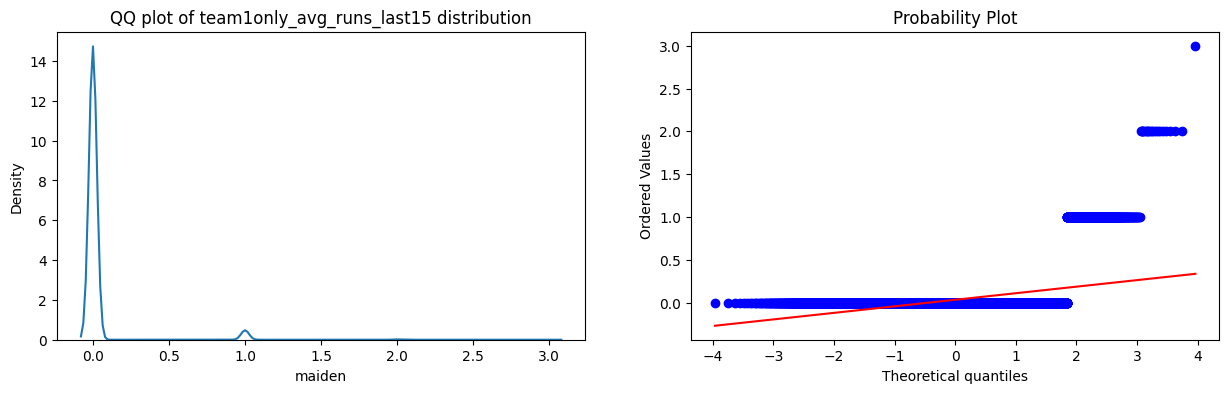

In [408]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,4))
ax1.set_title("maiden distribution")
sns.kdeplot(additional_data_bowler['maiden'],ax=ax1)
ax1.set_title("QQ plot of team1only_avg_runs_last15 distribution")
stats.probplot(additional_data_bowler['maiden'],plot=ax2)
# sns.kdeplot(x_transformed_df['ground_avg_runs_last15'],ax=ax1)


In [409]:
x_num=x[numerical_features]

### Plots before transformation

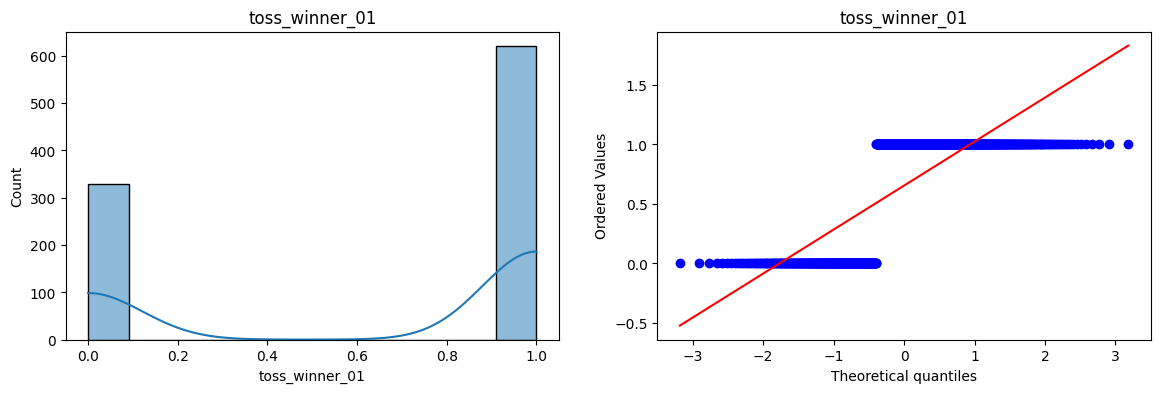

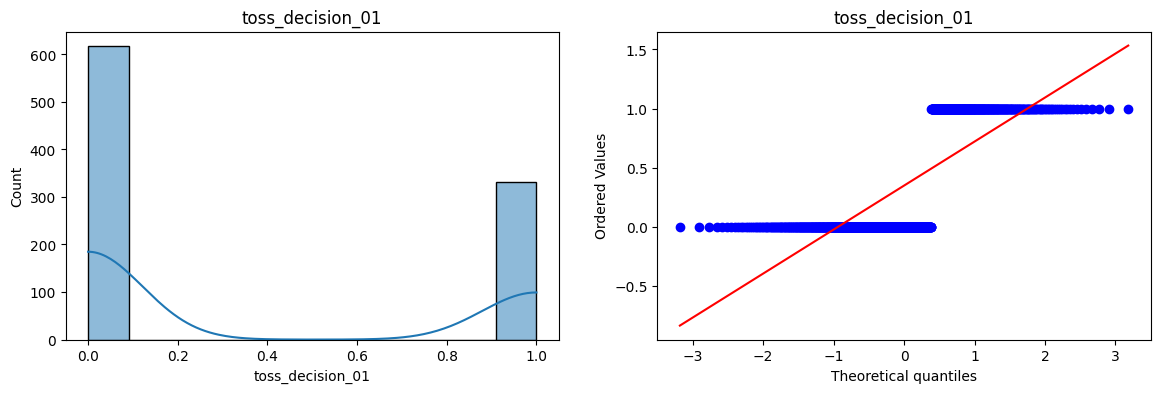

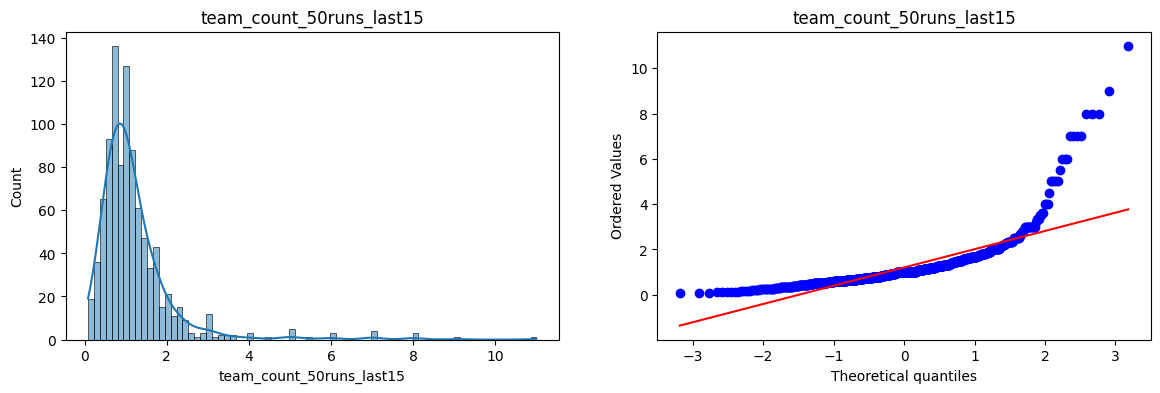

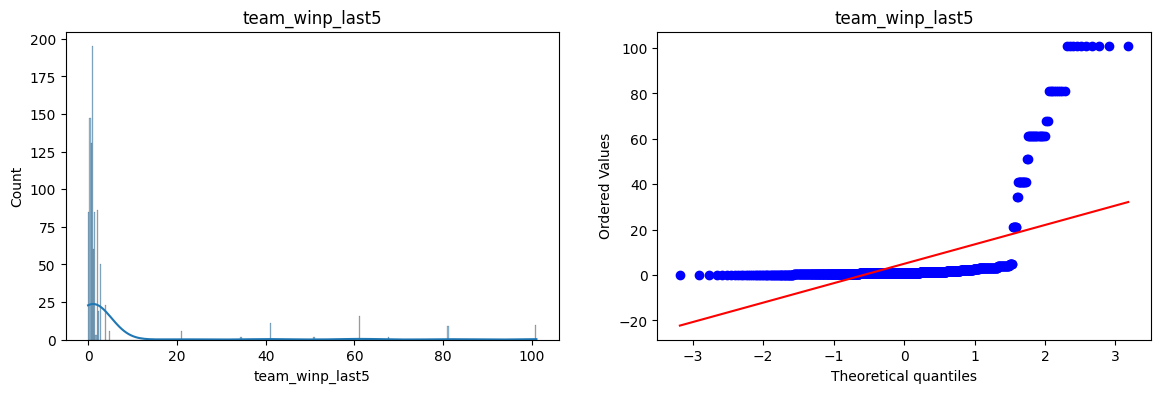

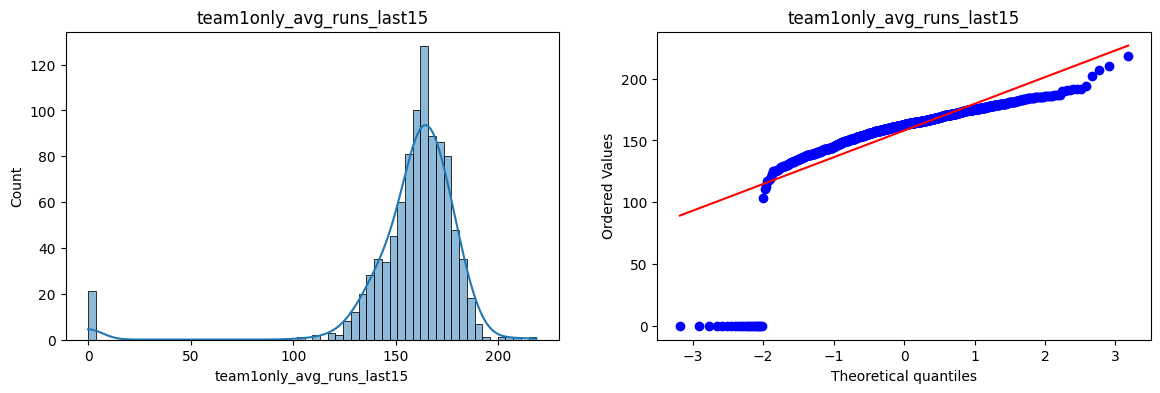

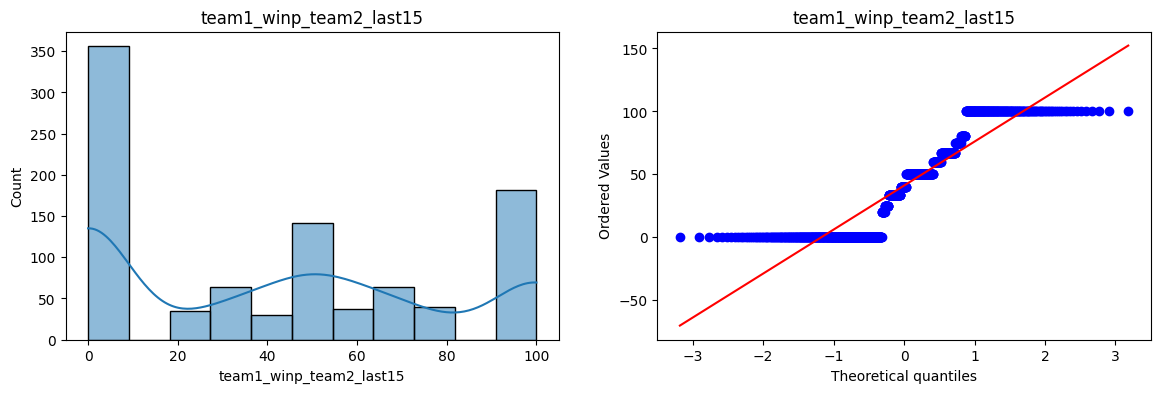

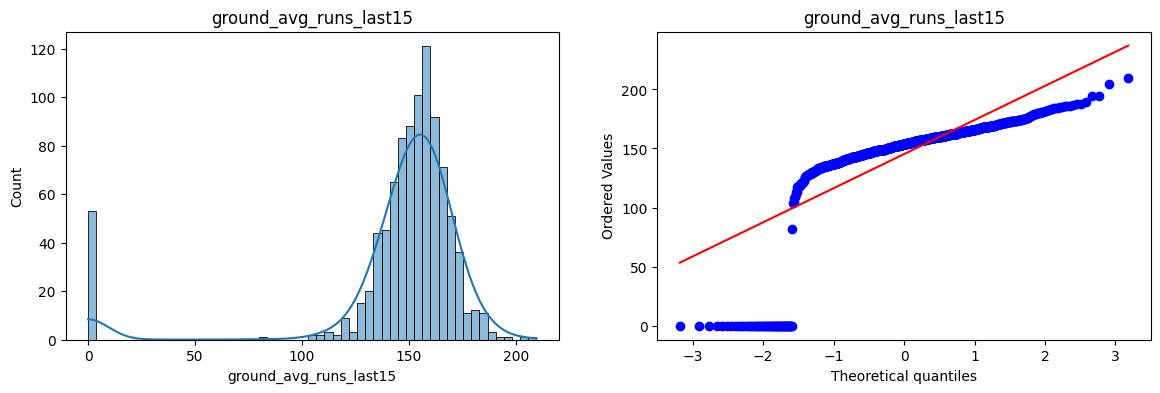

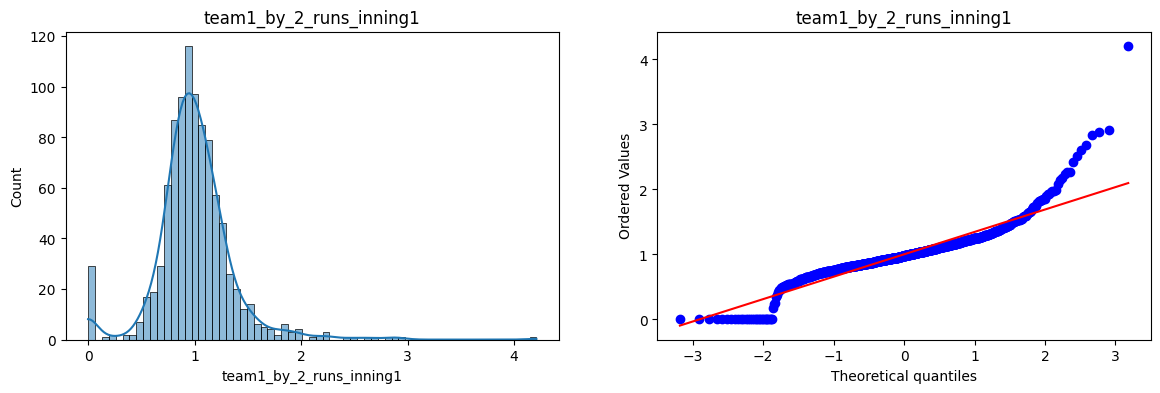

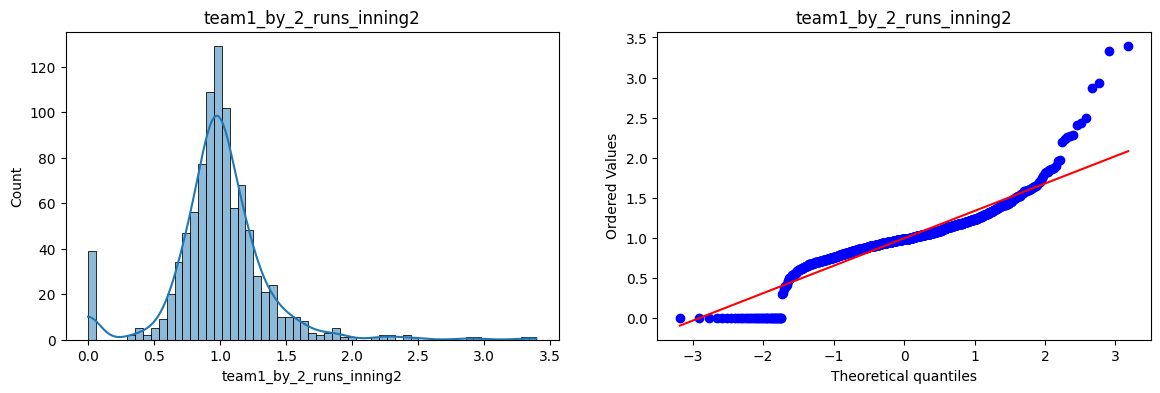

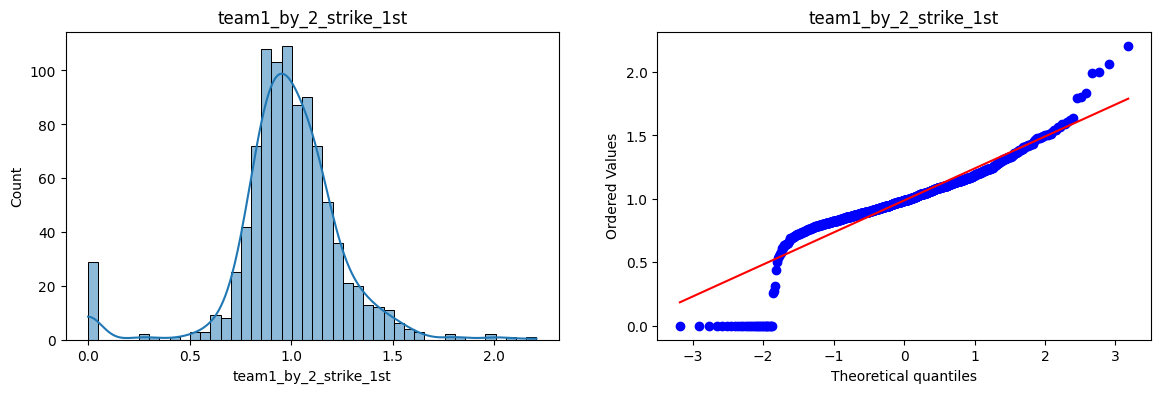

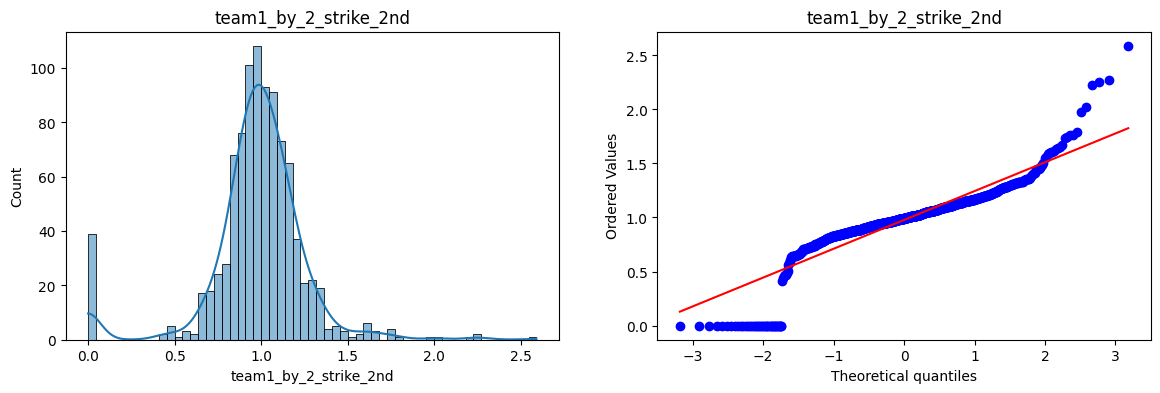

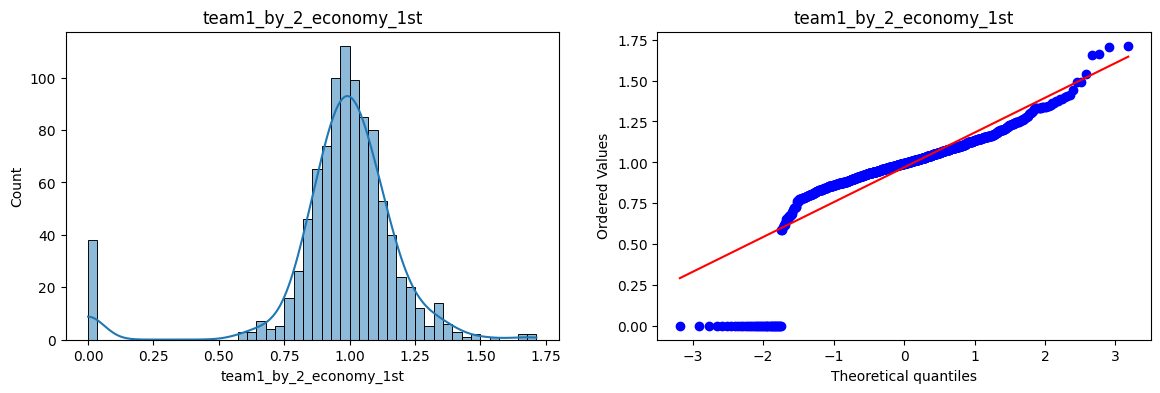

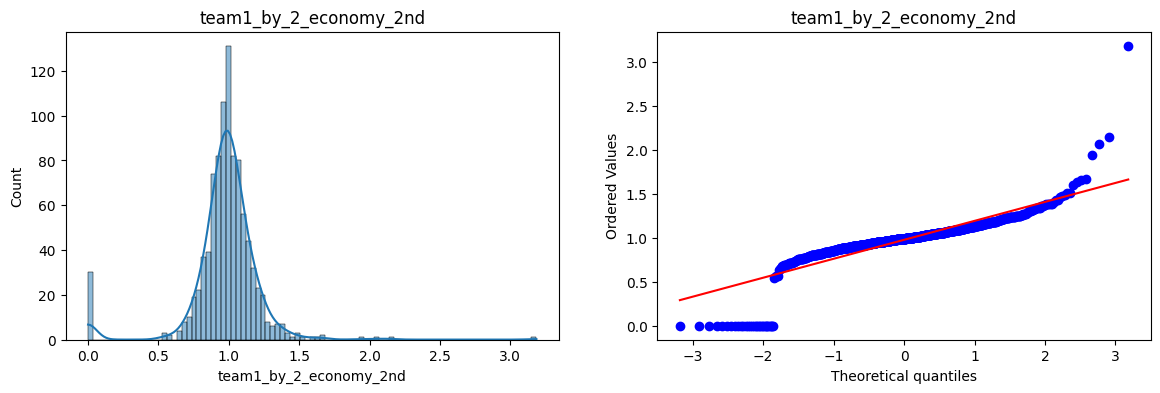

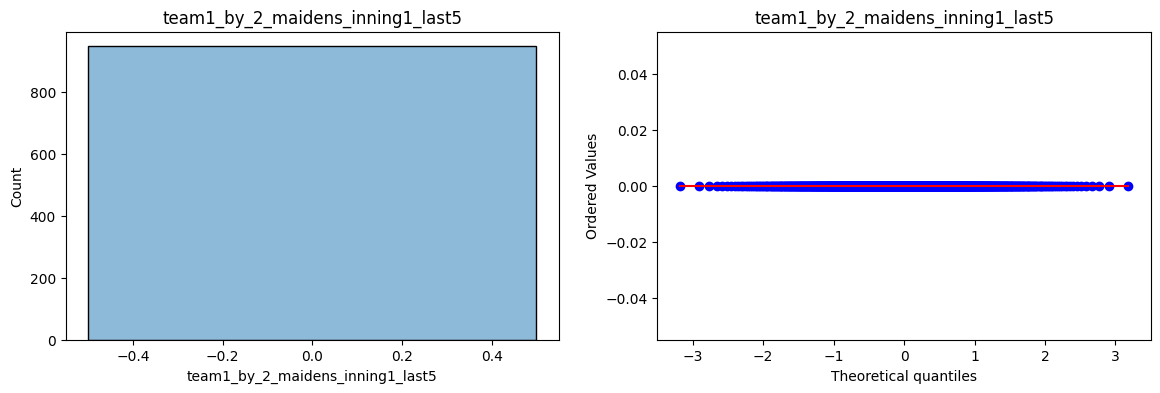

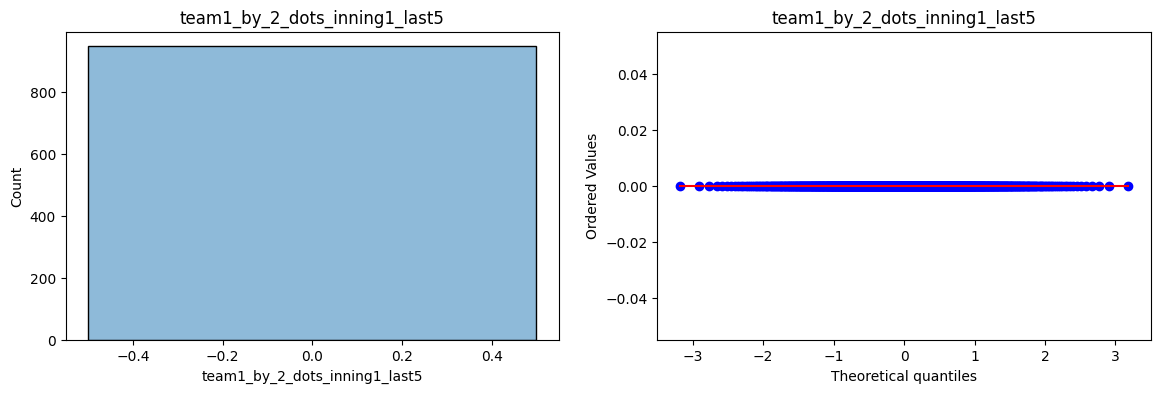

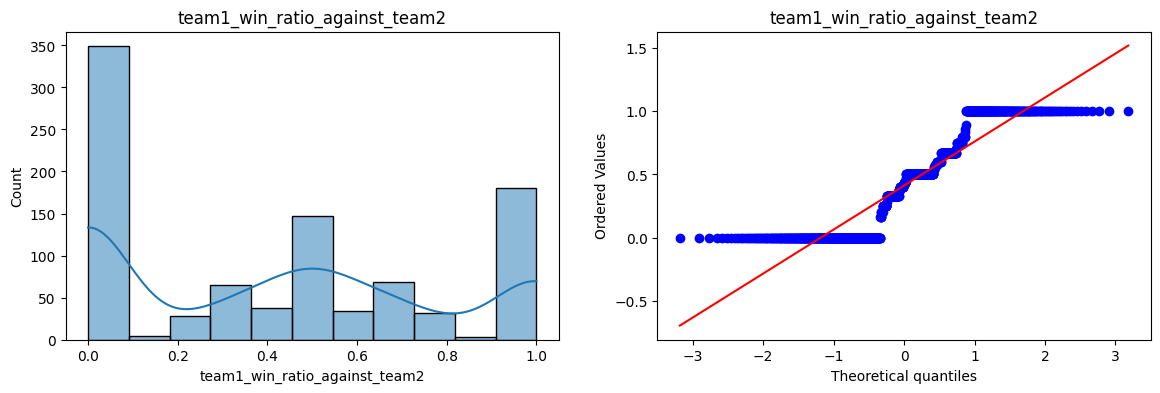

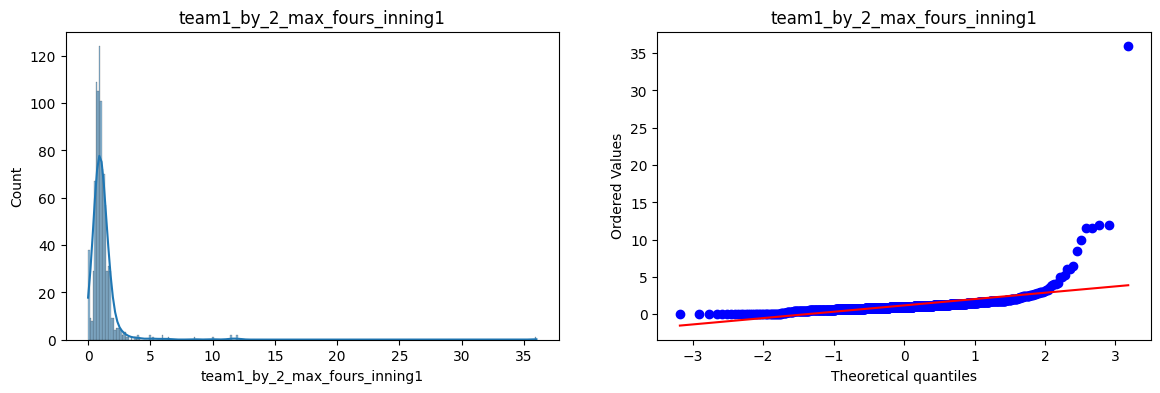

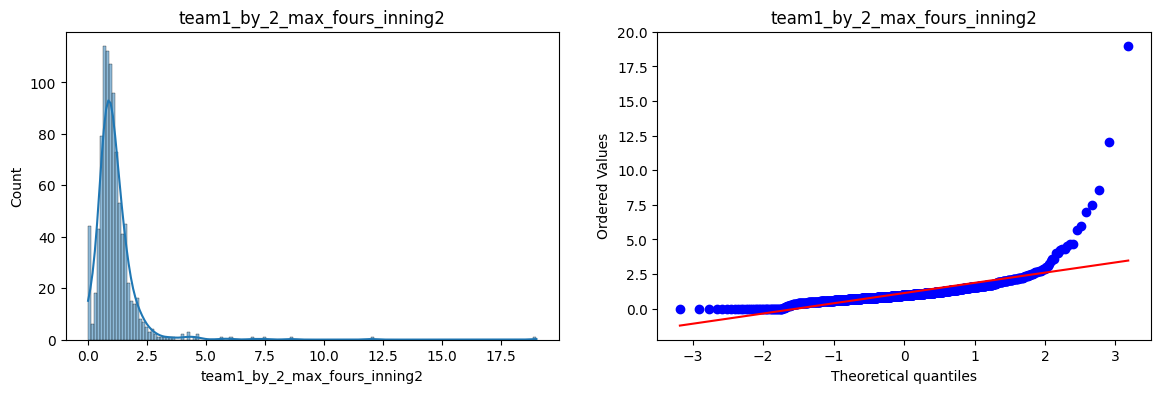

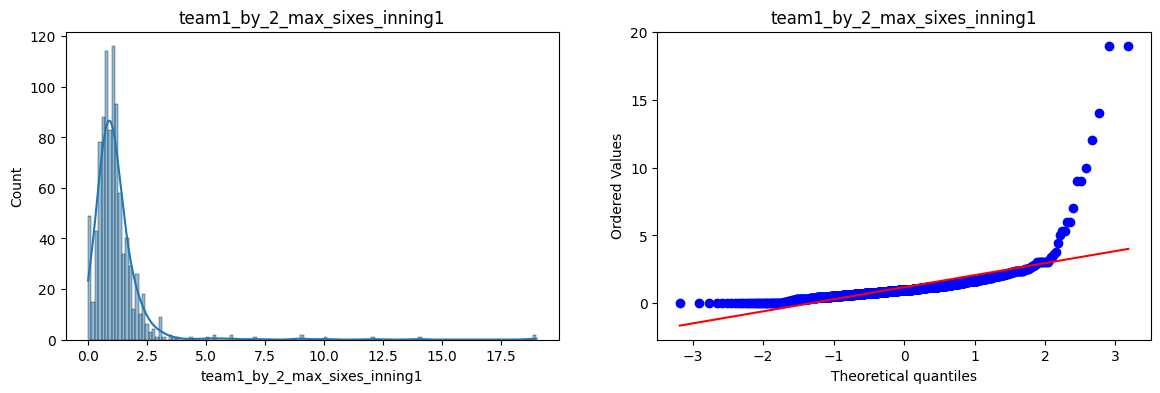

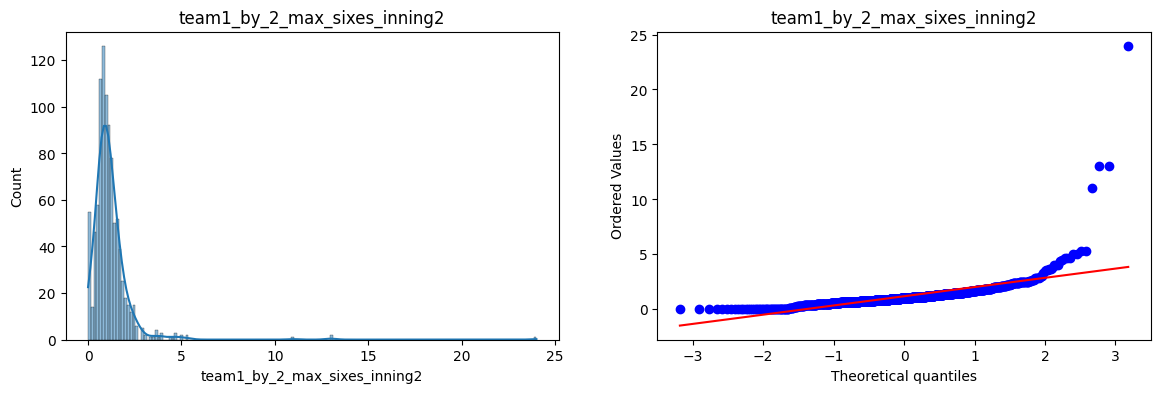

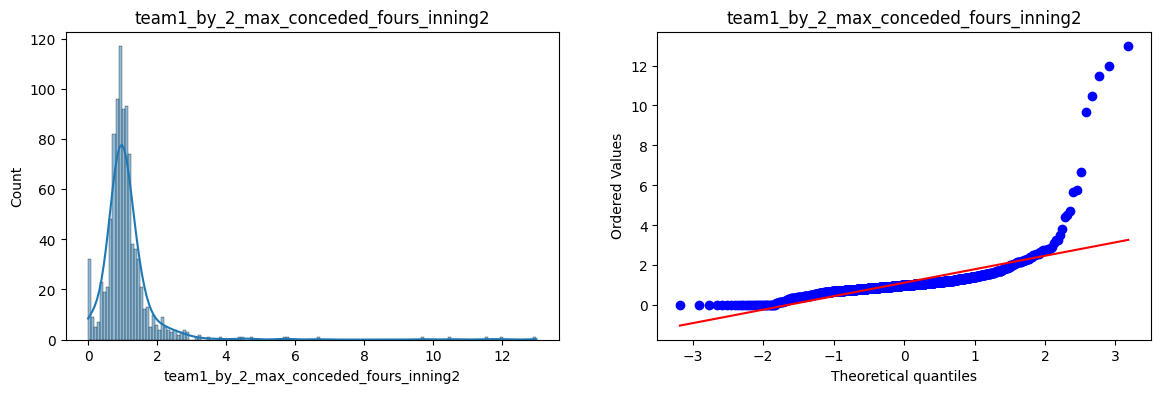

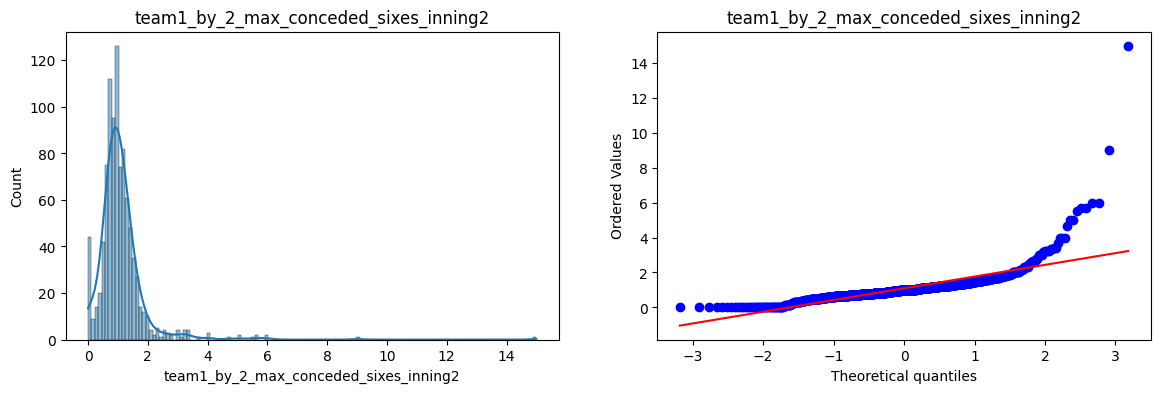

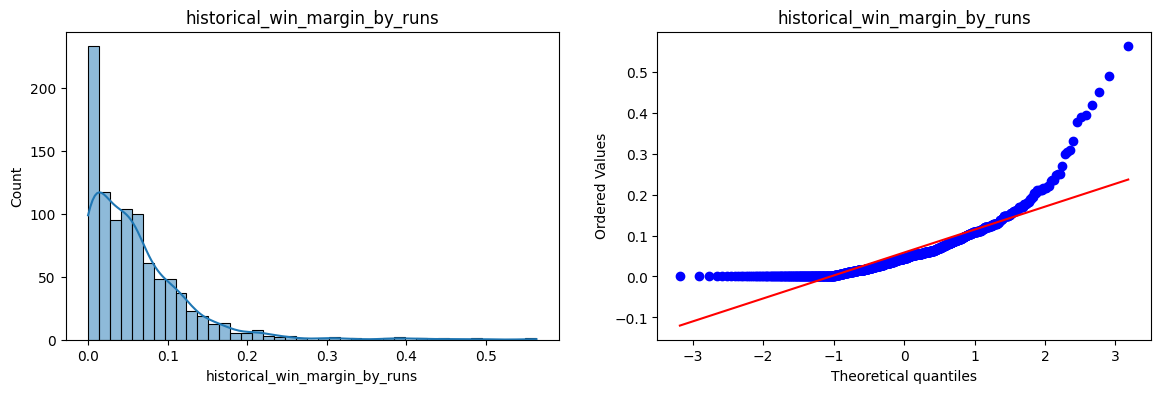

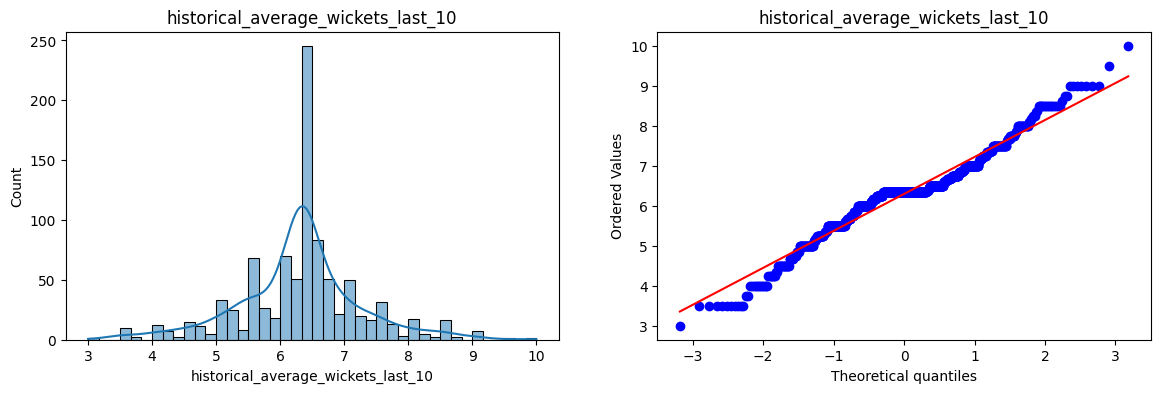

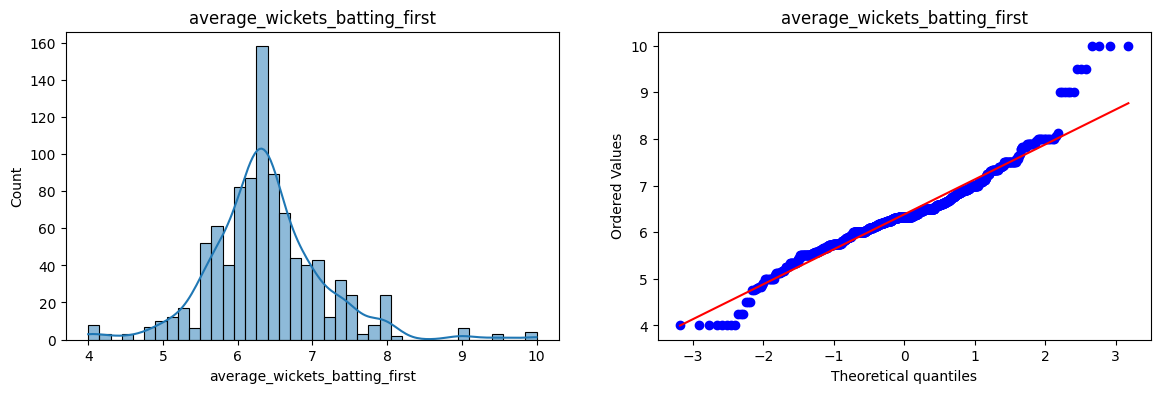

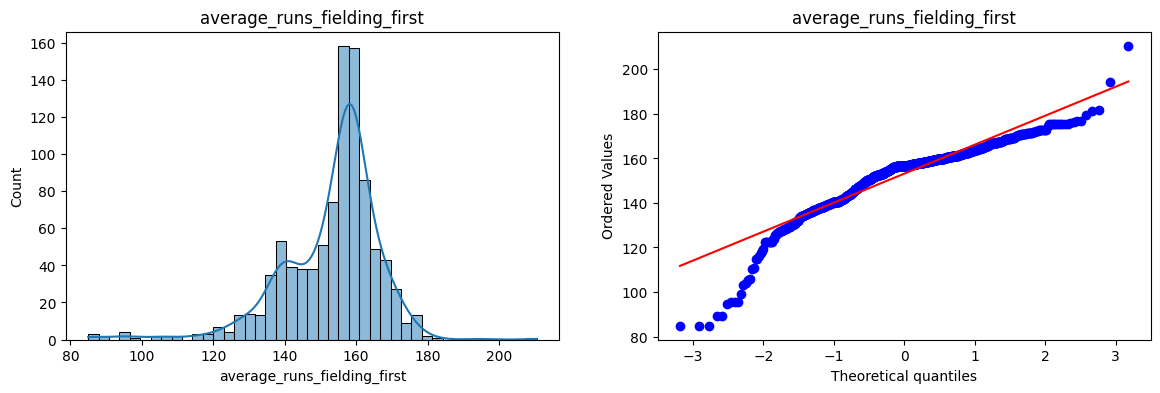

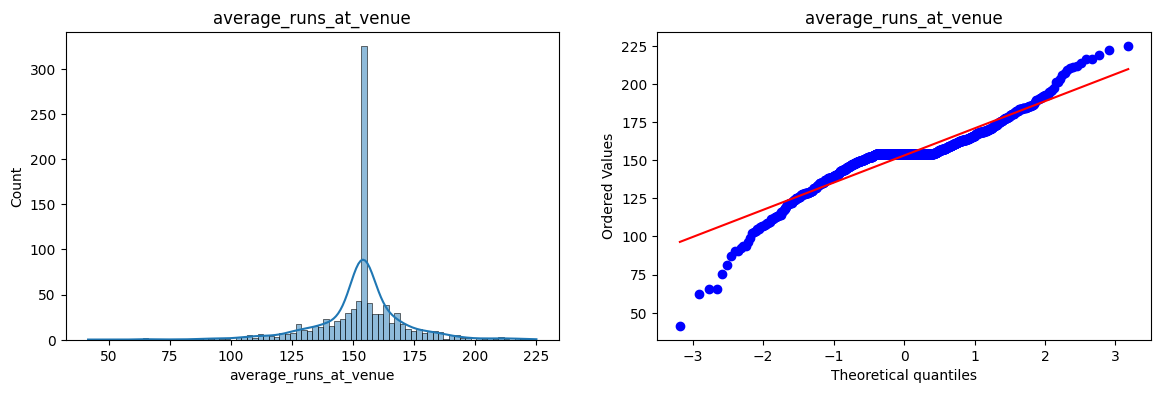

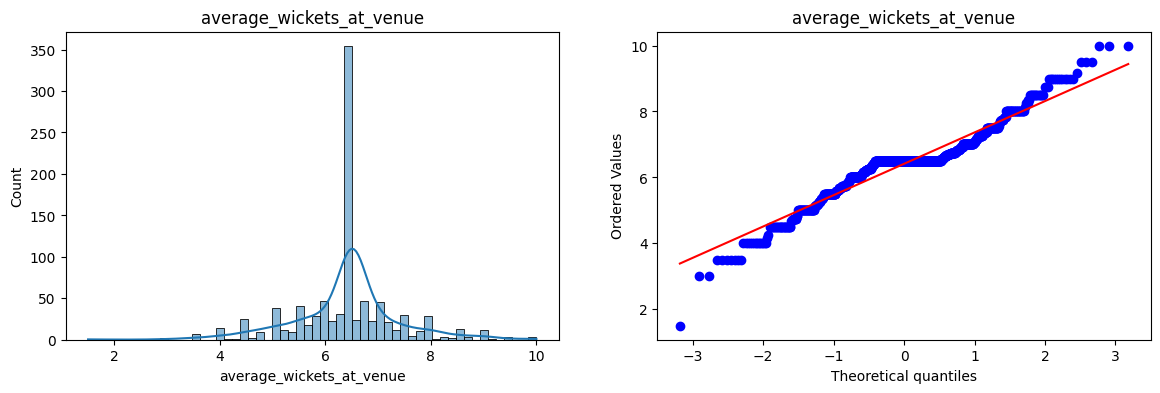

In [410]:
for col in x_num.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.histplot(x_num[col],kde=True)
    plt.title(col)

    plt.subplot(122)
    stats.probplot(x_num[col], dist="norm", plot=plt)
    plt.title(col)

    plt.show()

In [411]:
numerical_features

['toss_winner_01',
 'toss_decision_01',
 'team_count_50runs_last15',
 'team_winp_last5',
 'team1only_avg_runs_last15',
 'team1_winp_team2_last15',
 'ground_avg_runs_last15',
 'team1_by_2_runs_inning1',
 'team1_by_2_runs_inning2',
 'team1_by_2_strike_1st',
 'team1_by_2_strike_2nd',
 'team1_by_2_economy_1st',
 'team1_by_2_economy_2nd',
 'team1_by_2_maidens_inning1_last5',
 'team1_by_2_maidens_inning2_last5',
 'team1_by_2_dots_inning1_last5',
 'team1_by_2_dots_inning2_last5',
 'team1_win_ratio_against_team2',
 'team1_by_2_max_fours_inning1',
 'team1_by_2_max_fours_inning2',
 'team1_by_2_max_sixes_inning1',
 'team1_by_2_max_sixes_inning2',
 'team1_by_2_max_conceded_fours_inning1',
 'team1_by_2_max_conceded_fours_inning2',
 'team1_by_2_max_conceded_sixes_inning1',
 'team1_by_2_max_conceded_sixes_inning2',
 'historical_win_margin_by_runs',
 'historical_win_margin_by_wickets',
 'historical_average_runs_last_10',
 'historical_average_wickets_last_10',
 'average_runs_batting_first',
 'average_w

In [412]:
'team1_by_2_economy_1st' in x_transformed_df.columns

True

In [413]:
x_transformed_num=x_transformed_df[numerical_features]

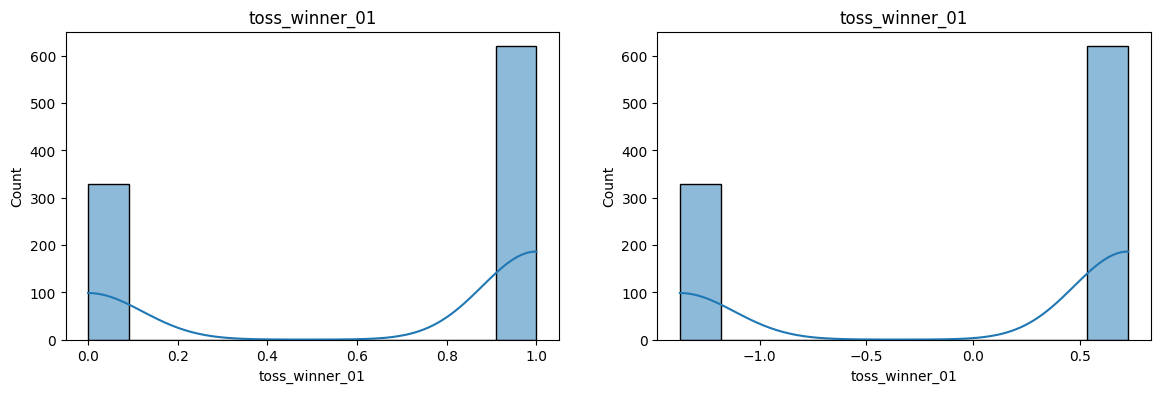

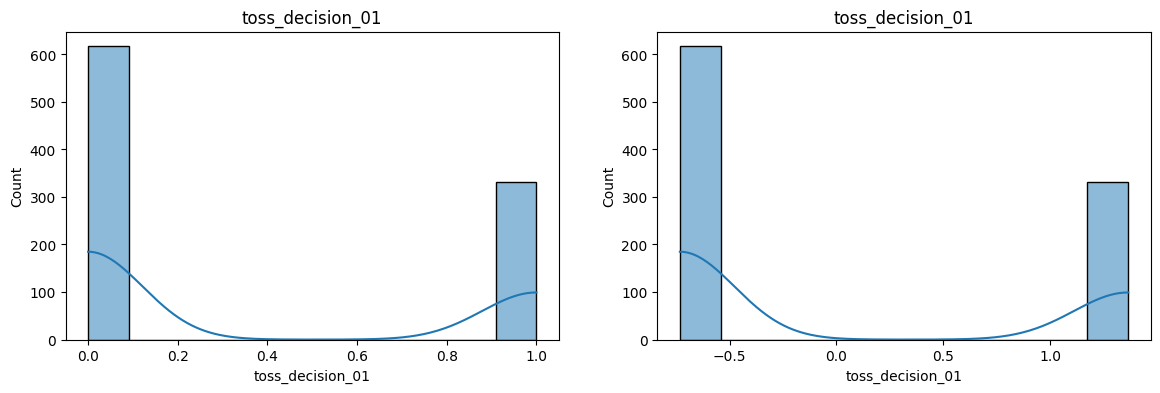

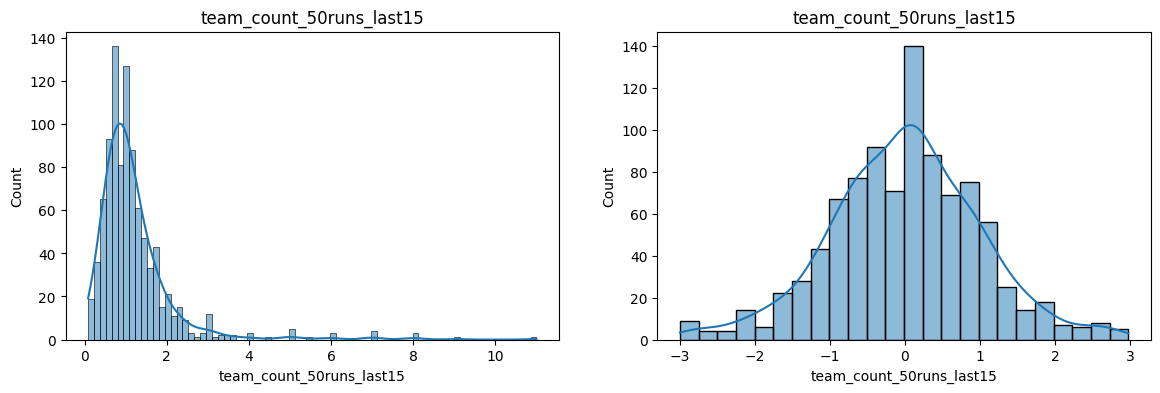

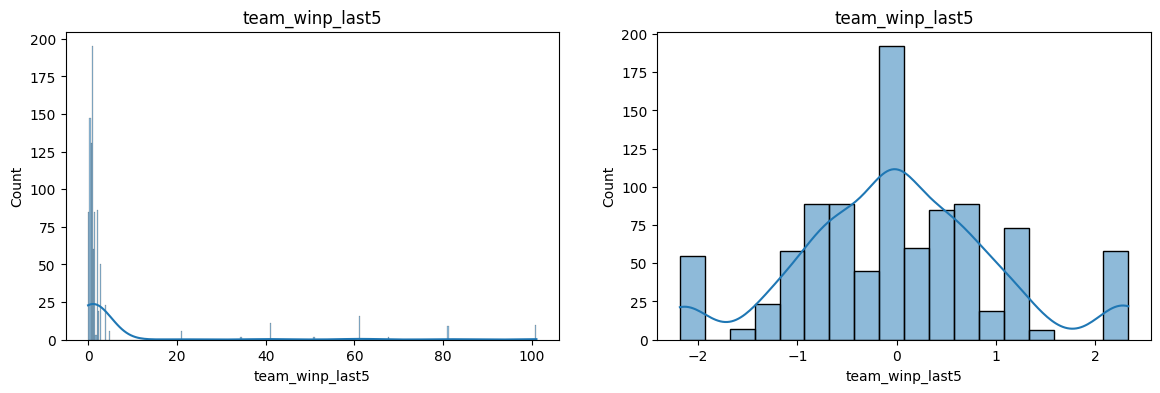

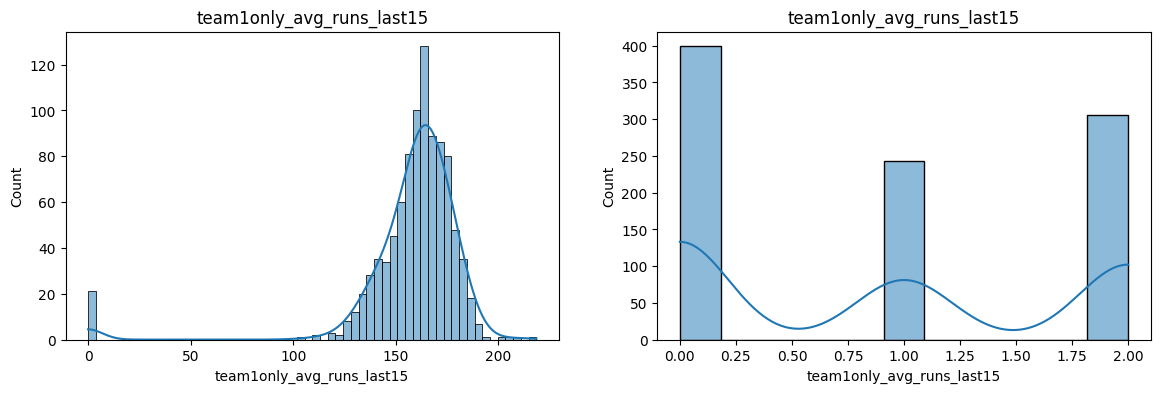

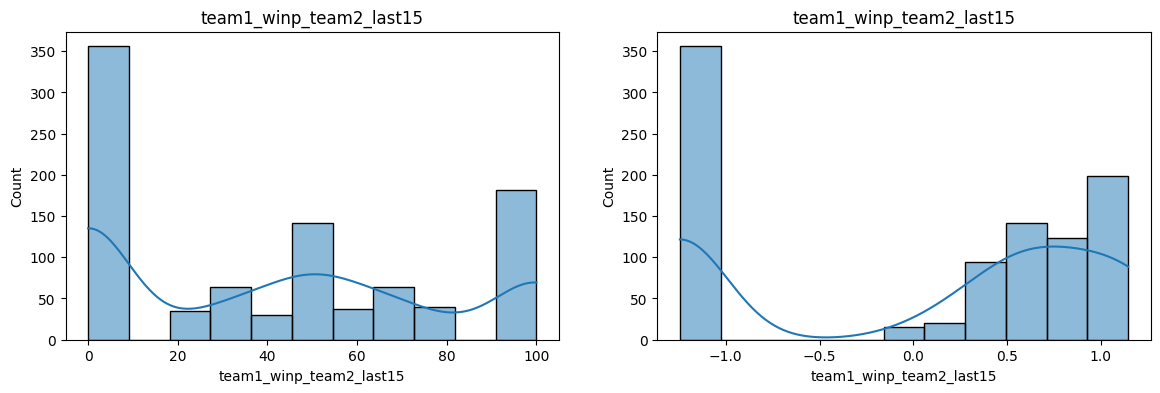

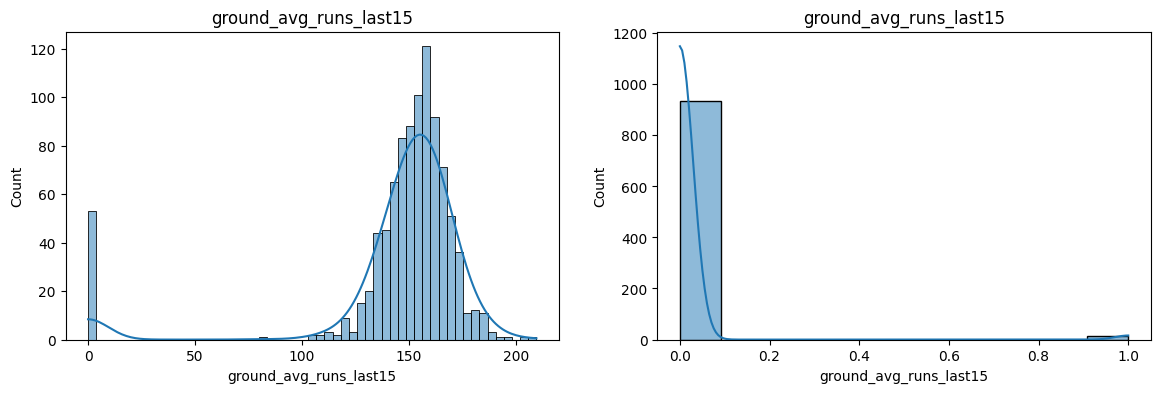

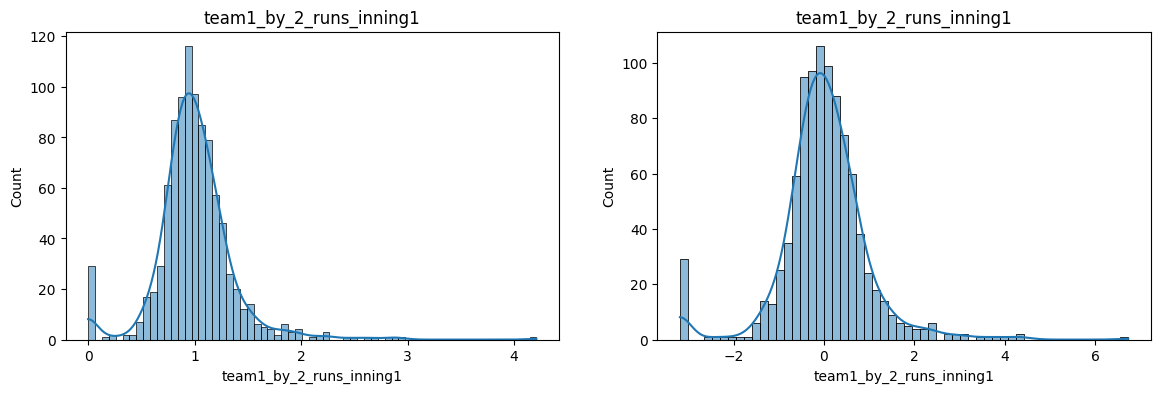

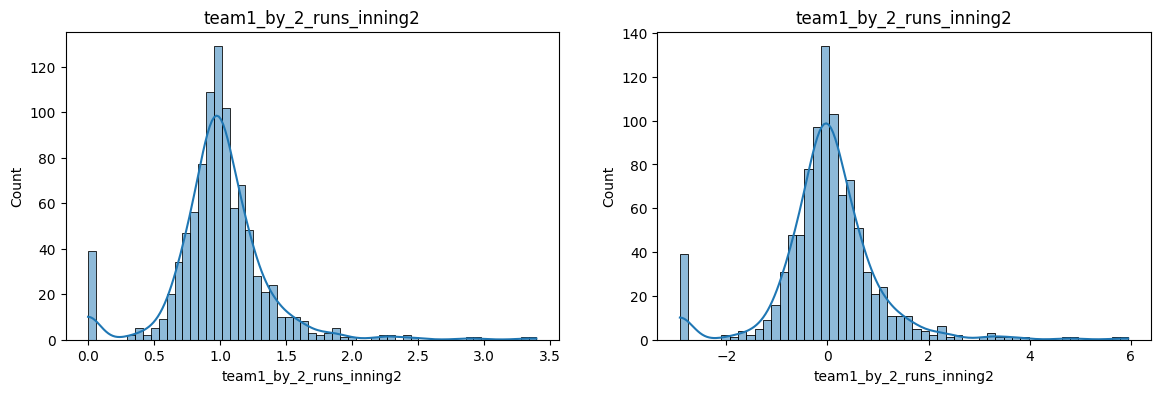

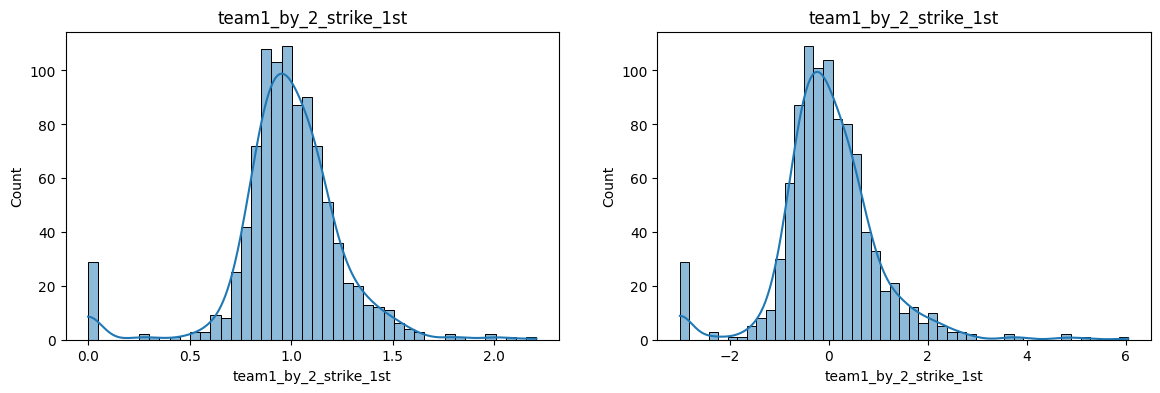

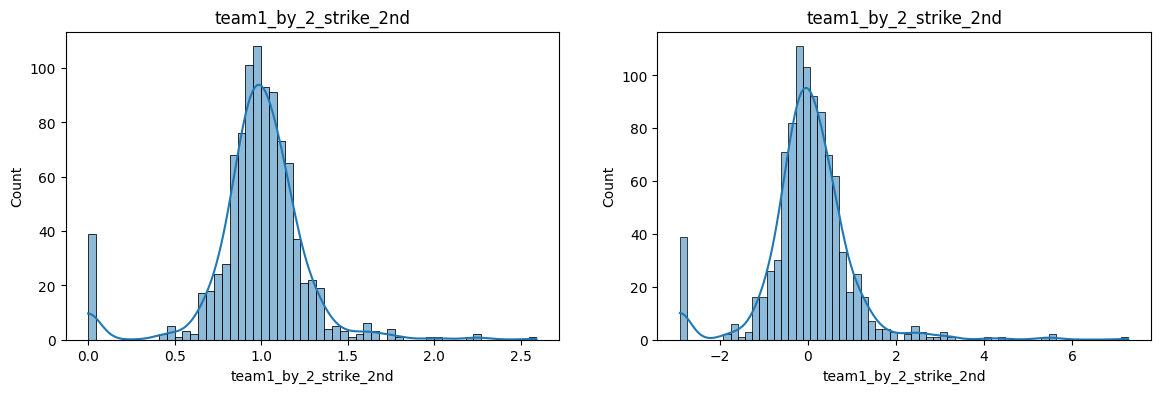

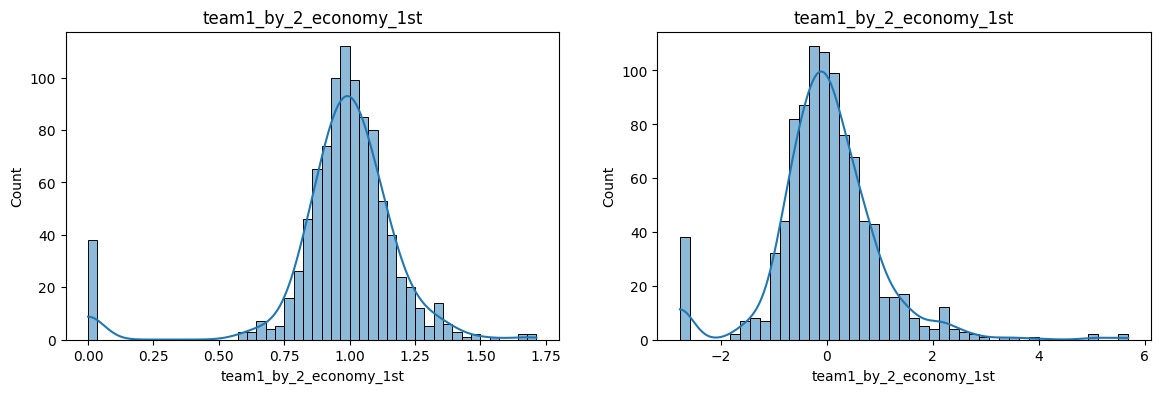

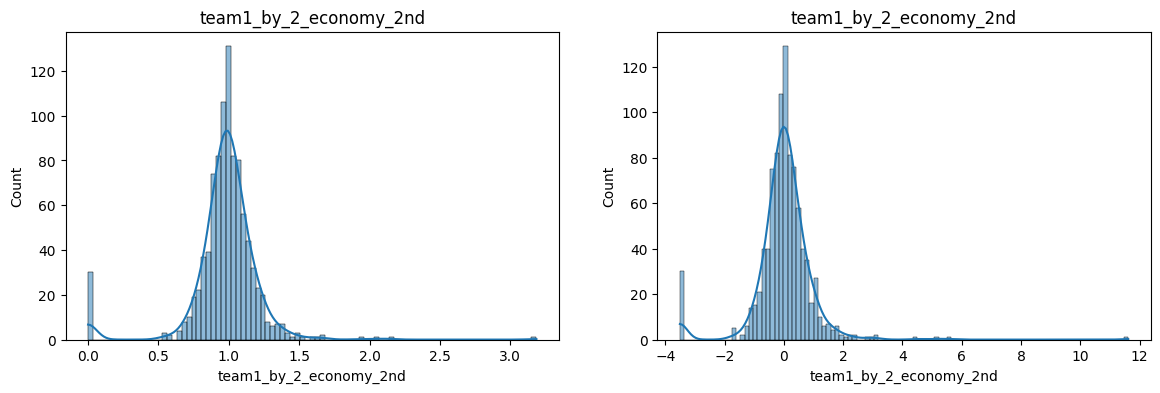

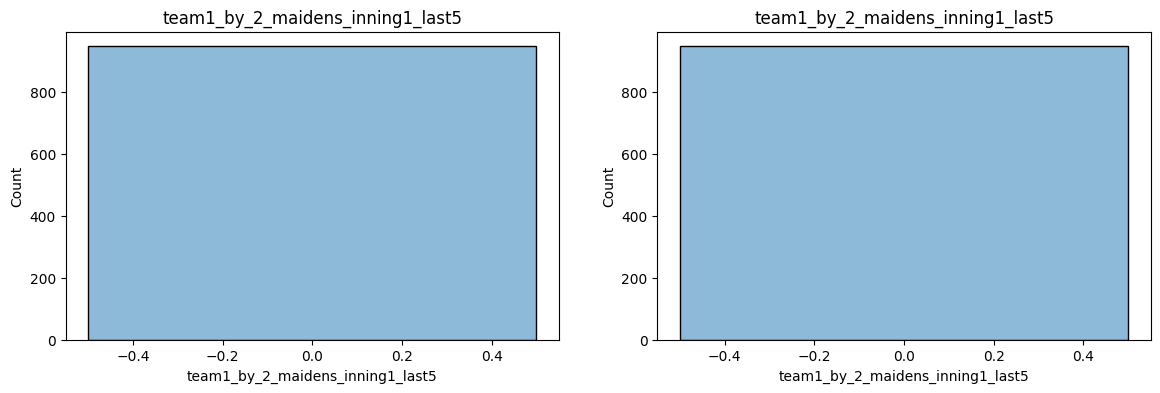

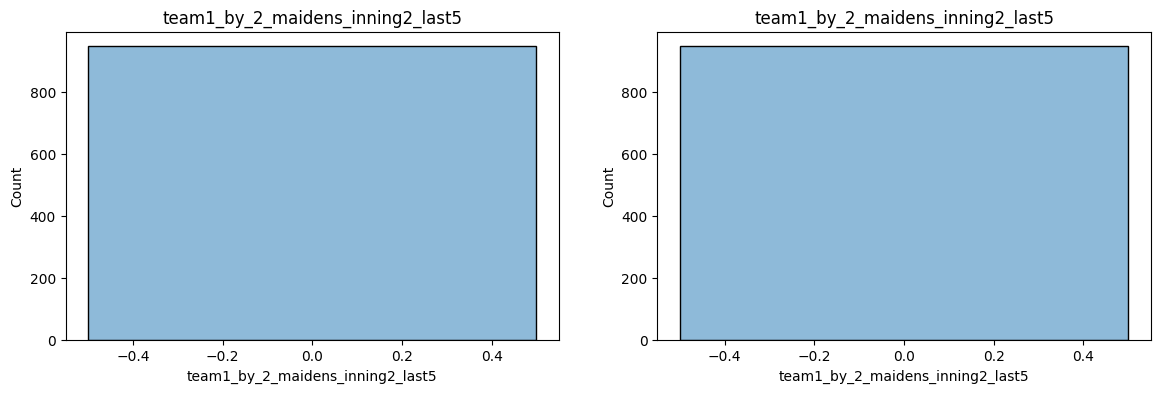

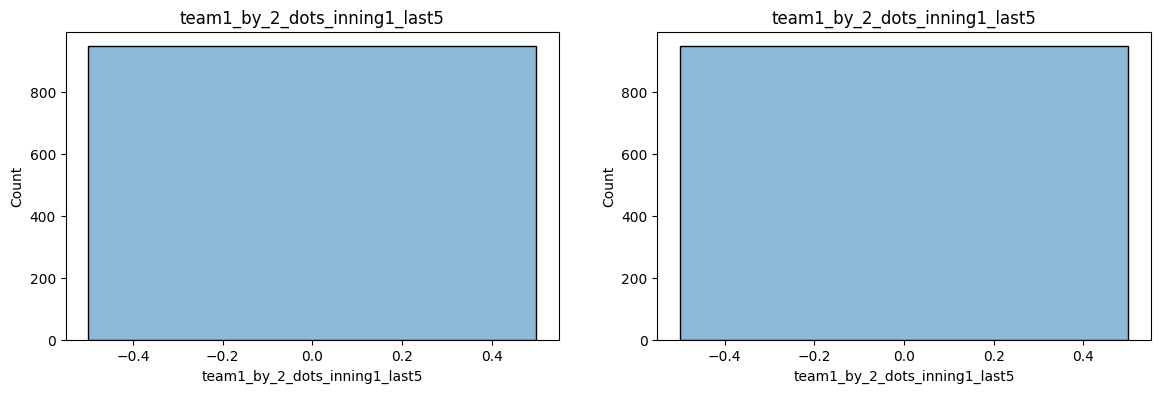

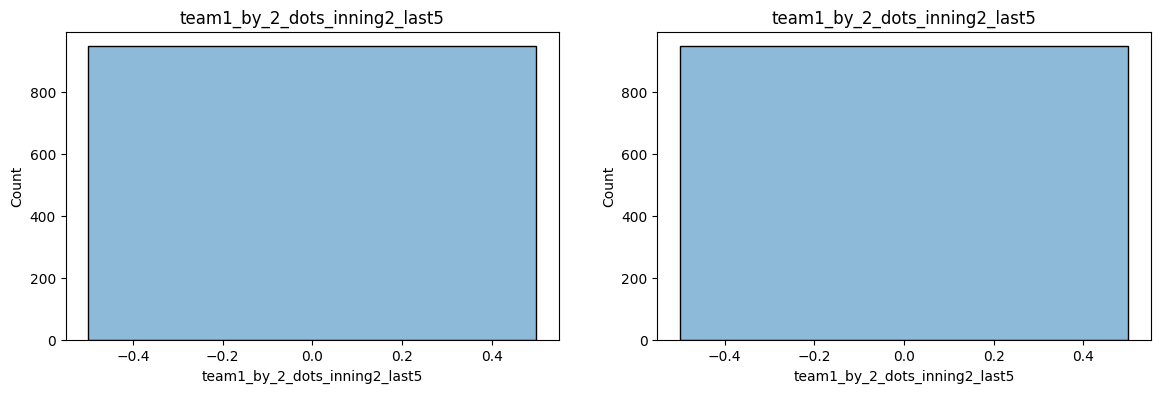

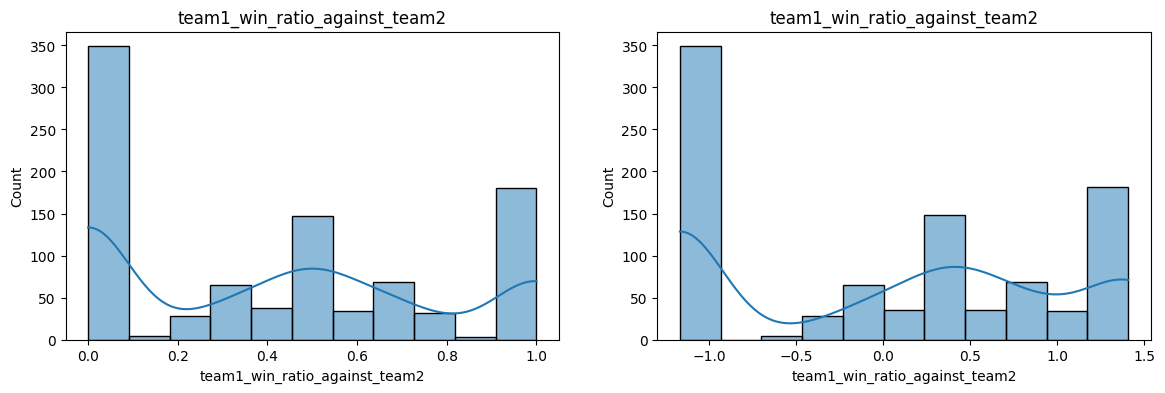

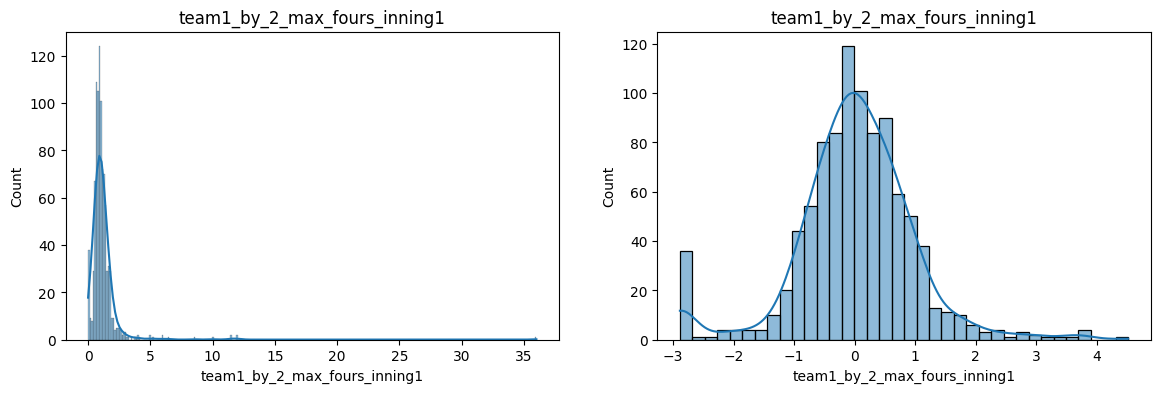

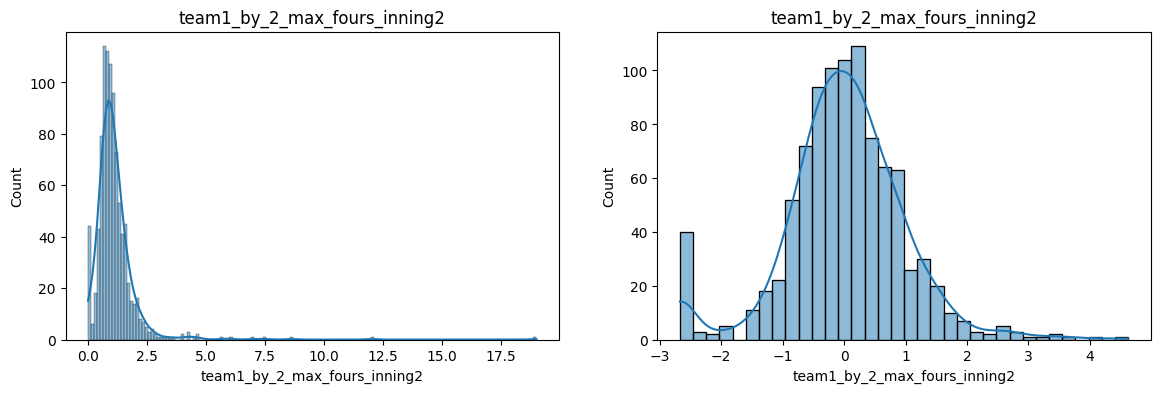

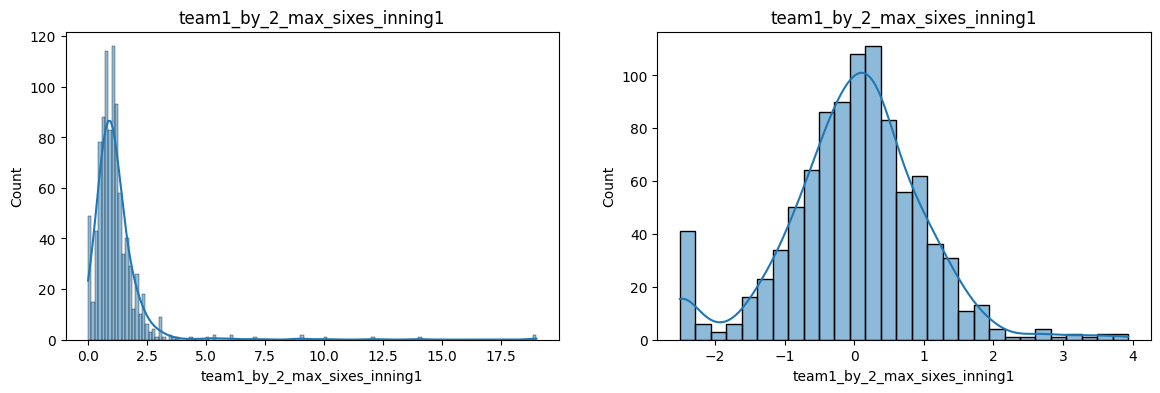

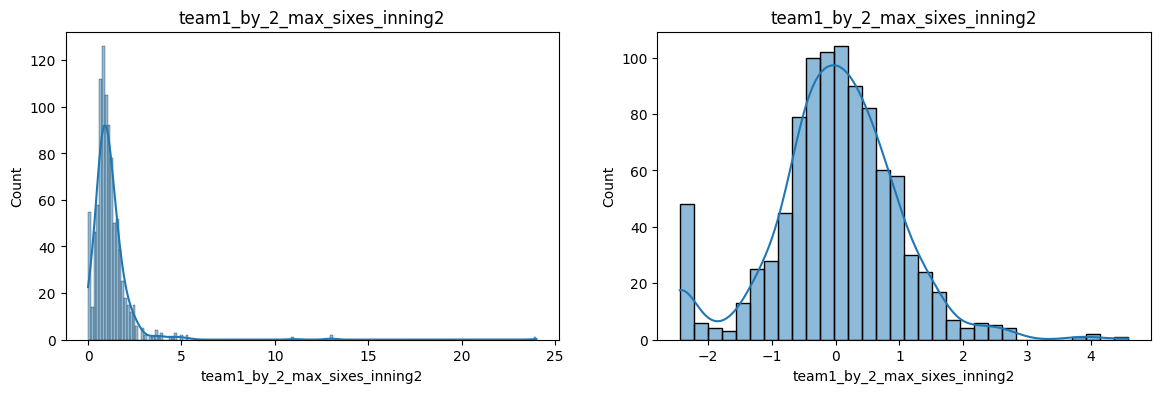

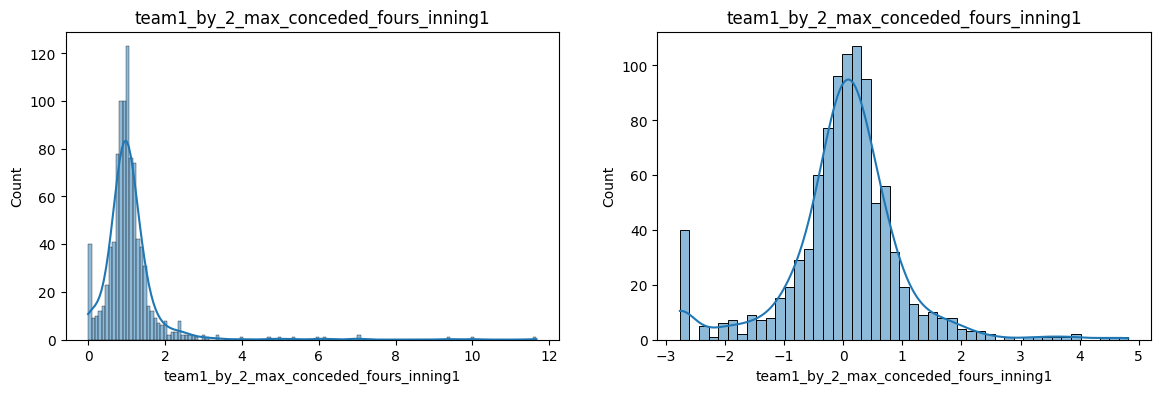

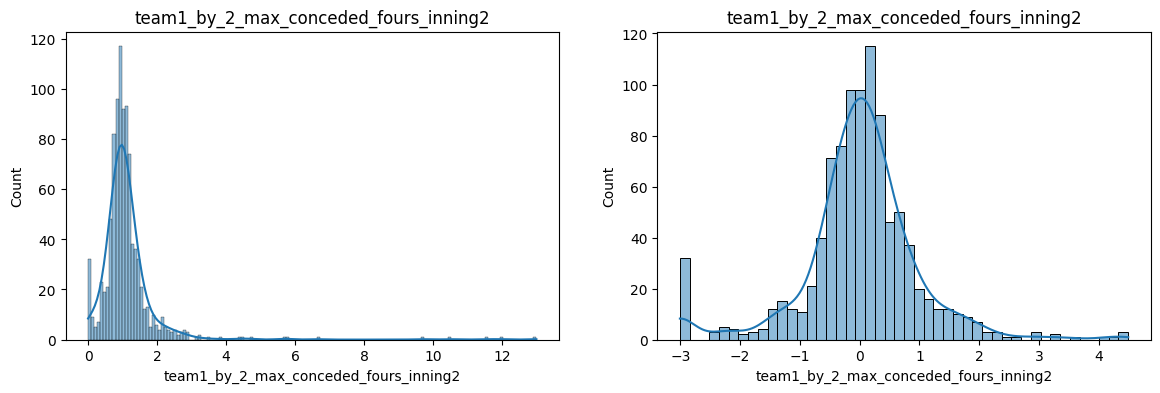

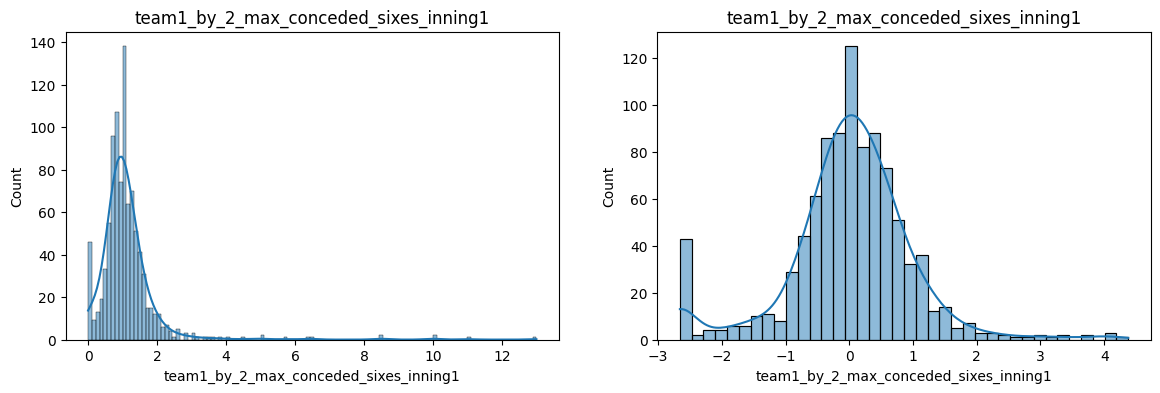

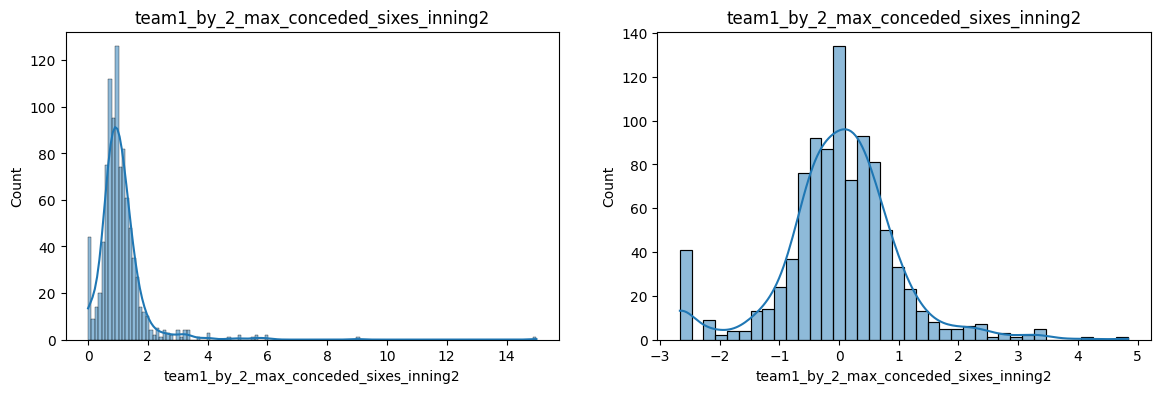

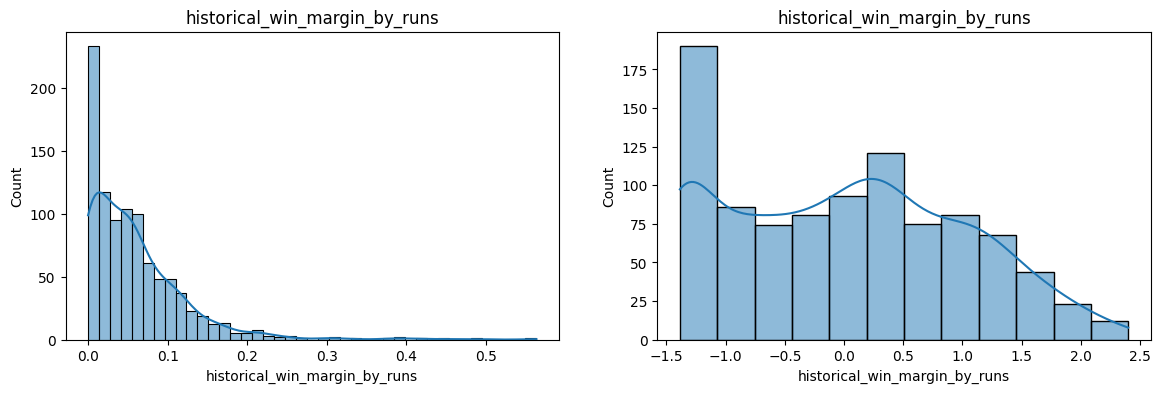

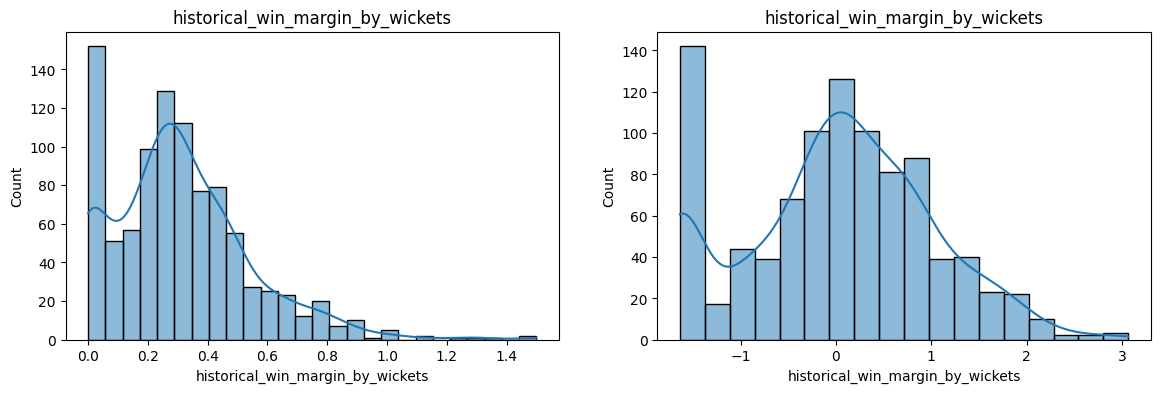

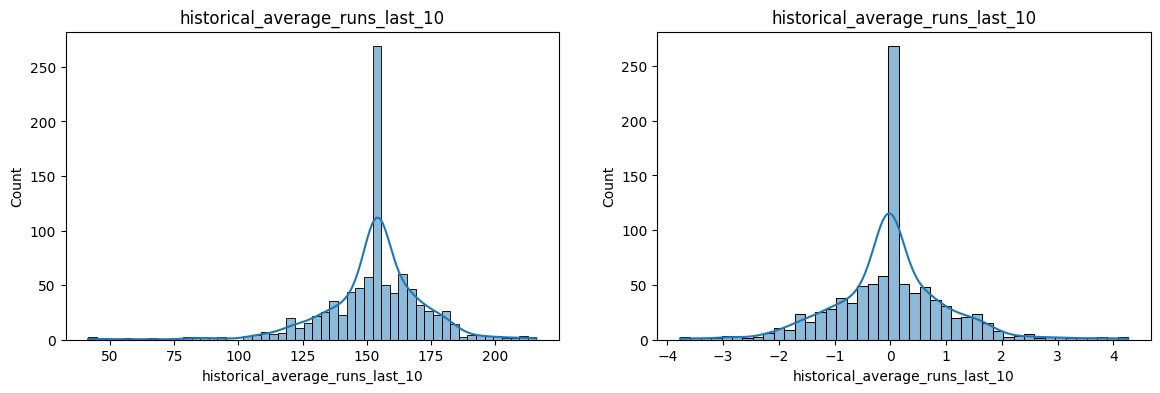

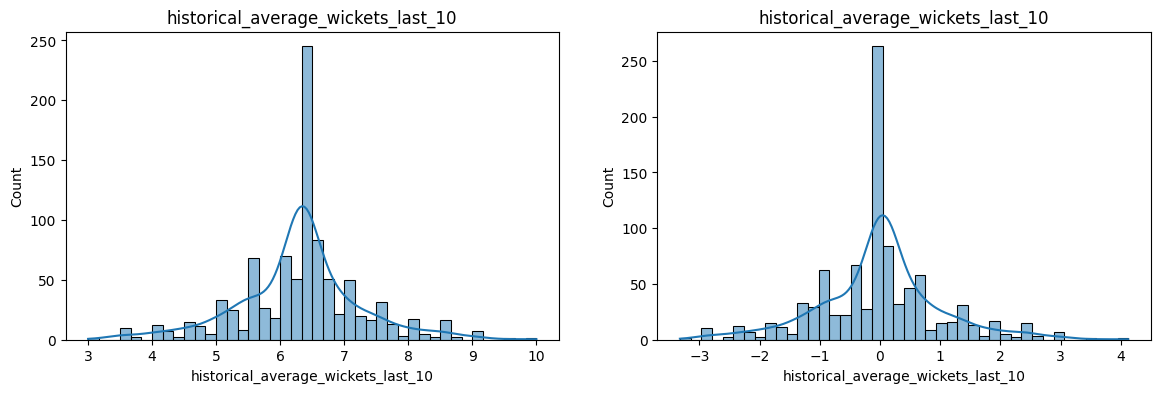

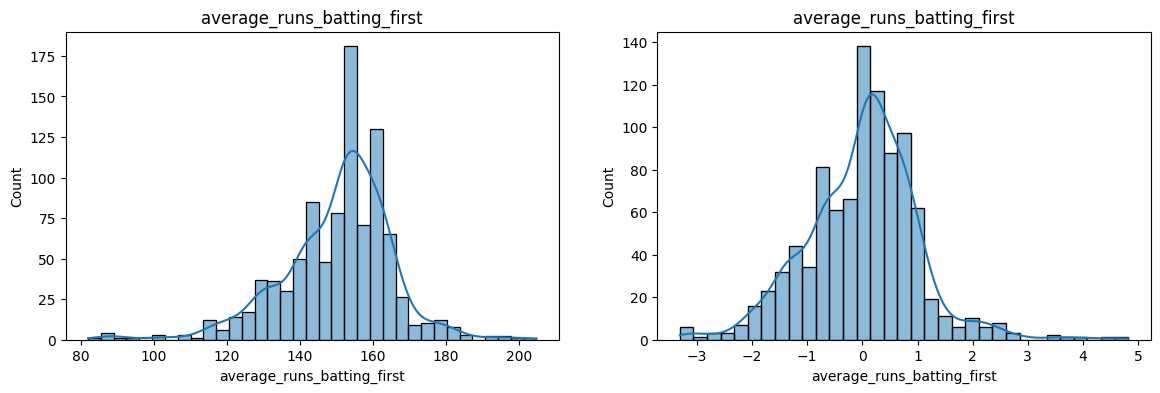

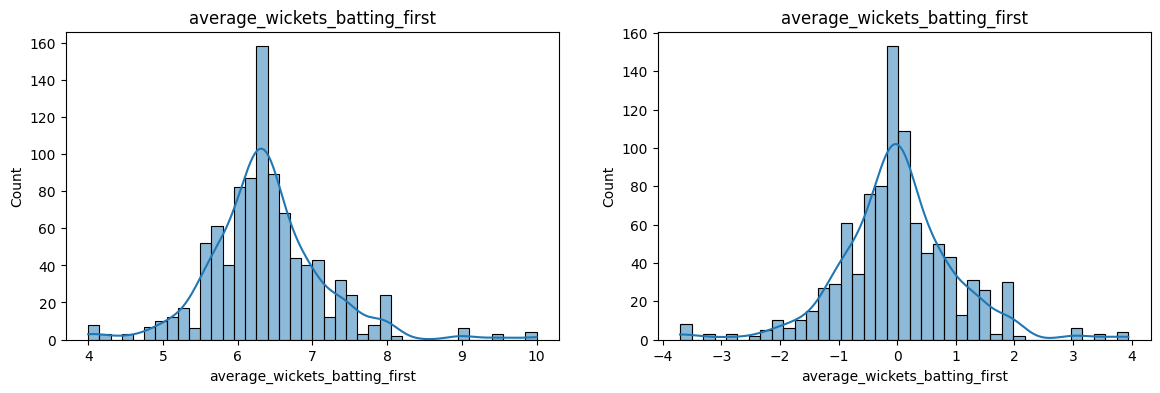

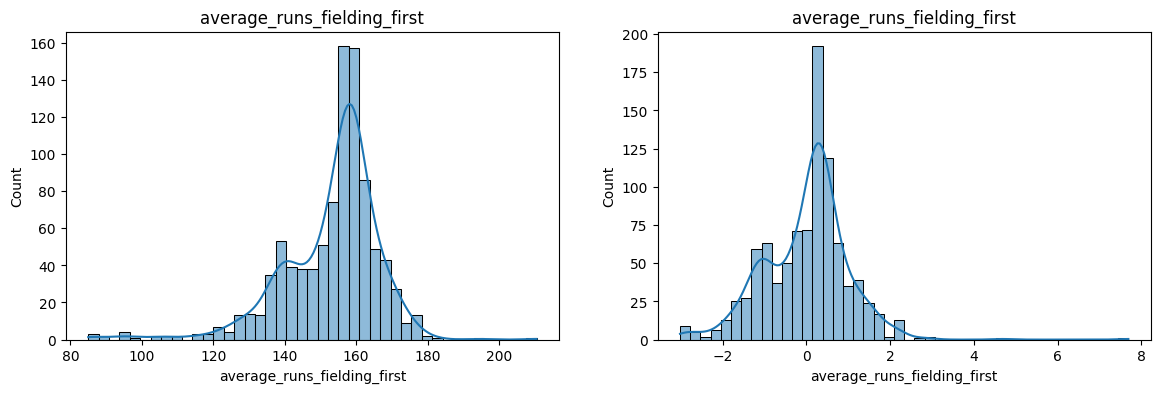

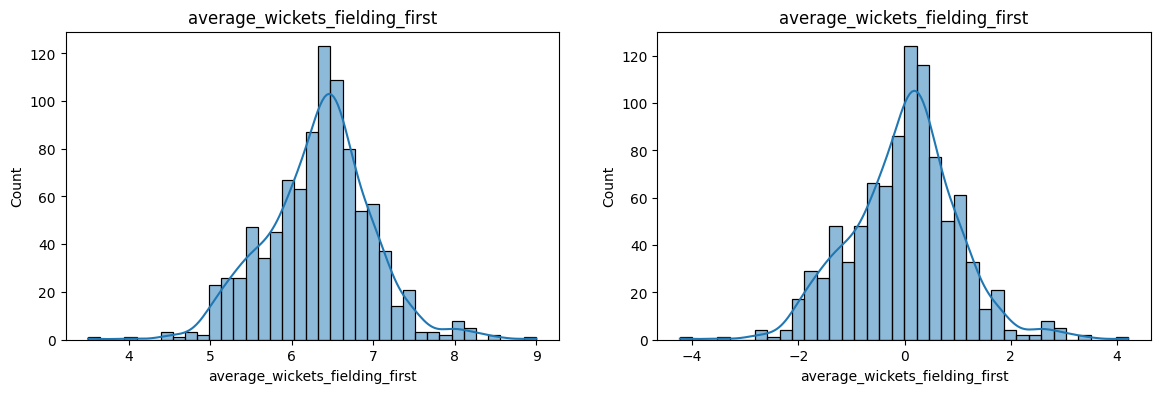

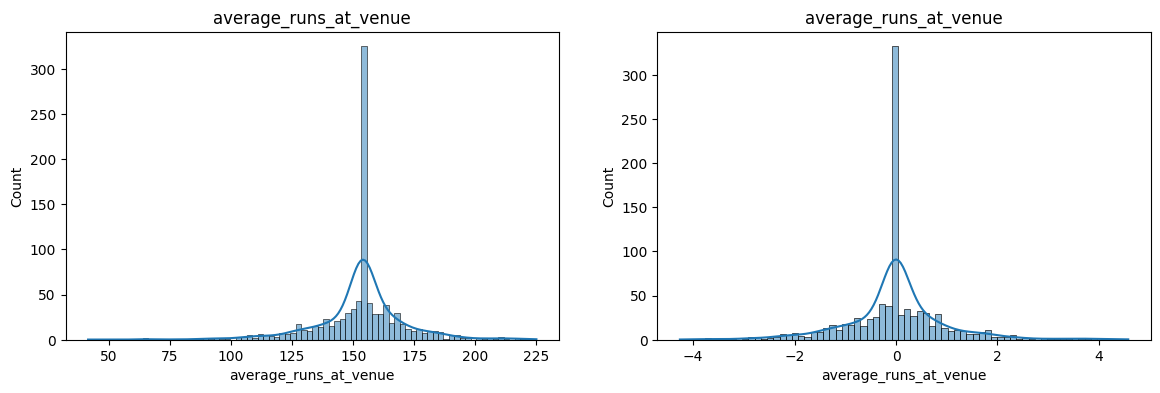

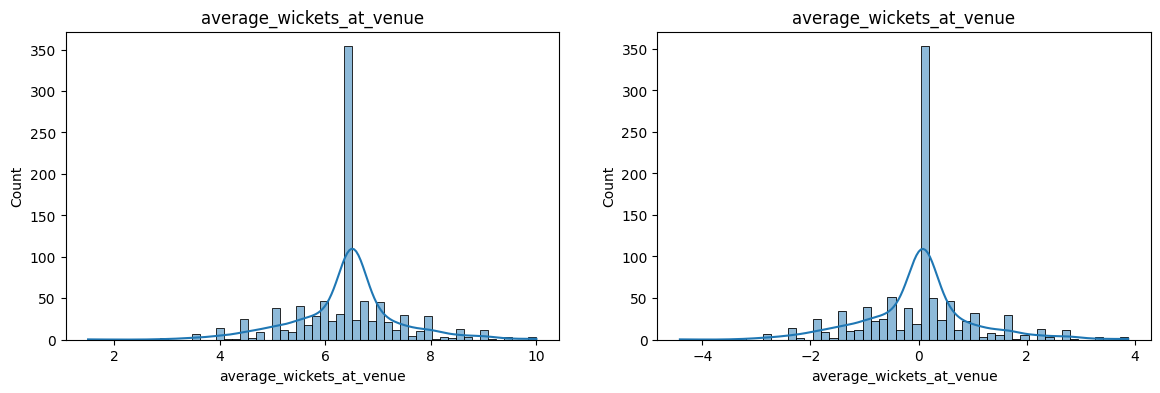

In [414]:
# Before and after comparision for Yeo-Johnson

for col in x_transformed_num.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    sns.histplot(x[col],kde=True)
    plt.title(col)

    plt.subplot(122)
    sns.histplot(x_transformed_num[col],kde=True)
    plt.title(col)

    plt.show()

In [415]:


# Check if the original and transformed DataFrames have the same columns
print("Original columns:", x.columns)
print("Transformed columns:", x_transformed_num.columns)


Original columns: Index(['toss_winner_01', 'toss_decision_01', 'team_count_50runs_last15',
       'team_winp_last5', 'team1only_avg_runs_last15',
       'team1_winp_team2_last15', 'ground_avg_runs_last15',
       'team1_by_2_runs_inning1', 'team1_by_2_runs_inning2',
       'team1_by_2_strike_1st', 'team1_by_2_strike_2nd',
       'team1_by_2_economy_1st', 'team1_by_2_economy_2nd',
       'team1_by_2_maidens_inning1_last5', 'team1_by_2_maidens_inning2_last5',
       'team1_by_2_dots_inning1_last5', 'team1_by_2_dots_inning2_last5',
       'team1_win_ratio_against_team2', 'team1_by_2_max_fours_inning1',
       'team1_by_2_max_fours_inning2', 'team1_by_2_max_sixes_inning1',
       'team1_by_2_max_sixes_inning2', 'team1_by_2_max_conceded_fours_inning1',
       'team1_by_2_max_conceded_fours_inning2',
       'team1_by_2_max_conceded_sixes_inning1',
       'team1_by_2_max_conceded_sixes_inning2',
       'historical_win_margin_by_runs', 'historical_win_margin_by_wickets',
       'historical_ave

In [416]:
x_transformed_num['toss_winner_01']

0      0.727346
1     -1.374861
2     -1.374861
3      0.727346
4      0.727346
         ...   
943    0.727346
944   -1.374861
945    0.727346
946   -1.374861
947   -1.374861
Name: toss_winner_01, Length: 948, dtype: float64

((array([-3.18216179e+00, -2.91576188e+00, -2.76702137e+00, -2.66207760e+00,
         -2.58017975e+00, -2.51262152e+00, -2.45489243e+00, -2.40434291e+00,
         -2.35927947e+00, -2.31855176e+00, -2.28134151e+00, -2.24704520e+00,
         -2.21520450e+00, -2.18546289e+00, -2.15753740e+00, -2.13119951e+00,
         -2.10626198e+00, -2.08256936e+00, -2.05999114e+00, -2.03841668e+00,
         -2.01775127e+00, -1.99791325e+00, -1.97883170e+00, -1.96044457e+00,
         -1.94269729e+00, -1.92554161e+00, -1.90893460e+00, -1.89283796e+00,
         -1.87721732e+00, -1.86204174e+00, -1.84728325e+00, -1.83291648e+00,
         -1.81891837e+00, -1.80526785e+00, -1.79194566e+00, -1.77893412e+00,
         -1.76621697e+00, -1.75377920e+00, -1.74160697e+00, -1.72968744e+00,
         -1.71800871e+00, -1.70655971e+00, -1.69533013e+00, -1.68431036e+00,
         -1.67349141e+00, -1.66286486e+00, -1.65242284e+00, -1.64215795e+00,
         -1.63206323e+00, -1.62213213e+00, -1.61235849e+00, -1.60273648e+00,

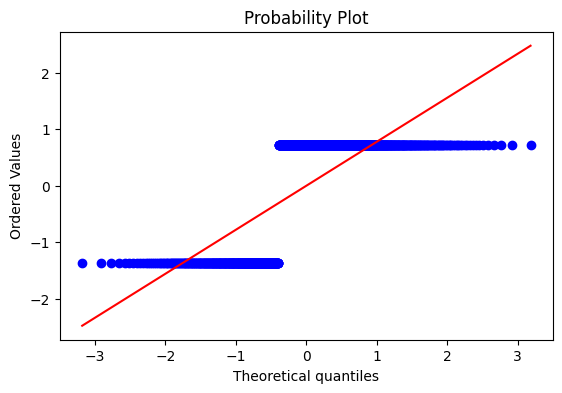

In [417]:
plt.figure(figsize=(14,4))
plt.subplot(121)
stats.probplot(x_transformed_num['toss_winner_01'],dist='norm',plot=plt)

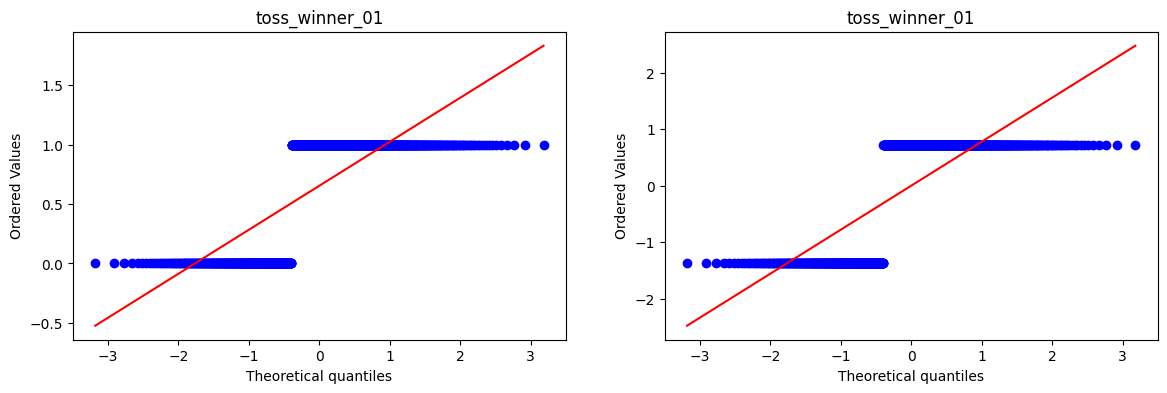

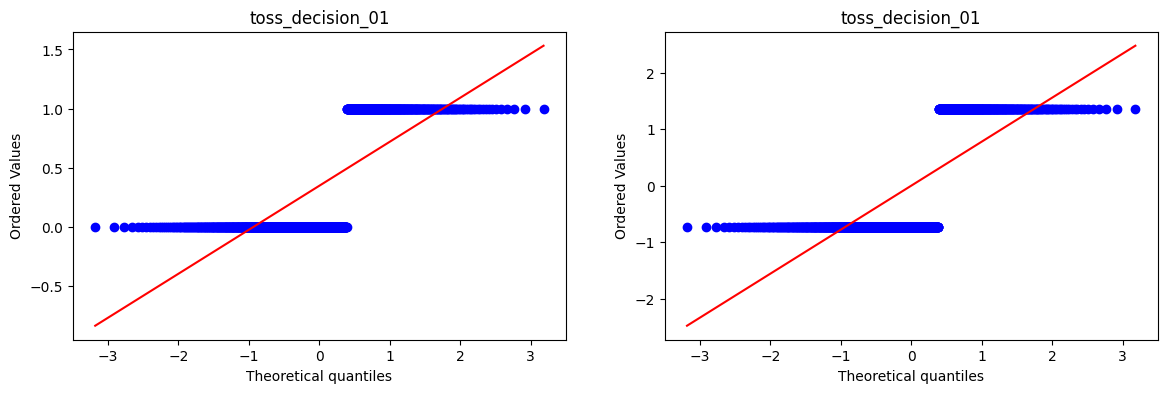

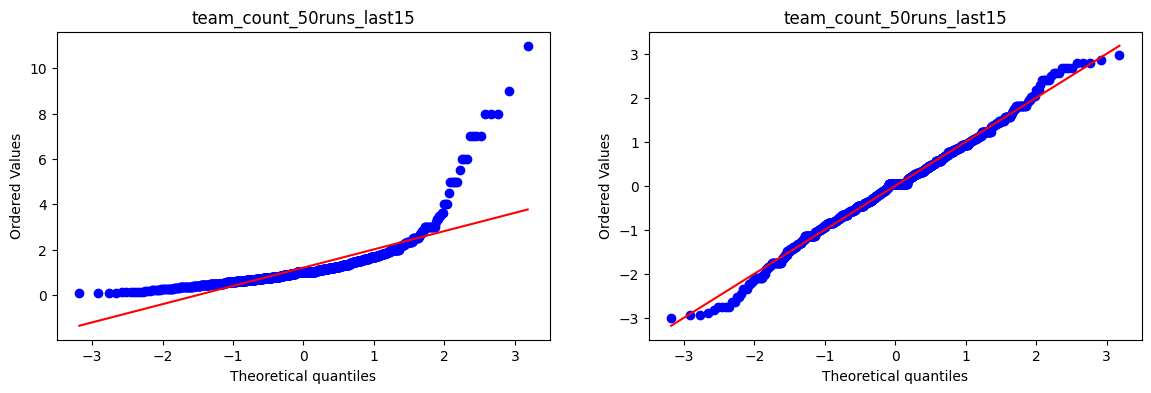

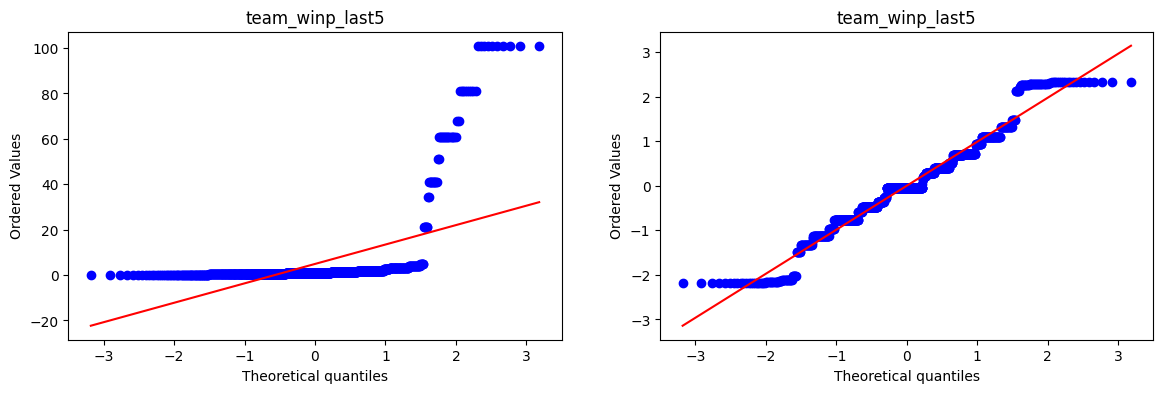

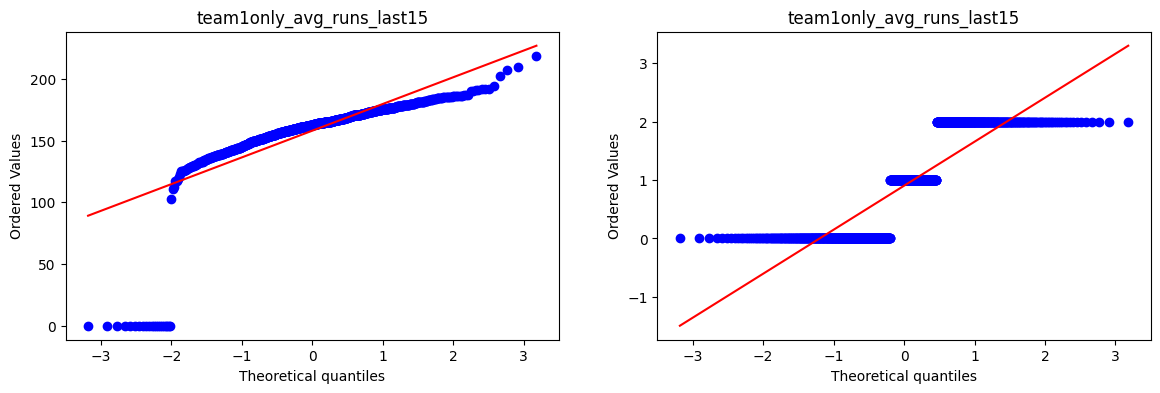

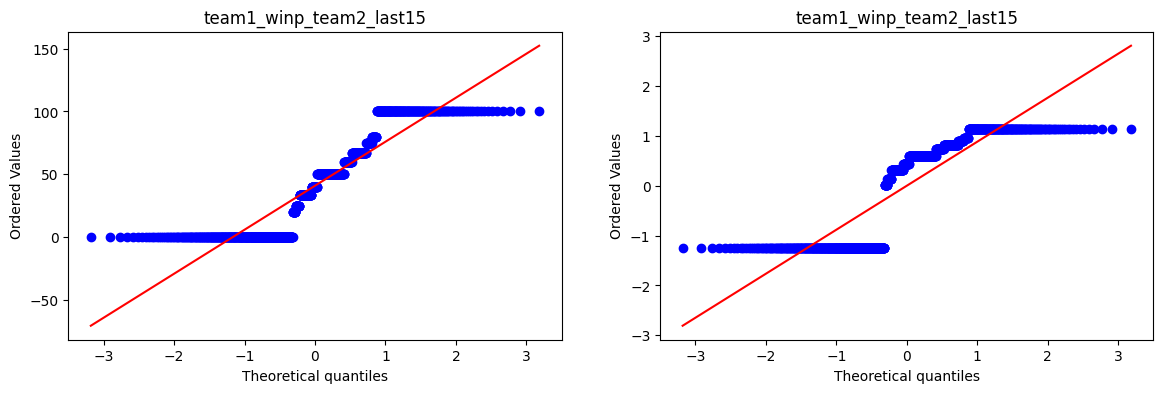

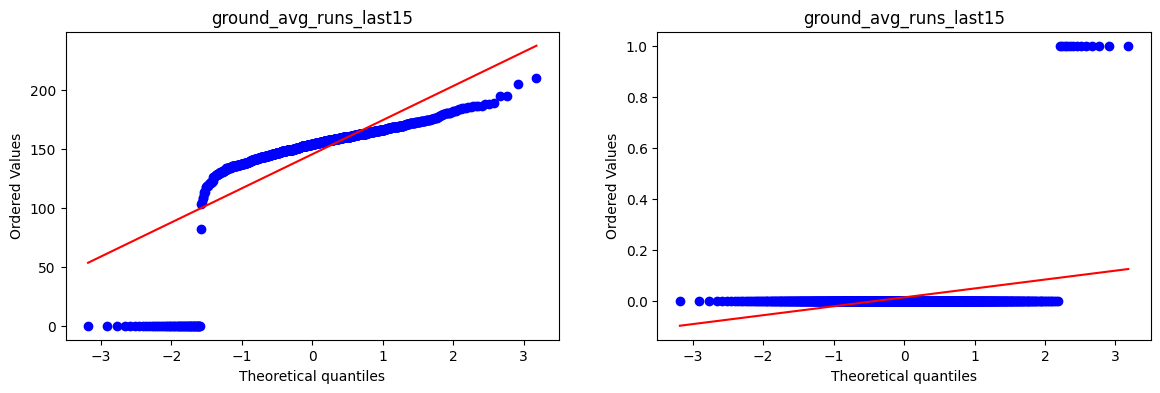

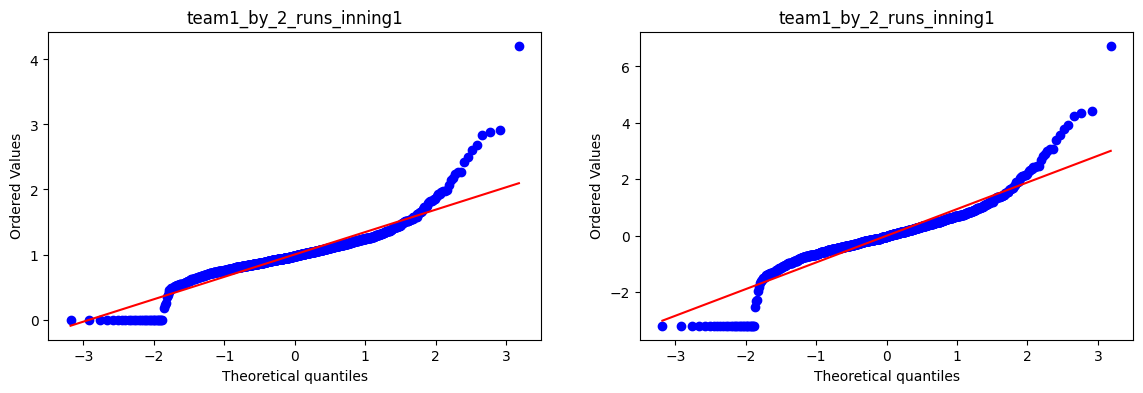

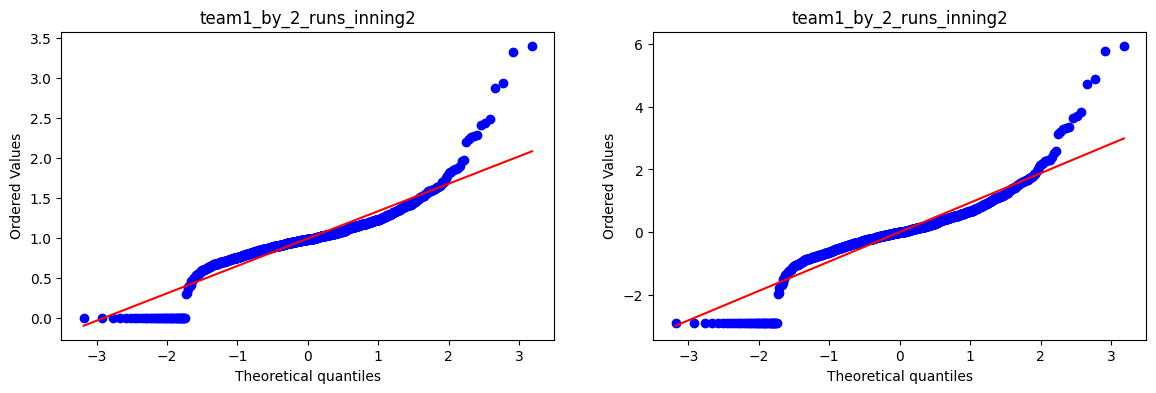

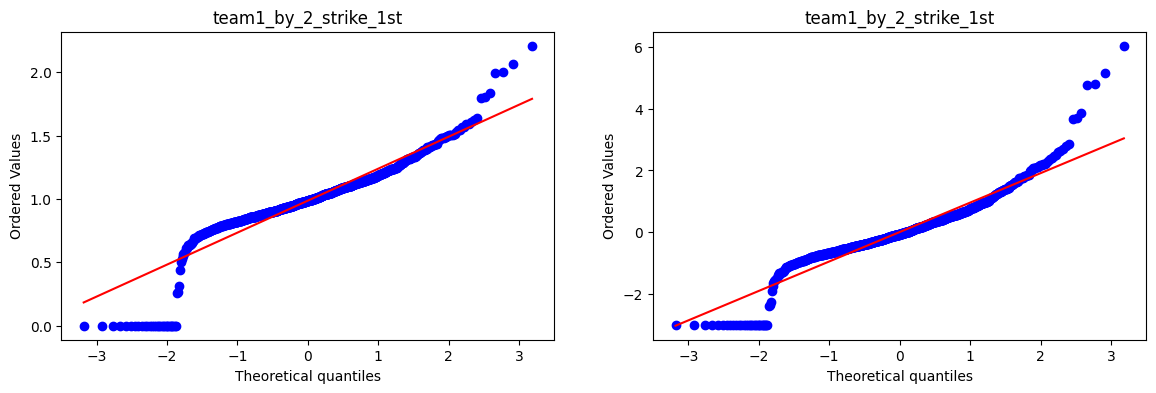

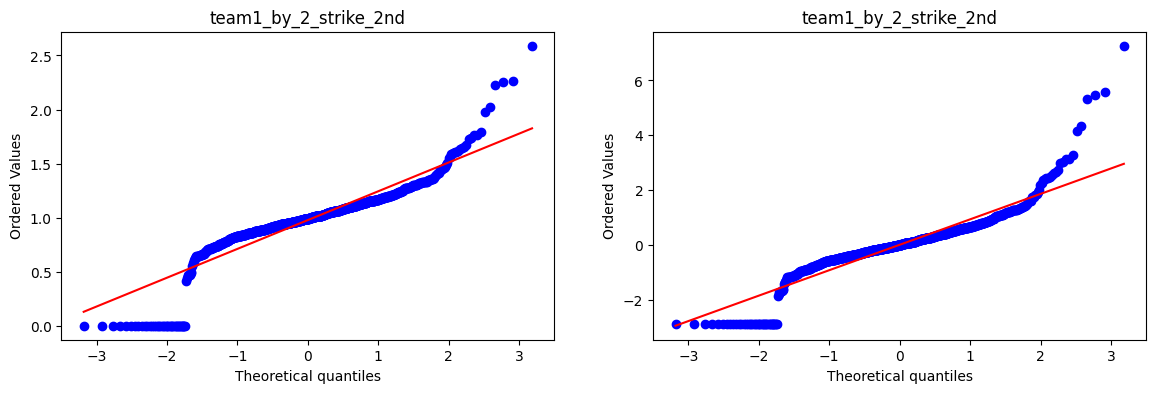

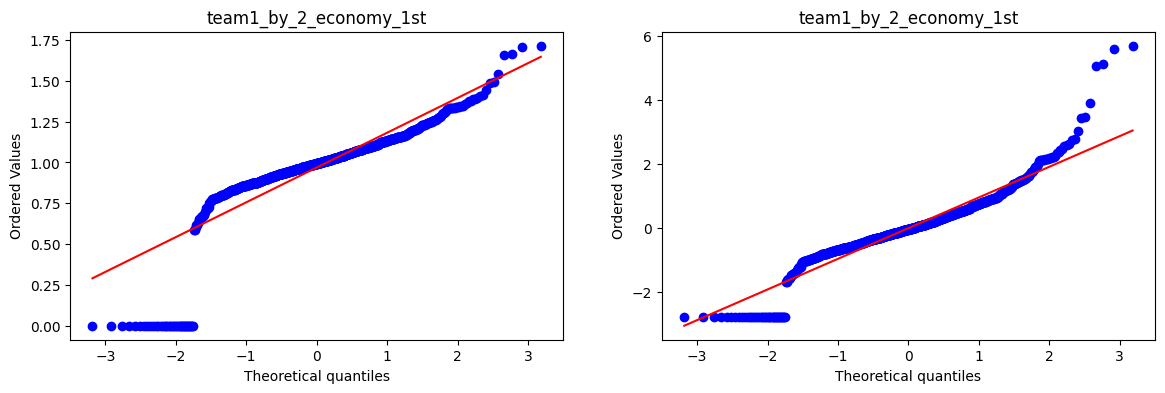

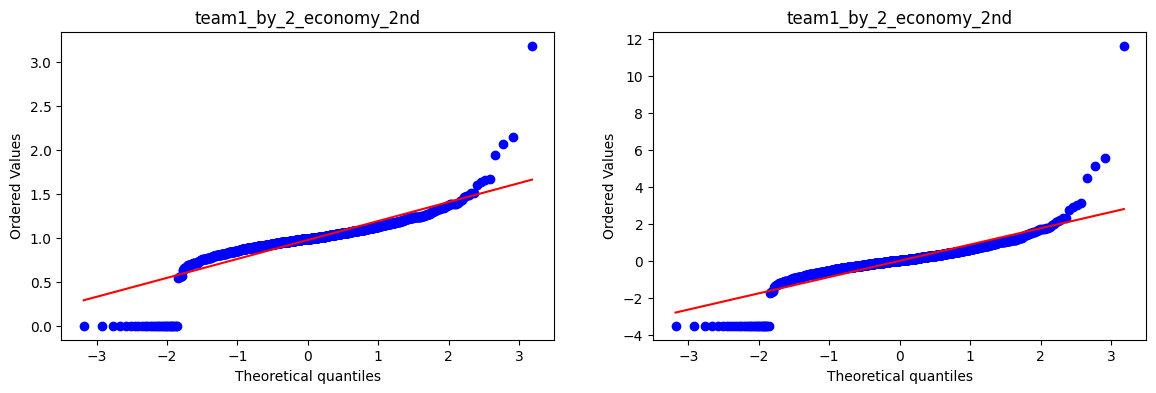

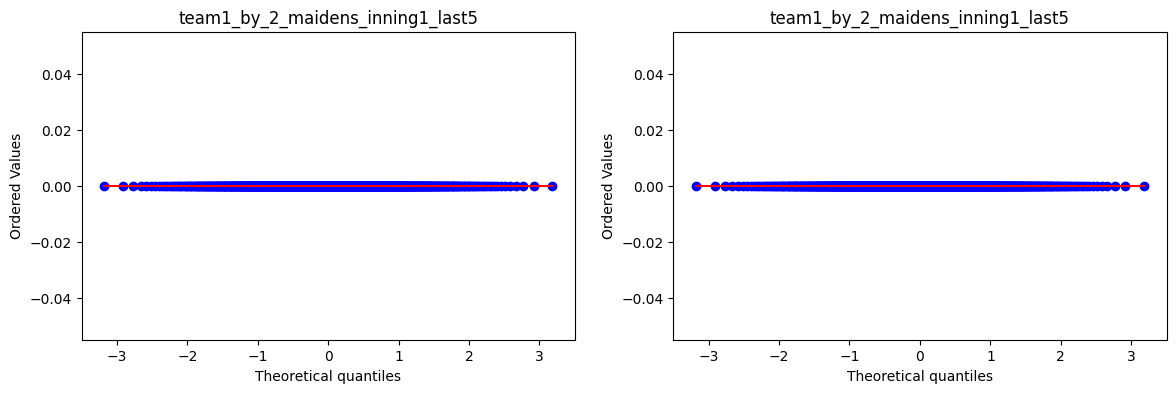

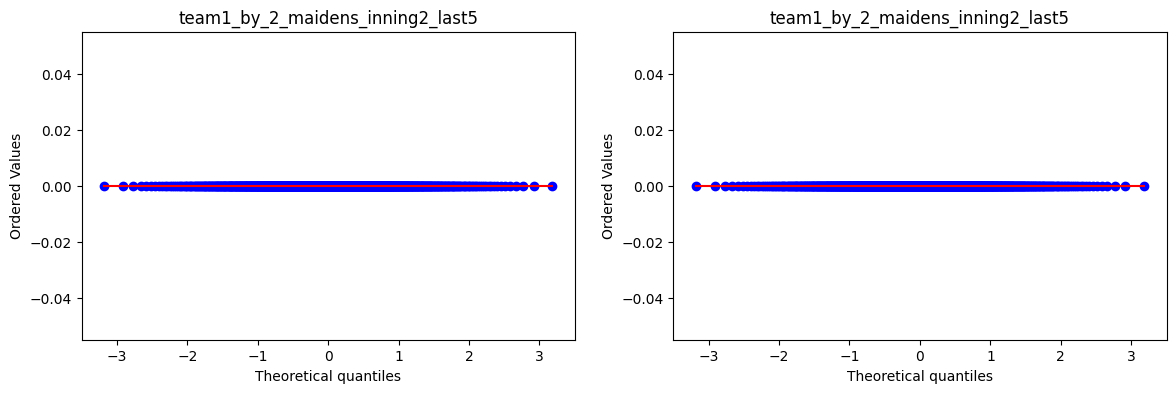

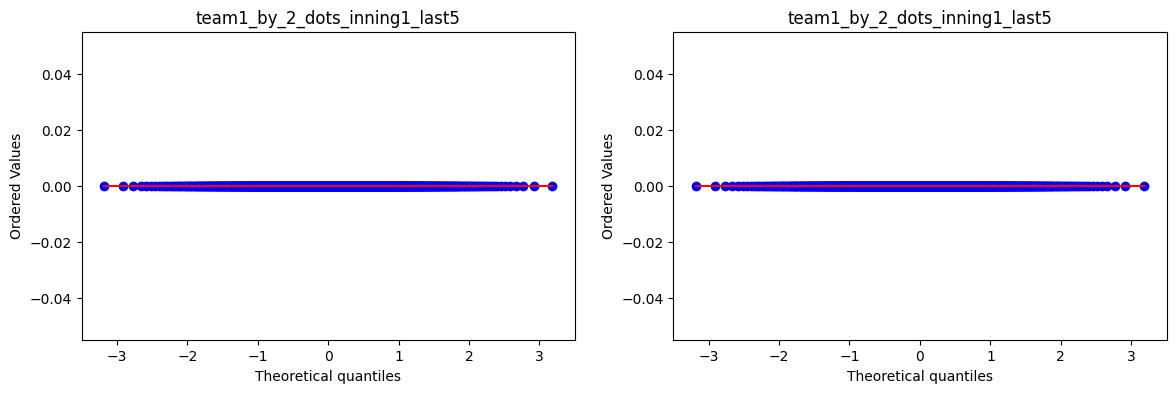

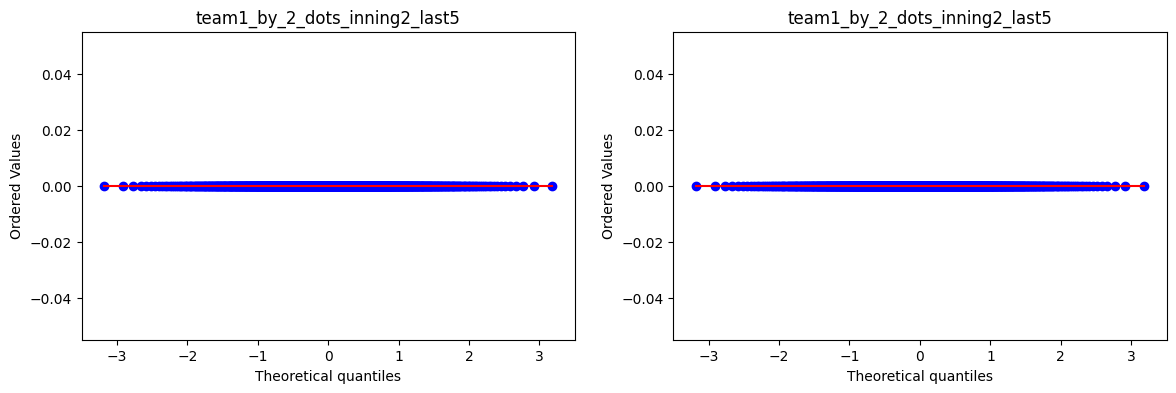

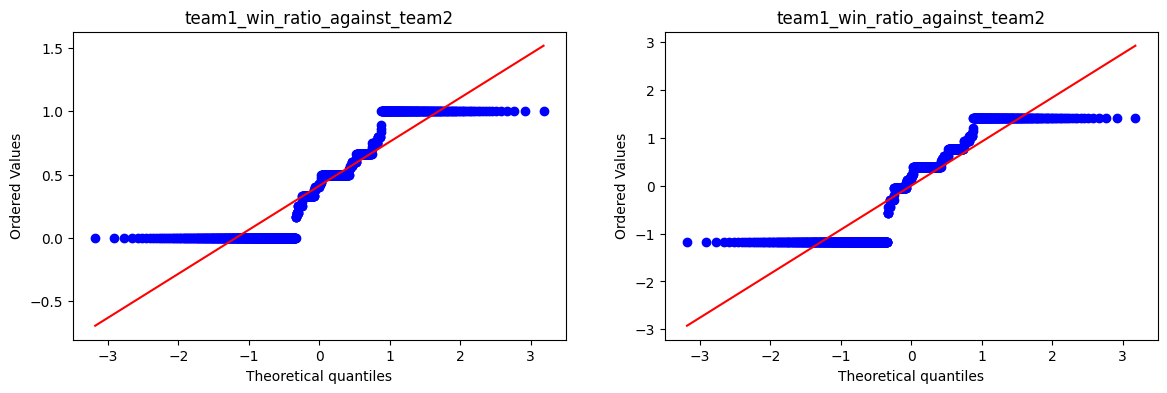

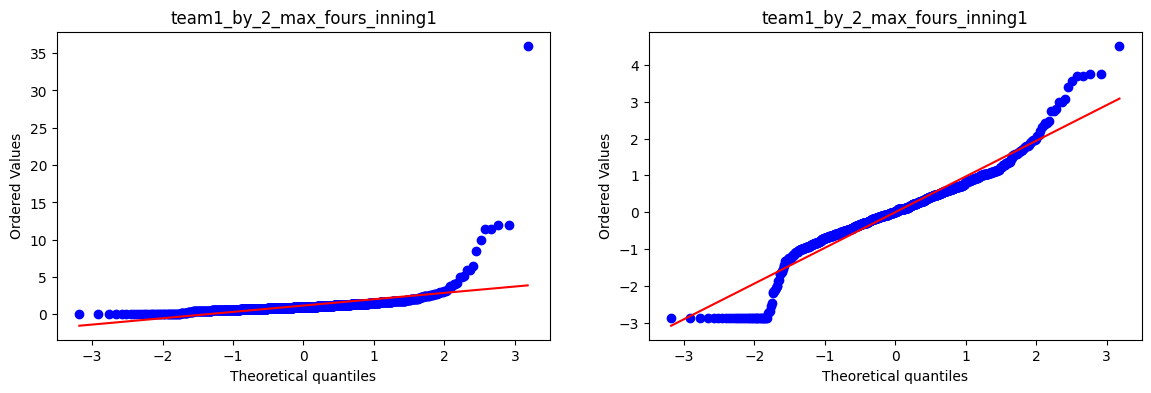

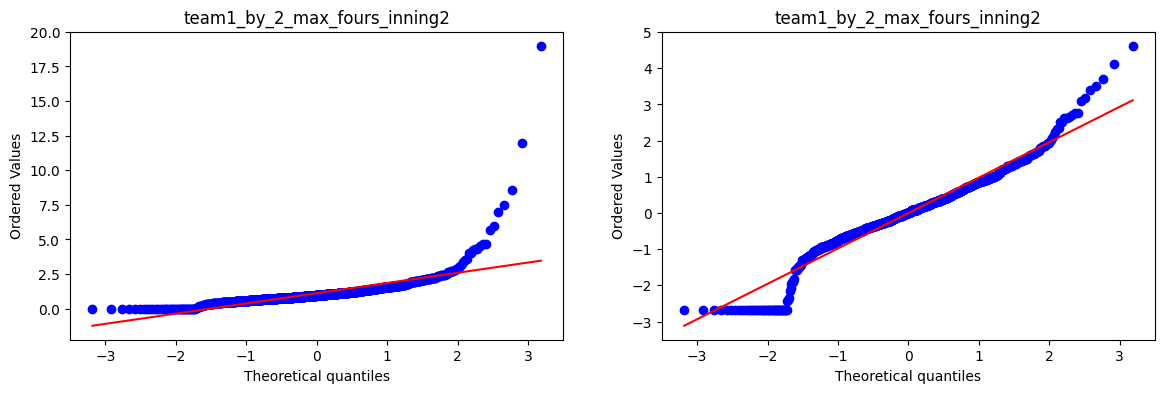

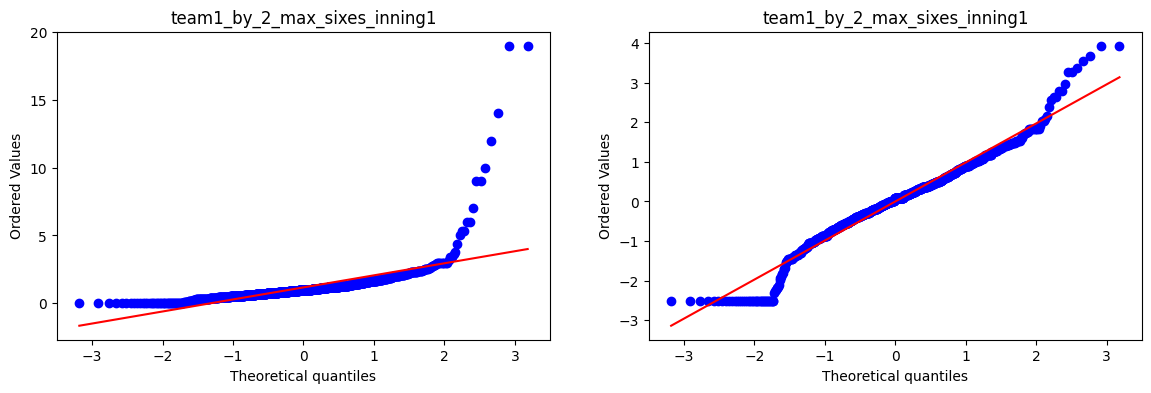

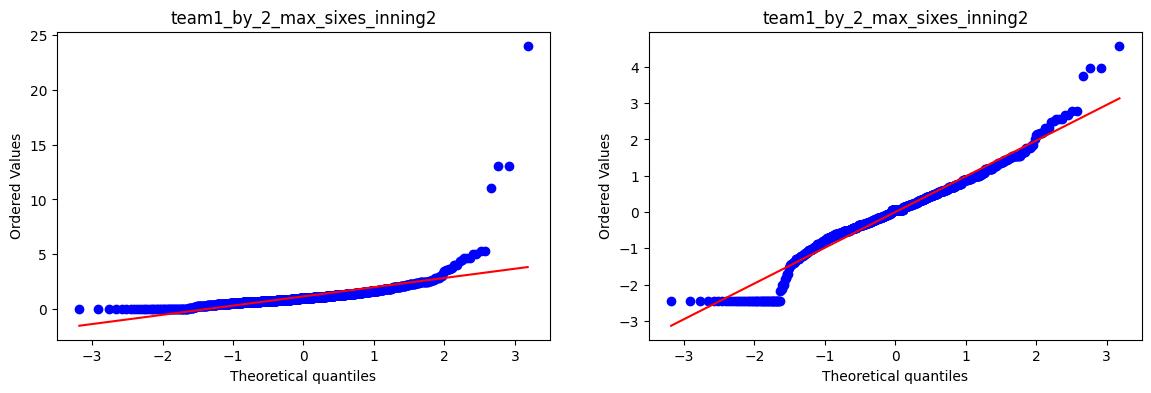

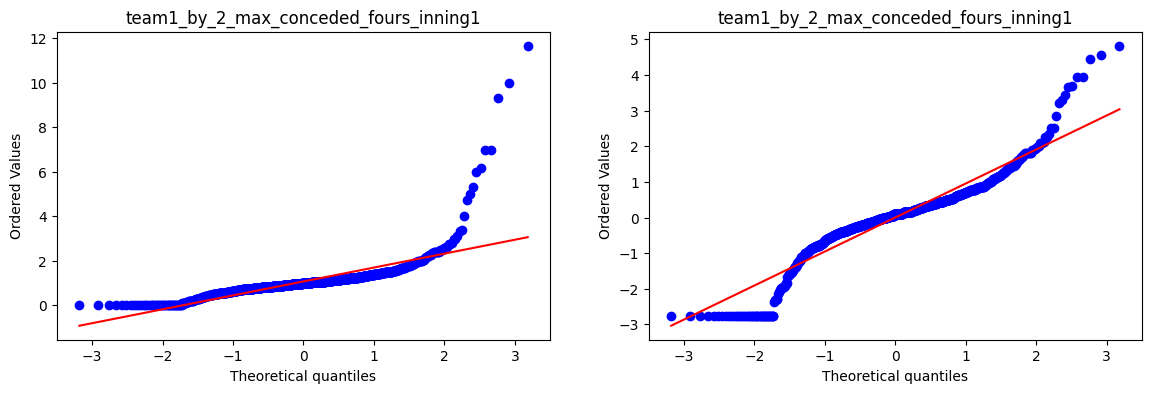

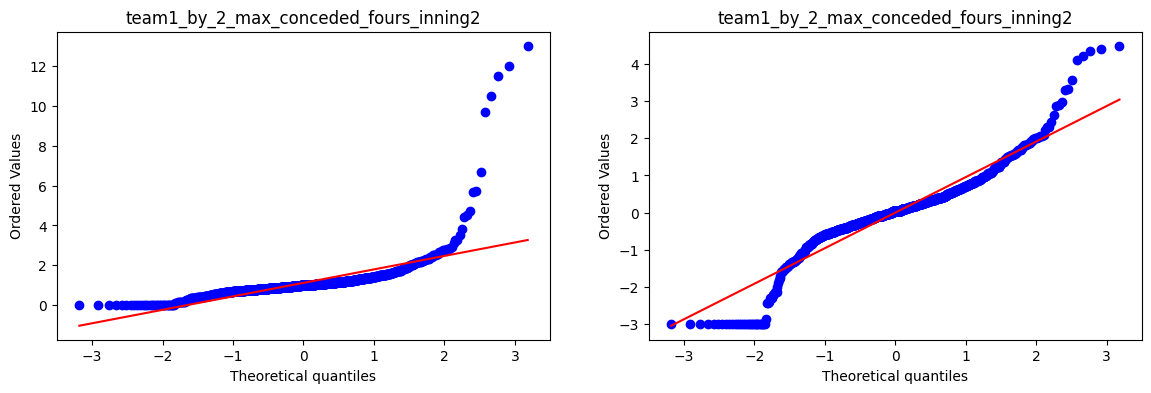

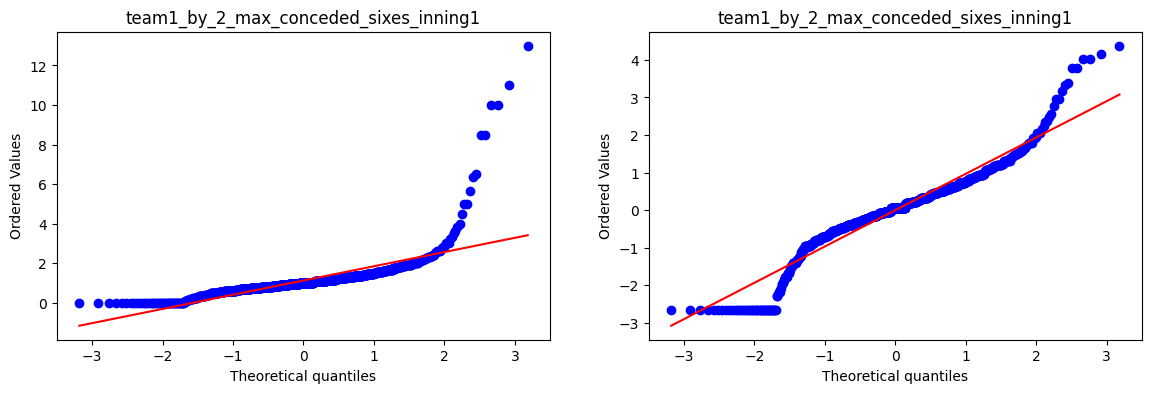

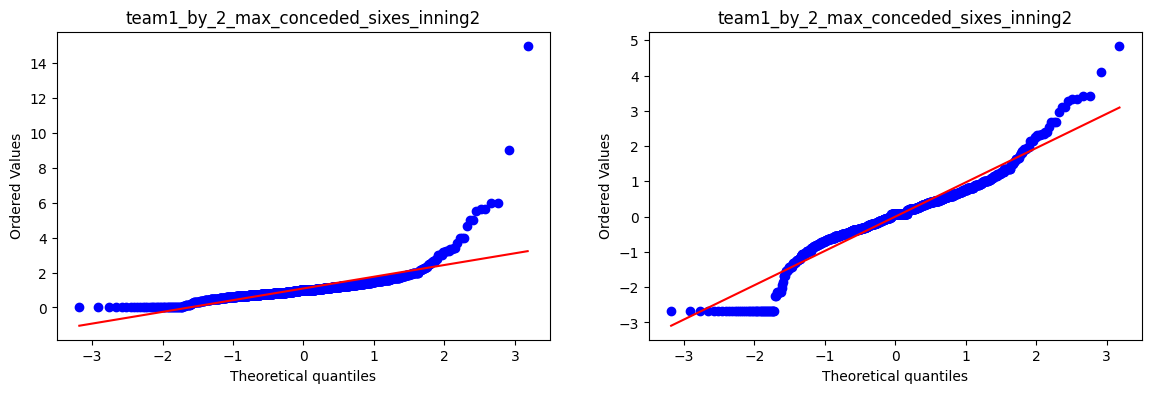

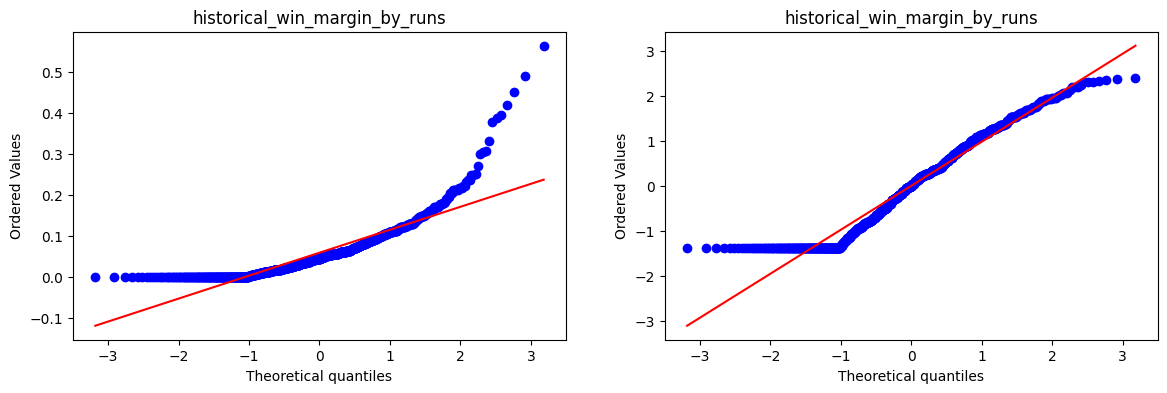

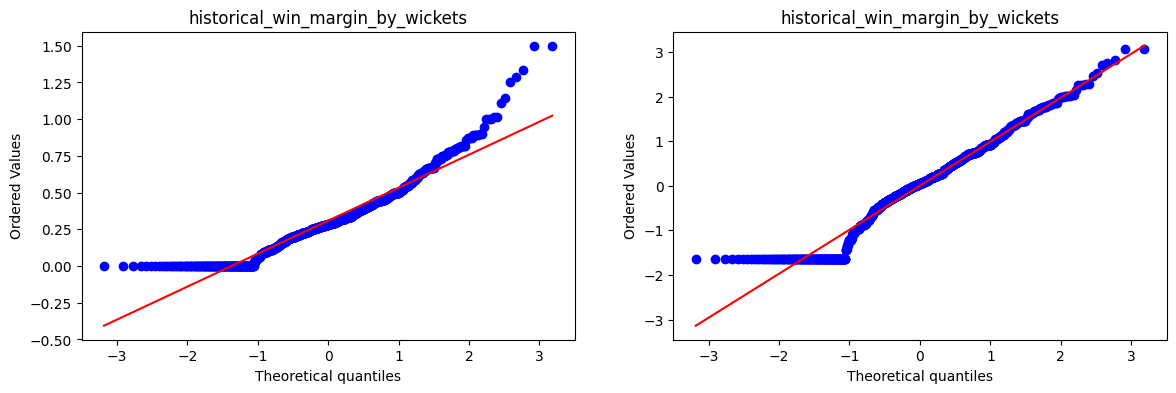

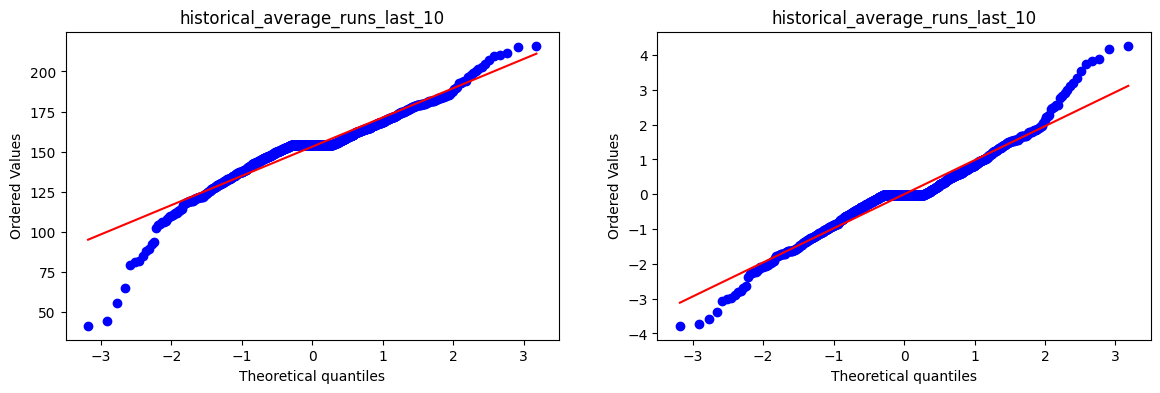

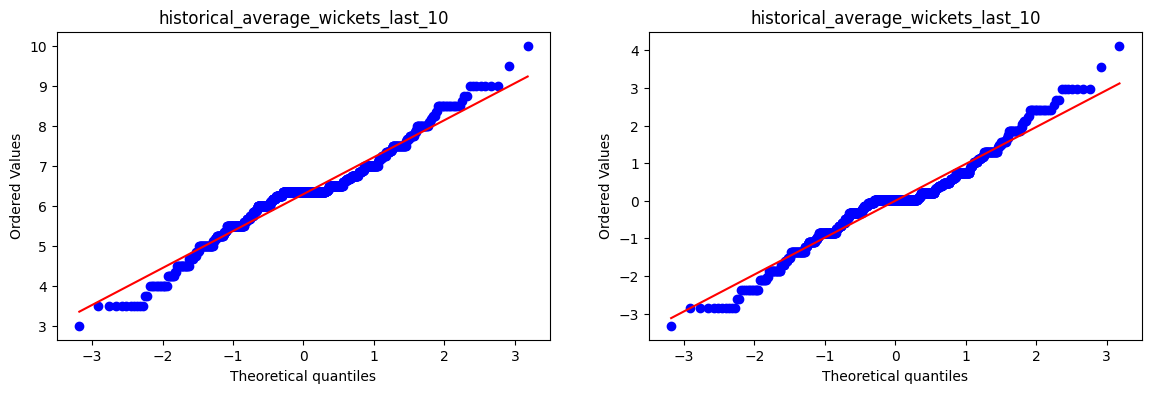

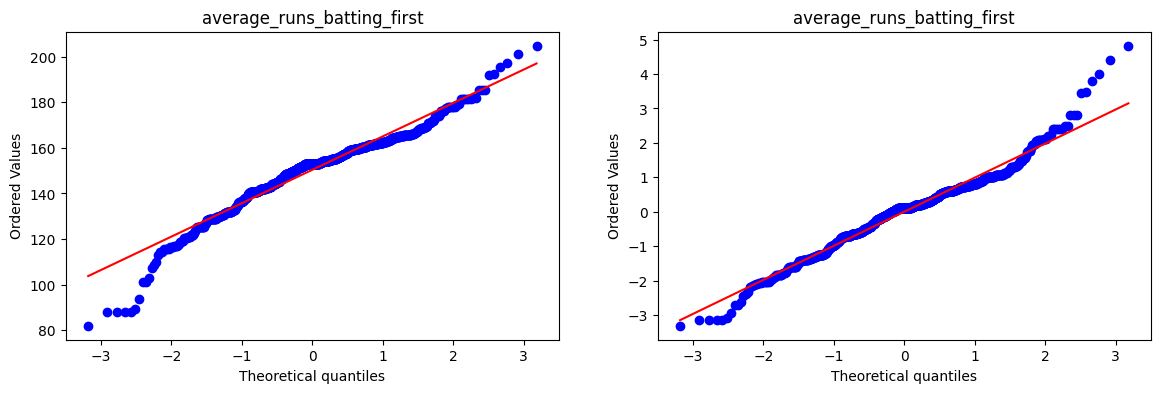

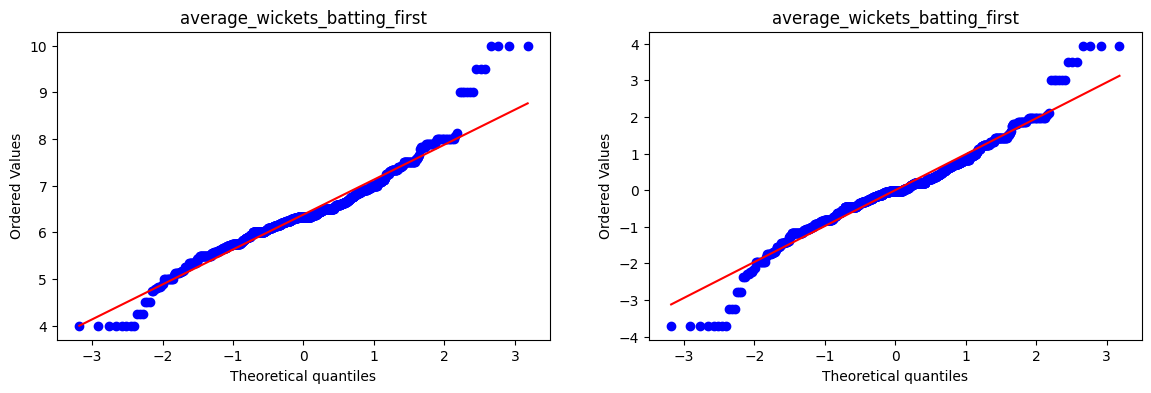

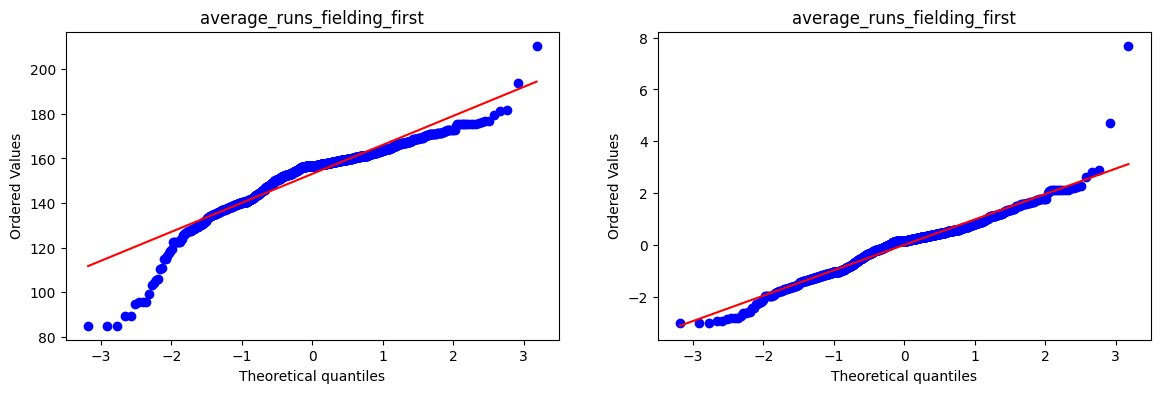

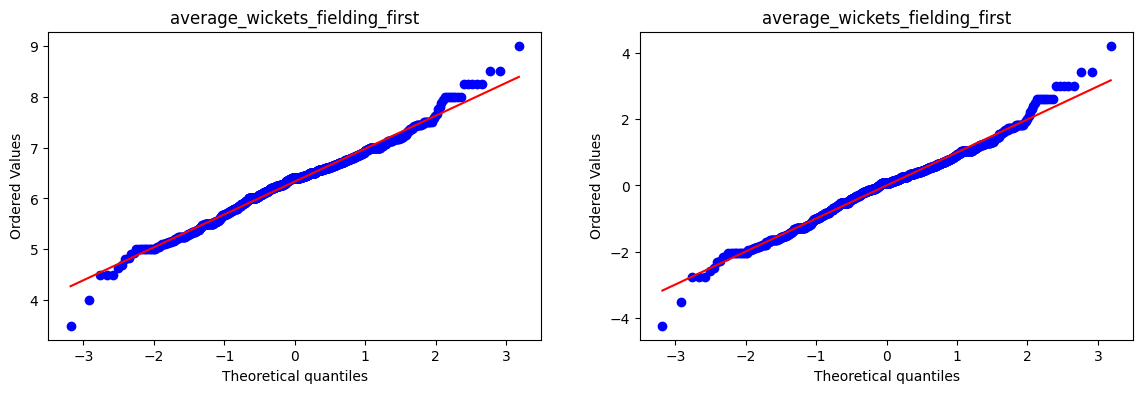

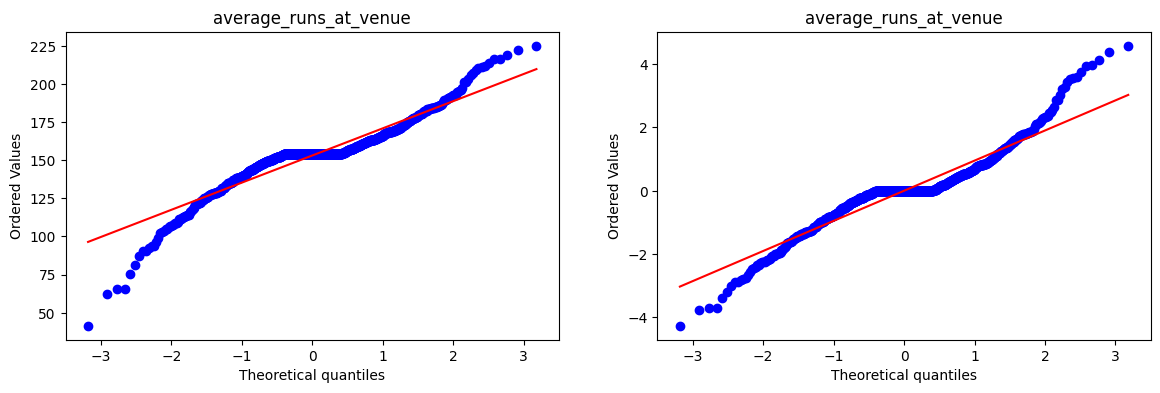

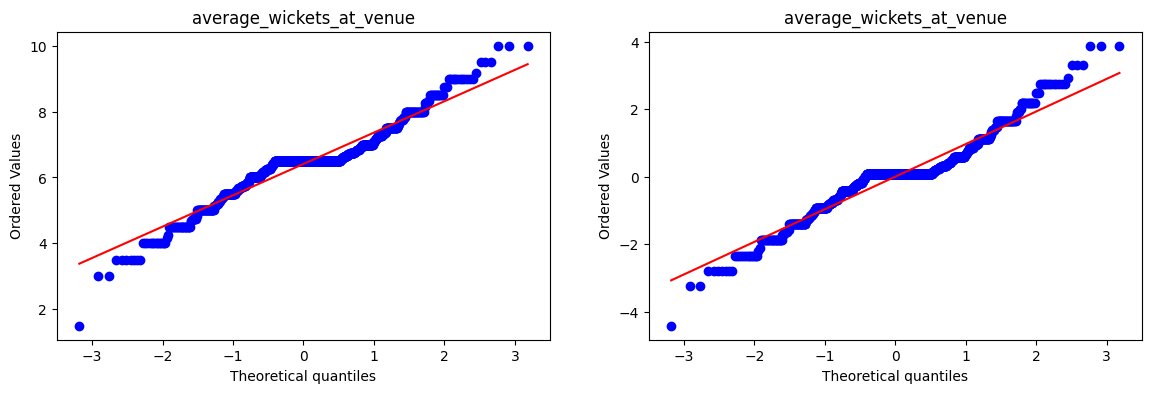

In [418]:
# Before and after comparision for Yeo-Johnson

for col in x_transformed_num.columns:
    plt.figure(figsize=(14,4))
    plt.subplot(121)
    stats.probplot(x[col], dist="norm", plot=plt)

    plt.title(col)

    plt.subplot(122)
    stats.probplot(x_transformed_num[col], dist="norm", plot=plt)

    plt.title(col)

    plt.show()

<Axes: xlabel='ground_avg_runs_last15', ylabel='Density'>

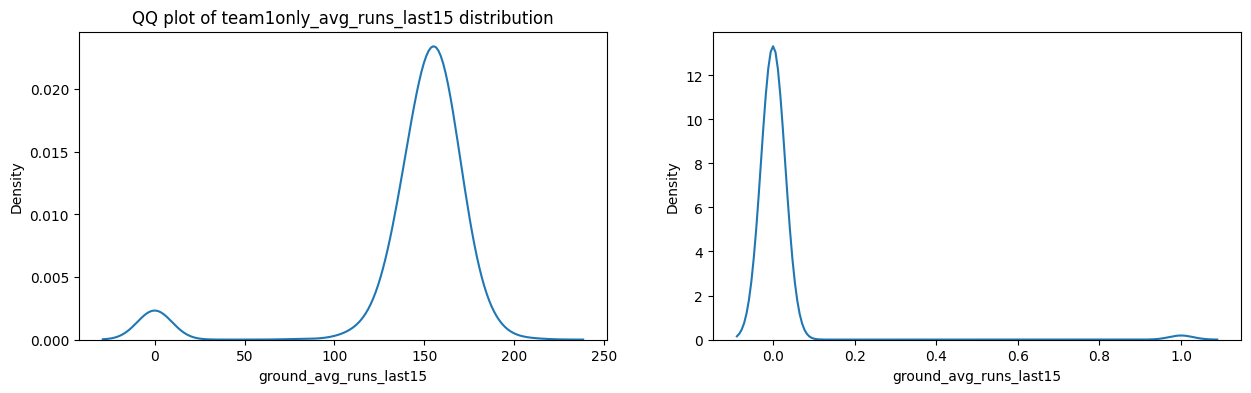

In [419]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(15,4))
ax1.set_title("team1only_avg_runs_last15 distribution")
sns.kdeplot(train_data['ground_avg_runs_last15'],ax=ax1)
ax1.set_title("QQ plot of team1only_avg_runs_last15 distribution")
# stats.probplot(train_data['team1only_avg_runs_last15'],plot=ax2)
sns.kdeplot(x_transformed_df['ground_avg_runs_last15'],ax=ax2)


In [420]:
# Cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [421]:
# Hyperparameter tuning
param_grid_gbm = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid_lgb = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 200]
}

param_grid_xgb = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 200]
}

param_grid_cat = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [500, 1000]
}

In [422]:
null_counts=x_test_transformed_df.isnull().sum()
cols_with_nulls = null_counts[null_counts > 0]
print(cols_with_nulls)


Series([], dtype: int64)


In [423]:

from sklearn.model_selection import train_test_split

In [424]:
x_tr,x_te,y_tr,y_te=train_test_split(x_transformed,y,test_size=0.2,random_state=42)

In [425]:
# Gradient Boosting
gbm = GradientBoostingClassifier()
grid_gbm = GridSearchCV(gbm, param_grid_gbm, cv=kf, scoring='accuracy')
grid_gbm.fit(x_tr, y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [426]:
# LightGBM
lgbm = lgb.LGBMClassifier()
grid_lgbm = GridSearchCV(lgbm, param_grid_lgb, cv=kf, scoring='accuracy')
grid_lgbm.fit(x_tr, y_tr)

[LightGBM] [Info] Number of positive: 301, number of negative: 305
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4508
[LightGBM] [Info] Number of data points in the train set: 606, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496700 -> initscore=-0.013202
[LightGBM] [Info] Start training from score -0.013202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [31, 50]},
             scoring='accuracy')

In [427]:
x_transformed.shape

(948, 165)

# this is for checking best method to impute missing values

In [428]:
# import lightgbm as lgb
# import xgboost as xgb
# from sklearn.model_selection import GridSearchCV, StratifiedKFold
# from sklearn.metrics import accuracy_score, classification_report

# # Define parameter grid for LightGBM
# param_grid_lgb = {
#     'num_leaves': [31, 40],
#     'min_data_in_leaf': [20, 30],
#     'max_depth': [-1, 10, 20],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#     'metric': ['binary_logloss', 'auc']
# }

# # Define cross-validation
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize the LightGBM model
# # lgbm = lgb.LGBMClassifier()
# xgbm=xgb.XGBClassifier()

# # Perform grid search with cross-validation
# # grid_lgbm = GridSearchCV(lgbm, param_grid_lgb, cv=kf, scoring='accuracy', n_jobs=-1)
# # grid_lgbm.fit(x_tr, y_tr)

# grid_xgbm = GridSearchCV(xgbm, param_grid_xgb, cv=kf, scoring='accuracy', n_jobs=-1)
# grid_xgbm.fit(x_tr, y_tr)

# # Use the best estimator for predictions
# # best_lgbm = grid_lgbm.best_estimator_
# # y_pred = best_lgbm.predict(x_te)

# best_xgbm = grid_xgbm.best_estimator_
# y_pred = best_xgbm.predict(x_te)

# # Evaluate the model
# accuracy = accuracy_score(y_te, y_pred)
# # print(f"LightGBM Accuracy: {accuracy}")
# print(f"XG boost accuracy : {accuracy}")
# print(classification_report(y_te, y_pred, labels=[0, 1]))


In [429]:
# pip install missingpy

## tried using missingpy but it seemed to have some deprecated module

In [430]:
# import lightgbm as lgb
# import xgboost as xgb
# from catboost import CatBoostClassifier
# from sklearn.ensemble import GradientBoostingClassifier
# from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
# from sklearn.metrics import accuracy_score, classification_report
# from missingpy import MissForest
# import numpy as np
# import pandas as pd


# # Define the MissForest imputer
# missforest_imputer = MissForest()

# # Fit the imputer on the training data and transform both training and test data
# x_tr_imputed = missforest_imputer.fit_transform(x_tr)
# x_te_imputed = missforest_imputer.transform(x_te)

# # Define parameter grids for each model
# param_grid_lgb = {
#     'num_leaves': [31, 40],
#     'min_data_in_leaf': [20, 30],
#     'max_depth': [-1, 10, 20],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'boosting_type': ['gbdt'],
#     'objective': ['binary'],
#     'metric': ['binary_logloss', 'auc']
# }

# param_grid_xgb = {
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200],
#     'objective': ['binary:logistic'],
#     'eval_metric': ['logloss']
# }

# param_grid_catboost = {
#     'depth': [6, 8, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'iterations': [100, 200],
#     'eval_metric': ['Logloss']
# }

# param_grid_gb = {
#     'max_depth': [3, 6, 10],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators': [100, 200]
# }

# # Define cross-validation
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Define the models
# models = {
#     'LightGBM': (lgb.LGBMClassifier(), param_grid_lgb),
#     'XGBoost': (xgb.XGBClassifier(use_label_encoder=False), param_grid_xgb),
#     'CatBoost': (CatBoostClassifier(silent=True), param_grid_catboost),
#     'GradientBoosting': (GradientBoostingClassifier(), param_grid_gb)
# }

# # Perform hyperparameter tuning
# best_algorithm = None
# best_score = 0
# best_model = None
# for algo_name, (model, param_grid) in models.items():
#     grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
#     grid_search.fit(x_tr_imputed, y_tr)
    
#     if grid_search.best_score_ > best_score:
#         best_score = grid_search.best_score_
#         best_algorithm = algo_name
#         best_model = grid_search.best_estimator_

# # Use the best model for predictions
# y_pred = best_model.predict(x_te_imputed)

# # Evaluate the model
# accuracy = accuracy_score(y_te, y_pred)
# print(f"Best Algorithm: {best_algorithm}")
# print(f"Accuracy: {accuracy}")
# print(classification_report(y_te, y_pred, labels=[0, 1]))


In [431]:
# XGBoost
xgbm = xgb.XGBClassifier()
grid_xgbm = GridSearchCV(xgbm, param_grid_xgb, cv=kf, scoring='accuracy')
grid_xgbm.fit(x_tr, y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [432]:
# CatBoost
cat = CatBoostClassifier(verbose=0)
grid_cat = GridSearchCV(cat, param_grid_cat, cv=kf, scoring='accuracy')
grid_cat.fit(x_tr, y_tr)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x1771570b0>,
             param_grid={'depth': [4, 6, 8], 'iterations': [500, 1000],
                         'learning_rate': [0.01, 0.1]},
             scoring='accuracy')

In [433]:
# Ensemble Voting Classifier
voting_clf = VotingClassifier(estimators=[
    ('gbm', grid_gbm.best_estimator_),
    ('lgbm', grid_lgbm.best_estimator_),
    ('xgbm', grid_xgbm.best_estimator_),
    ('cat', grid_cat.best_estimator_)
], voting='soft')
voting_clf.fit(x_tr, y_tr)

[LightGBM] [Info] Number of positive: 376, number of negative: 382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5738
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496042 -> initscore=-0.015831
[LightGBM] [Info] Start training from score -0.015831
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

VotingClassifier(estimators=[('gbm',
                              GradientBoostingClassifier(n_estimators=50)),
                             ('lgbm', LGBMClassifier(learning_rate=0.01)),
                             ('xgbm',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_typ...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=50, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x318c1bc50>)],
                 voting='soft')

In [434]:
# Evaluate Models
models = {
    'Gradient Boosting': grid_gbm.best_estimator_,
    'LightGBM': grid_lgbm.best_estimator_,
    'XGBoost': grid_xgbm.best_estimator_,
    'CatBoost': grid_cat.best_estimator_,
    # 'Voting Classifier': voting_clf
}

In [435]:
accuracies={}

In [436]:
x_transformed.shape, x_test_transformed.shape

((948, 165), (271, 165))

In [437]:
for name, model in models.items():
    y_pred = model.predict(x_te)
    accuracy = accuracy_score(y_te, y_pred)
    print(f"{name} Accuracy: {accuracy}")
    print(classification_report(y_te, y_pred, labels=[0, 1]))
    accuracies[name]=accuracy

Gradient Boosting Accuracy: 0.7578947368421053
              precision    recall  f1-score   support

           0       0.70      0.80      0.75        86
           1       0.82      0.72      0.77       104

    accuracy                           0.76       190
   macro avg       0.76      0.76      0.76       190
weighted avg       0.76      0.76      0.76       190

LightGBM Accuracy: 0.7789473684210526
              precision    recall  f1-score   support

           0       0.72      0.84      0.77        86
           1       0.84      0.73      0.78       104

    accuracy                           0.78       190
   macro avg       0.78      0.78      0.78       190
weighted avg       0.79      0.78      0.78       190

XGBoost Accuracy: 0.7473684210526316
              precision    recall  f1-score   support

           0       0.68      0.83      0.75        86
           1       0.83      0.68      0.75       104

    accuracy                           0.75       190
   mac

In [438]:
param_grids = {
    'Gradient Boosting': param_grid_gbm,
    'LightGBM': param_grid_lgb,
    'XGBoost': param_grid_xgb,
    'CatBoost': param_grid_cat
}

In [439]:
# Perform hyperparameter tuning
best_algorithm = None
best_score = 0
best_model = None
for algo_name, model in models.items():
    param_grid = param_grids[algo_name]
    grid_search = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
    grid_search.fit(x_transformed, y)
    
    if grid_search.best_score_ > best_score:
        best_score = grid_search.best_score_
        best_algorithm = algo_name
        best_model = grid_search.best_estimator_

[LightGBM] [Info] Number of positive: 480, number of negative: 468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5986
[LightGBM] [Info] Number of data points in the train set: 948, number of used features: 43
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506329 -> initscore=0.025318
[LightGBM] [Info] Start training from score 0.025318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [441]:
best_score

0.7679922027290449

In [442]:
best_algorithm

'CatBoost'

In [443]:
best_model.fit(x_transformed,y)

In [3295]:
lgbm = lgb.LGBMClassifier()
grid_lgbm = GridSearchCV(lgbm, param_grid_lgb, cv=kf, scoring='accuracy')
grid_lgbm.fit(x_transformed, y)

[LightGBM] [Info] Number of positive: 384, number of negative: 374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4241
[LightGBM] [Info] Number of data points in the train set: 758, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506596 -> initscore=0.026387
[LightGBM] [Info] Start training from score 0.026387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.01, 0.1],
                         'n_estimators': [50, 100, 200],
                         'num_leaves': [31, 50]},
             scoring='accuracy')

In [2133]:
# CatBoost
cat = CatBoostClassifier(verbose=0)
grid_cat = GridSearchCV(cat, param_grid_cat, cv=kf, scoring='accuracy')
grid_cat.fit(x_transformed, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x304e50a70>,
             param_grid={'depth': [4, 6, 8], 'iterations': [500, 1000],
                         'learning_rate': [0.01, 0.1]},
             scoring='accuracy')

In [2134]:
# XGBoost
xgbm = xgb.XGBClassifier()
grid_xgbm = GridSearchCV(xgbm, param_grid_xgb, cv=kf, scoring='accuracy')
grid_xgbm.fit(x_transformed, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [2135]:
voting_clf = VotingClassifier(estimators=[
    ('gbm', grid_gbm.best_estimator_),
    ('lgbm', grid_lgbm.best_estimator_),
    ('xgbm', grid_xgbm.best_estimator_),
    ('cat', grid_cat.best_estimator_)
], voting='soft')
voting_clf.fit(x_transformed, y)

[LightGBM] [Info] Number of positive: 480, number of negative: 468
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2519
[LightGBM] [Info] Number of data points in the train set: 948, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.506329 -> initscore=0.025318
[LightGBM] [Info] Start training from score 0.025318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

VotingClassifier(estimators=[('gbm',
                              GradientBoostingClassifier(learning_rate=0.01,
                                                         n_estimators=200)),
                             ('lgbm',
                              LGBMClassifier(learning_rate=0.01,
                                             num_leaves=50)),
                             ('xgbm',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=...
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=5,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x17d9d0080>)],
                 voting='soft')

In [2136]:
# Find the algorithm with the highest accuracy
best_algorithm = max(accuracies, key=accuracies.get)

In [1262]:
best_algorithm

'CatBoost'

In [1263]:
# test_data_new=test_data[['toss_winner_01', 'toss_decision_01', 'team_count_50runs_last15', 'team_winp_last5', 
#             'team1only_avg_runs_last15', 'team1_winp_team2_last15', 'ground_avg_runs_last15','team1_by_2_runs_1st','team1_by_2_runs_2nd','team1_by_2_strike_1st','team1_by_2_strike_2nd','team1_by_2_economy_1st','team1_by_2_economy_2nd','lighting','venue','season']]

In [1264]:
X_test

toss_winner_01  toss_decision_01  team_count_50runs_last15  \
0                 1                 0                  0.333333   
1                 0                 1                  1.800000   
2                 0                 1                  0.750000   
3                 0                 1                  1.600000   
4                 1                 0                  0.692308   
..              ...               ...                       ...   
266               1                 0                  0.923077   
267               1                 0                  0.800000   
268               0                 1                  0.692308   
269               0                 1                  0.461538   
270               1                 0                  0.866667   

     team_winp_last5  team1only_avg_runs_last15  team1_winp_team2_last15  \
0           1.487805                 171.066667                   100.00   
1           1.000000                 168.000000                    50.00   
2           1.000000                 160.533333                    33.33   
3           1.000000                 168.000000                    50.00   
4           0.512195                 160.533333                    33.33   
..               ...                        ...                      ...   
266         2.904762                 169.600000                    60.00   
267         1.000000                 174.266667                    60.00   
268         0.047619                 159.333333                    50.00   
269         3.857143                 163.800000                    60.00   
270         1.655738                 153.400000                    40.00   

     ground_avg_runs_last15  team1_by_2_runs_inning1  team1_by_2_runs_inning2  \
0                161.750000                 0.984106                 1.287951   
1                158.777778                 0.907192                 1.071651   
2                164.000000                 0.687159                 1.008761   
3                161.750000                 0.888493                 1.045850   
4                158.250000                 1.005599                 1.508910   
..                      ...                      ...                      ...   
266              159.400000                 0.933850                 1.113400   
267              151.625000                 1.005641                 0.958636   
268              197.000000                 0.966632                 1.090688   
269              163.300000                 0.665711                 1.032348   
270              139.000000                 1.102507                 1.169148   

     team1_by_2_strike_1st  ...  team1_by_2_economy_2nd  \
0                 1.242757  ...                1.047406   
1                 1.139831  ...                1.044609   
2                 0.782363  ...                0.831315   
3                 1.129334  ...                0.997129   
4                 0.983781  ...                0.884676   
..                     ...  ...                     ...   
266               0.991347  ...                1.004132   
267               0.990095  ...                0.964316   
268               1.182331  ...                0.976648   
269               0.975005  ...                0.914513   
270               0.832400  ...                0.937621   

     team1_by_2_maidens_inning1_last5  team1_by_2_maidens_inning2_last5  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   
..                                ...                               ...   
266                               0.0                               0.0   
267  

In [1265]:
x_test_transformed[0]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [1266]:
x_test_transformed.shape

(271, 148)

In [1267]:
x_transformed_df

team1only_avg_runs_last15  ground_avg_runs_last15  lighting  \
0                          1.0                     0.0       0.0   
1                          1.0                     0.0       0.0   
2                          0.0                     0.0       0.0   
3                          0.0                     0.0       0.0   
4                          0.0                     0.0       0.0   
..                         ...                     ...       ...   
943                        0.0                     0.0       0.0   
944                        1.0                     0.0       0.0   
945                        0.0                     0.0       0.0   
946                        0.0                     0.0       0.0   
947                        1.0                     0.0       0.0   

     venue_Al At Ct Gd On Ct My Tf 1  venue_Al At Ct Gd On Ct My Tf 2  \
0                                0.0                              0.0   
1                                0.0                              0.0   
2                                0.0                              0.0   
3                                0.0                              0.0   
4                                0.0                              0.0   
..                               ...                              ...   
943                              0.0                              0.0   
944                              0.0                              0.0   
945                              0.0                              0.0   
946                              0.0                              0.0   
947                              0.0                              0.0   

     venue_An Jy Sm Di  venue_Au Ct Ay Dn  venue_Ba Ct Sm Gi  venue_Bd Pk Pl  \
0                  0.0                0.0                0.0             1.0   
1                  0.0                0.0                0.0             0.0   
2                  0.0                0.0                0.0             0.0   
3                  0.0                0.0                0.0             0.0   
4                  0.0                0.0                0.0             0.0   
..                 ...                ...                ...             ...   
943                0.0                0.0                0.0             0.0   
944                0.0                0.0                0.0             0.0   
945                0.0                0.0                0.0             1.0   
946                0.0                0.0                0.0             0.0   
947                0.0                0.0                0.0             0.0   

     venue_Be Ct Gd Wa Be  ...  team1_by_2_strike_1st  team1_by_2_strike_2nd  \
0                     0.0  ...              -0.178021              -0.622866   
1                     0.0  ...               1.106134               0.858369   
2                     0.0  ...              -0.591213              -0.925686   
3                     0.0  ...               1.016318              -0.100021   
4                     0.0  ...               0.437476              -0.214021   
..                    ...  ...                    ...                    ...   
943                   0.0  ...               0.714186              -0.060274   
944                   0.0  ...               0.855696              -0.609864   
945                   0.0  ...               0.123272               0.136682   
946                   0.0  ...               0.256070               0.238491   
947                   0.0  ...               1.104469               0.192421   

     team1_by_2_economy_1st  team1_by_2_economy_2nd  \
0                  0.022905                0.372999   
1                 -1.624555               -0.189537   
2                  2.024026                0.582297   
3                 -0.057818                0.923524   
4                 -1.876960                2.309933   
..                      ...                     ...   
943 

In [444]:
# Make predictions on test data
test_data['win_pred_score'] = best_model.predict_proba(x_test_transformed)[:, 1]
test_data['y_pred_01'] = best_model.predict(x_test_transformed)
test_data['win_pred_team_id'] = np.where(test_data['y_pred_01'] == 0, test_data['team1_id'], test_data['team2_id'])

In [445]:
# Make predictions on train data for consistency in results
train_data['win_pred_score'] = best_model.predict_proba(x_transformed)[:, 1]
train_data['y_pred_01'] = best_model.predict(x_transformed)
train_data['win_pred_team_id'] = np.where(train_data['y_pred_01'] == 0, train_data['team1_id'], train_data['team2_id'])

In [446]:
# Adjust win_pred_score based on y_pred_01
train_data['win_pred_score'] = np.where(train_data['y_pred_01'] == 0, 1 - train_data['win_pred_score'], train_data['win_pred_score'])
test_data['win_pred_score'] = np.where(test_data['y_pred_01'] == 0, 1 - test_data['win_pred_score'], test_data['win_pred_score'])

In [447]:
# Print the length of features list
print("Length of features list:", len(features))

# Print the lengths of feature importances from each model
print("Length of feature importances from grid_gbm:", len(grid_gbm.best_estimator_.feature_importances_))
print("Length of feature importances from grid_lgbm:", len(grid_lgbm.best_estimator_.feature_importances_))
print("Length of feature importances from grid_xgbm:", len(grid_xgbm.best_estimator_.feature_importances_))
print("Length of feature importances from grid_cat:", len(grid_cat.best_estimator_.feature_importances_))


Length of features list: 39
Length of feature importances from grid_gbm: 165
Length of feature importances from grid_lgbm: 165
Length of feature importances from grid_xgbm: 165
Length of feature importances from grid_cat: 165


In [448]:
one_hot_encoder=transformer.named_transformers_['trf3']

In [449]:
encoded_feature_names=one_hot_encoder.get_feature_names_out(input_features=['venue','season'])

In [450]:
# numerical_features=['toss_winner_01', 'toss_decision_01', 'team_count_50runs_last15', 'team_winp_last5', 
#             'team1only_avg_runs_last15', 'team1_winp_team2_last15', 'ground_avg_runs_last15','lighting','team1_by_2_runs_1st','team1_by_2_runs_2nd','team1_by_2_strike_1st','team1_by_2_strike_2nd','team1_by_2_economy_1st','team1_by_2_economy_2nd','team1_by_2_maidens_inning1_last5','team1_by_2_maidens_inning2_last5','team1_by_2_dots_inning1_last5','team1_by_2_dots_inning2_last5','team1_win_ratio_against_team2','team1_by_2_max_fours_inning1','team1_by_2_max_fours_inning2','team1_by_2_max_sixes_inning1','team1_by_2_max_sixes_inning2','team1_by_2_max_conceded_fours_inning1','team1_by_2_max_conceded_fours_inning2','team1_by_2_max_conceded_sixes_inning1','team1_by_2_max_conceded_sixes_inning2','historical_win_margin_by_runs','historical_win_margin_by_wickets']

# # ,'team1_avg_wides_noballs','team2_avg_wides_noballs','team1_by_2_runs_given_bowlers_1st','team1_by_2_runs_given_bowlers_2nd','team1_by_2_wickets_taken_1st','team1_by_2_wickets_taken_2nd','team1_avg_dots','team2_avg_dots'

In [451]:
all_feature_names=np.concatenate([numerical_features,encoded_feature_names])

In [452]:
# Create a dictionary to hold the summed importances for each original feature
feature_importance_dict = {feature: 0 for feature in numerical_features + ['venue','season']}

In [453]:
# Retrieve the feature importances from each model
feature_importances = np.mean([
    grid_gbm.best_estimator_.feature_importances_,
    grid_lgbm.best_estimator_.feature_importances_,
    grid_xgbm.best_estimator_.feature_importances_,
    grid_cat.best_estimator_.feature_importances_
], axis=0)


In [454]:
grid_xgbm

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_typ...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, 5],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [455]:
best_model

In [3131]:
feature_importance=best_model.best_estimator_.feature_importances_

AttributeError: 'CatBoostClassifier' object has no attribute 'best_estimator_'

In [456]:
feature_importances

array([3.61313695e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.13326965e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.11517776e-03, 1.27169101e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.25080348e-02, 0.00000000e+00, 2.26100592e-04,
       2.77803783e-03, 0.00000000e+00, 0.00000000e+00, 5.75608875e-03,
       0.00000000e+00, 0.00000000e+00, 1.48102422e-04, 0.00000000e+00,
       0.00000000e+00, 8.30082629e-04, 1.82721534e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.10592122e-04, 1.87856899e-02, 2.92484285e-02, 6.00599091e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.76899451e-04, 0.00000000e+00,
      

In [457]:
feature_importances

array([3.61313695e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.13326965e-04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 3.11517776e-03, 1.27169101e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.25080348e-02, 0.00000000e+00, 2.26100592e-04,
       2.77803783e-03, 0.00000000e+00, 0.00000000e+00, 5.75608875e-03,
       0.00000000e+00, 0.00000000e+00, 1.48102422e-04, 0.00000000e+00,
       0.00000000e+00, 8.30082629e-04, 1.82721534e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.10592122e-04, 1.87856899e-02, 2.92484285e-02, 6.00599091e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.76899451e-04, 0.00000000e+00,
      

In [458]:
# Aggregate the importances of the numerical features
for feature, importance in zip(numerical_features, feature_importances[:len(numerical_features)]):
    feature_importance_dict[feature] += importance

In [459]:
# Aggregate the importances of the categorical features
for feature, importance in zip(encoded_feature_names, feature_importances[len(numerical_features):]):
    original_feature = feature.split('_')[0]
    feature_importance_dict[original_feature] += importance

In [460]:
# Create a DataFrame with the aggregated feature importances
df_feat_importance = pd.DataFrame(list(feature_importance_dict.items()), columns=['feat_name', 'model_feat_imp_train'])
df_feat_importance_top10 = df_feat_importance.sort_values(by='model_feat_imp_train', ascending=False).reset_index(drop=True).head(10)

In [461]:
df_feat_importance_top10

feat_name  model_feat_imp_train
0                                  venue            616.293296
1                                 season             39.570176
2                         toss_winner_01              3.613137
3           team1_by_2_max_sixes_inning2              0.012508
4       historical_win_margin_by_wickets              0.005756
5                  team1_by_2_strike_2nd              0.003115
6  team1_by_2_max_conceded_sixes_inning1              0.002778
7                  average_runs_at_venue              0.001827
8                 team1_by_2_economy_1st              0.001272
9         average_wickets_fielding_first              0.000830

In [462]:
df_feat_importance

feat_name  model_feat_imp_train
0                          toss_winner_01              3.613137
1                        toss_decision_01              0.000000
2                team_count_50runs_last15              0.000000
3                         team_winp_last5              0.000000
4               team1only_avg_runs_last15              0.000000
5                 team1_winp_team2_last15              0.000413
6                  ground_avg_runs_last15              0.000000
7                 team1_by_2_runs_inning1              0.000000
8                 team1_by_2_runs_inning2              0.000000
9                   team1_by_2_strike_1st              0.000000
10                  team1_by_2_strike_2nd              0.003115
11                 team1_by_2_economy_1st              0.001272
12                 team1_by_2_economy_2nd              0.000000
13       team1_by_2_maidens_inning1_last5              0.000000
14       team1_by_2_maidens_inning2_last5              0.000000
15          team1_by_2_dots_inning1_last5              0.000000
16          team1_by_2_dots_inning2_last5              0.000000
17          team1_win_ratio_against_team2              0.000000
18           team1_by_2_max_fours_inning1              0.000000
19           team1_by_2_max_fours_inning2              0.000000
20           team1_by_2_max_sixes_inning1              0.000000
21           team1_by_2_max_sixes_inning2              0.012508
22  team1_by_2_max_conceded_fours_inning1              0.000000
23  team1_by_2_max_conceded_fours_inning2              0.000226
24  team1_by_2_max_conceded_sixes_inning1              0.002778
25  team1_by_2_max_conceded_sixes_inning2              0.000000
26          historical_win_margin_by_runs              0.000000
27       historical_win_margin_by_wickets              0.005756
28        historical_average_runs_last_10              0.000000
29     historical_average_wickets_last_10              0.000000
30             average_runs_batting_first              0.000148
31          average_wickets_batting_first              0.000000
32            average_runs_fielding_first              0.000000
33         average_wickets_fielding_first              0.000830
34                  average_runs_at_venue              0.001827
35               average_wickets_at_venue              0.000000
36                                  venue            616.293296
37                                 season             39.570176

In [463]:
# Add dataset_type column
train_data['dataset_type'] = 'train'
test_data['dataset_type'] = 'r1'

In [464]:
# Prepare submission file
df_file1 = pd.concat([
    test_data[['match id', 'dataset_type', 'win_pred_team_id', 'win_pred_score'] + list(df_feat_importance_top10['feat_name'].head(10))],
    train_data[['match id', 'dataset_type', 'win_pred_team_id', 'win_pred_score'] + list(df_feat_importance_top10['feat_name'].head(10))]
])

In [465]:
# Rename columns
renaming_dict = {col: f'indep_feat_id{i+1}' for i, col in enumerate(list(df_feat_importance_top10['feat_name'].head(10)))}
df_file1.rename(columns=renaming_dict, inplace=True)

In [466]:
# Ensure all expected columns are present
for i in range(1, 11):
    if f'indep_feat_id{i}' not in df_file1.columns:
        df_file1[f'indep_feat_id{i}'] = np.nan

In [467]:

# Set meta columns based on the best algorithm
if best_algorithm == 'LightGBM':
    algo_name = 'LightGBM'
    is_ensemble = 'yes'
    n_trees = best_model.get_params()['n_estimators']
    depth = best_model.get_params()['max_depth']
    lr = best_model.get_params()['learning_rate']
elif best_algorithm == 'Gradient Boosting':
    algo_name = 'Gradient Boosting'
    is_ensemble = 'no'
    n_trees = best_model.get_params()['n_estimators']
    depth = best_model.get_params()['max_depth']
    lr = best_model.get_params()['learning_rate']
elif best_algorithm == 'XGBoost':
    algo_name = 'XGBoost'
    is_ensemble = 'no'
    n_trees = best_model.get_params()['n_estimators']
    depth = best_model.get_params()['max_depth']
    lr = best_model.get_params()['learning_rate']
elif best_algorithm == 'CatBoost':
    algo_name = 'CatBoost'
    is_ensemble = 'no'
    n_trees = best_model.get_params()['iterations']
    depth = best_model.get_params()['depth']
    lr = best_model.get_params()['learning_rate']
elif best_algorithm == 'Voting Classifier':
    algo_name = 'Voting Classifier'
    is_ensemble = 'yes'
    n_trees = 'various'
    depth = 'various'
    lr = 'various'

# Add meta columns to the dataframe
df_file1['train_algorithm'] = algo_name
df_file1['is_ensemble'] = is_ensemble
df_file1['train_hps_trees'] = n_trees
df_file1['train_hps_depth'] = depth
df_file1['train_hps_lr'] = lr

In [468]:
features

['toss_winner_01',
 'toss_decision_01',
 'team_count_50runs_last15',
 'team_winp_last5',
 'team1only_avg_runs_last15',
 'team1_winp_team2_last15',
 'ground_avg_runs_last15',
 'team1_by_2_runs_inning1',
 'team1_by_2_runs_inning2',
 'team1_by_2_strike_1st',
 'team1_by_2_strike_2nd',
 'team1_by_2_economy_1st',
 'team1_by_2_economy_2nd',
 'team1_by_2_maidens_inning1_last5',
 'team1_by_2_maidens_inning2_last5',
 'team1_by_2_dots_inning1_last5',
 'team1_by_2_dots_inning2_last5',
 'team1_win_ratio_against_team2',
 'team1_by_2_max_fours_inning1',
 'team1_by_2_max_fours_inning2',
 'team1_by_2_max_sixes_inning1',
 'team1_by_2_max_sixes_inning2',
 'team1_by_2_max_conceded_fours_inning1',
 'team1_by_2_max_conceded_fours_inning2',
 'team1_by_2_max_conceded_sixes_inning1',
 'team1_by_2_max_conceded_sixes_inning2',
 'historical_win_margin_by_runs',
 'historical_win_margin_by_wickets',
 'historical_average_runs_last_10',
 'historical_average_wickets_last_10',
 'average_runs_batting_first',
 'average_w

In [469]:
# Create feature description mapping
feature_desc = {
    'team_count_50runs_last15': 'Ratio of number of 50s by players in team1 to number of 50s by players in team2 in last 15 games',
    'team_winp_last5': "Ratio of team1's win % to team2's win % in last 5 games",
    'ground_avg_runs_last15': 'average runs scored in the ground in last 15 games',
    'team1_winp_team2_last15': 'Team1\'s win percentage against Team2 in last 15 games',
    'team1only_avg_runs_last15': 'team1\'s avg inning runs in last 15 games',
    'season_num': 'Numerical form of season. Takes 1 for oldest season and increases for latest seasons.',
    'toss_winner_01': 'Toss winner to numerical - 1 if team2 wins, else 0',
    'toss_decision_01': 'Toss decision - categorical - 1 if winner bats, 0 otherwise',
    'lighting': '0-> for night, 1 -> for day/night, 3 -> for day (used ordinal_encoding)',
    'venue': 'used one hot encoding',
    'season': 'used one hot encoding',
    'team1_by_2_runs_inning1':'ratio of runs given by team1 to team2 in 1st innings',
    'team1_by_2_runs_inning2':'ratio of runs given by team1 to team2 in 2nd innings',
    'team1_by_2_runs_1st': 'ratio of avg runs scored by the players of team1 and avg runs scored by the players of team2 in 1st innings',
    'team1_by_2_runs_2nd': 'ratio of avg runs scored by the players of team1 and avg runs scored by the players of team2 in 2nd innings',
    'team1_by_2_strike_1st': 'ratio of avg strike rate of the players of team1 and avg strike rate of the players of team2 in 1st innings',
    'team1_by_2_strike_2nd': 'ratio of avg strike rate of the players of team1 and avg strike rate of the players of team2 in 2nd innings',
    'team1_by_2_economy_1st': 'ratio of avg economy of the players of team1 and avg economy of the players of team2 in 1st innings',
    'team1_by_2_economy_2nd': 'ratio of avg economy of the players of team1 and avg economy of the players of team2 in 2nd innings',
    'team1_by_2_maidens_inning1_last5':'ratio of avg number of maiden overs by players in team1 to team2 in first innings',
    'team1_by_2_maidens_inning2_last5':'ratio of avg number of maiden overs by players in team1 to team2 in second innings',
    'team1_by_2_dots_inning1_last5':'ratio of avg number of dots by players in team1 to team2 in first innings',
    'team1_by_2_dots_inning2_last5':'ratio of avg number of dots by players in team1 to team2 in second innings',
    'team1_win_ratio_against_team2':'ratio of wins of team1 against team2 in the past',
    'team1_by_2_max_fours_inning1':'ratio of total number of fours scored by team1 to team2 in 1st innings',
    'team1_by_2_max_fours_inning2':'ratio of total number of fours scored by team1 to team2 in 2nd innings',
    'team1_by_2_max_sixes_inning1':'ratio of total number of sixes scored by team1 to team2 in 1st innings',
    'team1_by_2_max_sixes_inning2':'ratio of total number of sixes scored by team1 to team2 in 2nd innings',
    'team1_by_2_max_conceded_fours_inning1':'ratio of total number of fours given by team1 to team2 in 1st innings',
    'team1_by_2_max_conceded_fours_inning2':'ratio of total number of fours given by team1 to team2 in 2nd innings',
    'team1_by_2_max_conceded_sixes_inning1':'ratio of total number of sixes given by team1 to team2 in 1st innings',
    'team1_by_2_max_conceded_sixes_inning2':'ratio of total number of sixes given by team1 to team2 in 2nd innings',
    'historical_win_margin_by_runs':'win margin by runs of teams in their previous face offs',
    'historical_win_margin_by_wickets':'win margin by wickets of teams in their previous face offs',
    'historical_average_runs_last_10':'average runs scored in the past 10 matches',
    'historical_average_wickets_last_10':'average wickets in the past 10 matches',
    'average_runs_batting_first':'average runs scored while batting first',
    'average_wickets_batting_first':'average wickets while batting first',
    'average_runs_fielding_first':'average runs scored while fielding first',
    'average_wickets_fielding_first':'average wickets scored while fielding first',
    'average_runs_at_venue':'average runs at particular venue',
    'average_wickets_at_venue':'average wickets at particular venue'

    # 'team1_avg_maidens':'avg number of maiden overs by players in team1',
    # 'team2_avg_maidens':'avg number of maiden overs by players in team2'
    

}

# 'team1_avg_wides_noballs':'avg number of wides and noballs by players in team1',
#     'team2_avg_wides_noballs':'avg number of wides and noballs by players in team1',
#     'team1_by_2_runs_given_bowlers_1st':'ratio of avg runs given by players of the team1 and avg runs given by players of the team2 in 1st innings',
#     'team1_by_2_runs_given_bowlers_2nd':'ratio of avg runs given by players of the team1 and avg runs given by players of the team2 in 2nd innings',
#     'team1_by_2_wickets_taken_1st':'ratio of avg number of wickets taken by players of the team1 and avg number of wickets taken by players of the team2 in 1st innings',
#     'team1_by_2_wickets_taken_2nd':'atio of avg number of wickets taken by players of the team1 and avg number of wickets taken by players of the team2 in 2nd innings',
#     'team1_avg_dots':'avg number of dots by players of team1',
#     'team2_avg_dots':'avg number of dots by players of team2'


In [482]:
# Create df_file2
df_file2 = df_feat_importance.copy()
df_file2['feat_id'] = df_file2.index + 1
df_file2['feat_rank_train'] = df_file2['model_feat_imp_train'].rank(ascending=False, method='first')
# Reset the index to keep feat_id as a regular column
df_file2 = df_file2.reset_index(drop=True)
df_file2['feat_description'] = df_file2['feat_name'].map(feature_desc)

In [483]:
# Calculate the sum of model_feat_imp_train
total_model_feat_imp_train = df_file2['model_feat_imp_train'].sum()

# Convert model_feat_imp_train values to percentages
df_file2['model_feat_imp_train_percentage'] = (df_file2['model_feat_imp_train'] / total_model_feat_imp_train) * 100

# Drop the original model_feat_imp_train column if no longer needed
df_file2.drop(columns=['model_feat_imp_train'], inplace=True)

# Check the updated DataFrame
df_file2.columns


Index(['feat_name', 'feat_id', 'feat_rank_train', 'feat_description',
       'model_feat_imp_train_percentage'],
      dtype='object')

In [484]:
df_file2.index

RangeIndex(start=0, stop=38, step=1)

In [485]:
df_file1

match id dataset_type  win_pred_team_id  win_pred_score  indep_feat_id1  \
0     8887752           r1             33963        0.880708        Ds Sm Me   
1     8887780           r1             33928        0.791482        Me Ct Gd   
2     8887794           r1             33914        0.557902  Be Ct Gd Wa Be   
3     8887801           r1             33928        0.822690        Ds Sm Me   
4     8887745           r1             33949        0.773392           Ae Ol   
..        ...          ...               ...             ...             ...   
943   9717504        train               188        0.711502        Mn Pk Nr   
944   9866373        train             18570        0.894191        Mx Pk Aa   
945   9702783        train             33949        0.530966        Be Ol Ht   
946   9702790        train             33942        0.802905        Ds Sm Me   
947   9887863        train               202        0.744856        Sh Ct Sm   

    indep_feat_id2  indep_feat_id3  indep_feat_id4  indep_feat_id5  \
0          2021/22               1        0.533333        0.111111   
1          2021/22               0        1.625000        0.333333   
2          2021/22               0        1.090909        0.181818   
3          2021/22               0        1.625000        0.333333   
4          2021/22               1        0.923077        0.397998   
..             ...             ...             ...             ...   
943        2023/24               1        1.083333        0.193107   
944        2023/24               0        0.700000        0.333586   
945        2023/24               1        1.062500        0.089744   
946        2023/24               0        1.000000        0.242424   
947        2023/24               0        0.750000        0.628571   

     indep_feat_id6  indep_feat_id7  indep_feat_id8  indep_feat_id9  \
0          0.888561        0.562500      152.000000        1.058836   
1          1.247005        1.111111      164.500000        0.856752   
2          0.817257        0.923077      152.000000        1.044625   
3          1.257434        1.111111      163.500000        1.007379   
4          1.165785        0.923077      151.200000        0.836838   
..              ...             ...             ...             ...   
943        1.025445        1.210526      154.000000        0.896633   
944        0.916273        2.000000      154.000000        1.360141   
945        1.030281        1.153846      156.928571        0.905228   
946        1.064148        1.000000      147.250000        1.040599   
947        1.103414        0.280000      154.000000        0.861889   

     indep_feat_id10 train_algorithm is_ensemble  train_hps_trees  \
0           5.642857        CatBoost          no             1000   
1           6.772727        CatBoost          no             1000   
2           5.100000        CatBoost          no             1000   
3           6.772727        CatBoost          no             1000   
4           5.100000        CatBoost          no             1000   
..               ...             ...         ...              ...   
943         6.104167        CatBoost          no             1000   
944         6.807692        CatBoost          no             1000   
945         6.558824        CatBoost          no             1000   
946         5.681818        CatBoost          no             1000   
947         6.000000        CatBoost          no             1000   

     train_hps_depth  train_hps_lr  
0                  6          0.01  
1                  6          0.01  
2                  6          0.01  
3                  6          0.01  
4                  6          0.01  
..               ...           ...  
943                6          0.01  
944                6          0.01  
945                6          0.01  
946                6          0.01  
947                6          0.01  

[1219 rows x 19 columns]

In [486]:
df_file2 = df_file2.reindex(columns=['feat_id', 'feat_name', 'feat_description', 'model_feat_imp_train_percentage', 'feat_rank_train'])

In [487]:
df_file1.head()

match id dataset_type  win_pred_team_id  win_pred_score  indep_feat_id1  \
0   8887752           r1             33963        0.880708        Ds Sm Me   
1   8887780           r1             33928        0.791482        Me Ct Gd   
2   8887794           r1             33914        0.557902  Be Ct Gd Wa Be   
3   8887801           r1             33928        0.822690        Ds Sm Me   
4   8887745           r1             33949        0.773392           Ae Ol   

  indep_feat_id2  indep_feat_id3  indep_feat_id4  indep_feat_id5  \
0        2021/22               1        0.533333        0.111111   
1        2021/22               0        1.625000        0.333333   
2        2021/22               0        1.090909        0.181818   
3        2021/22               0        1.625000        0.333333   
4        2021/22               1        0.923077        0.397998   

   indep_feat_id6  indep_feat_id7  indep_feat_id8  indep_feat_id9  \
0        0.888561        0.562500           152.0        1.058836   
1        1.247005        1.111111           164.5        0.856752   
2        0.817257        0.923077           152.0        1.044625   
3        1.257434        1.111111           163.5        1.007379   
4        1.165785        0.923077           151.2        0.836838   

   indep_feat_id10 train_algorithm is_ensemble  train_hps_trees  \
0         5.642857        CatBoost          no             1000   
1         6.772727        CatBoost          no             1000   
2         5.100000        CatBoost          no             1000   
3         6.772727        CatBoost          no             1000   
4         5.100000        CatBoost          no             1000   

   train_hps_depth  train_hps_lr  
0                6          0.01  
1                6          0.01  
2                6          0.01  
3                6          0.01  
4                6          0.01

In [488]:
df_file2 = df_file2.rename(columns={'model_feat_imp_train_percentage': 'model_feat_imp_train'})

In [500]:
df_file2['feat_rank_train']=df_file2['feat_rank_train'].astype(np.int64)

In [501]:
df_file2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38 entries, 36 to 35
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   feat_id               38 non-null     int64  
 1   feat_name             38 non-null     object 
 2   feat_description      38 non-null     object 
 3   model_feat_imp_train  38 non-null     float64
 4   feat_rank_train       38 non-null     int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ KB


In [502]:
df_file2.columns

Index(['feat_id', 'feat_name', 'feat_description', 'model_feat_imp_train',
       'feat_rank_train'],
      dtype='object')

In [503]:
# Sort df_file2 by feat_rank_train in ascending order
df_file2_sorted = df_file2.sort_values(by='feat_rank_train', ascending=True)

# Print the sorted DataFrame
print(df_file2_sorted[['feat_id', 'feat_name', 'feat_description', 'model_feat_imp_train', 'feat_rank_train']])


    feat_id                              feat_name  \
36       37                                  venue   
37       38                                 season   
0         1                         toss_winner_01   
21       22           team1_by_2_max_sixes_inning2   
27       28       historical_win_margin_by_wickets   
10       11                  team1_by_2_strike_2nd   
24       25  team1_by_2_max_conceded_sixes_inning1   
34       35                  average_runs_at_venue   
11       12                 team1_by_2_economy_1st   
33       34         average_wickets_fielding_first   
5         6                team1_winp_team2_last15   
23       24  team1_by_2_max_conceded_fours_inning2   
30       31             average_runs_batting_first   
1         2                       toss_decision_01   
2         3               team_count_50runs_last15   
3         4                        team_winp_last5   
4         5              team1only_avg_runs_last15   
6         7                 

In [504]:
df_file2=df_file2_sorted

In [505]:
df_file2

feat_id                              feat_name  \
36       37                                  venue   
37       38                                 season   
0         1                         toss_winner_01   
21       22           team1_by_2_max_sixes_inning2   
27       28       historical_win_margin_by_wickets   
10       11                  team1_by_2_strike_2nd   
24       25  team1_by_2_max_conceded_sixes_inning1   
34       35                  average_runs_at_venue   
11       12                 team1_by_2_economy_1st   
33       34         average_wickets_fielding_first   
5         6                team1_winp_team2_last15   
23       24  team1_by_2_max_conceded_fours_inning2   
30       31             average_runs_batting_first   
1         2                       toss_decision_01   
2         3               team_count_50runs_last15   
3         4                        team_winp_last5   
4         5              team1only_avg_runs_last15   
6         7                 ground_avg_runs_last15   
7         8                team1_by_2_runs_inning1   
8         9                team1_by_2_runs_inning2   
9        10                  team1_by_2_strike_1st   
12       13                 team1_by_2_economy_2nd   
13       14       team1_by_2_maidens_inning1_last5   
14       15       team1_by_2_maidens_inning2_last5   
15       16          team1_by_2_dots_inning1_last5   
16       17          team1_by_2_dots_inning2_last5   
17       18          team1_win_ratio_against_team2   
18       19           team1_by_2_max_fours_inning1   
19       20           team1_by_2_max_fours_inning2   
20       21           team1_by_2_max_sixes_inning1   
22       23  team1_by_2_max_conceded_fours_inning1   
25       26  team1_by_2_max_conceded_sixes_inning2   
26       27          historical_win_margin_by_runs   
28       29        historical_average_runs_last_10   
29       30     historical_average_wickets_last_10   
31       32          average_wickets_batting_first   
32       33            average_runs_fielding_first   
35       36               average_wickets_at_venue   

                                     feat_description  model_feat_imp_train  \
36                              used one hot encoding             93.447790   
37                              used one hot encoding              5.999977   
0   Toss winner to numerical - 1 if team2 wins, el...              0.547855   
21  ratio of total number of sixes scored by team1...              0.001897   
27  win margin by wickets of teams in their previo...              0.000873   
10  ratio of avg strike rate of the players of tea...              0.000472   
24  ratio of total number of sixes given by team1 ...              0.000421   
34                   average runs at particular venue              0.000277   
11  ratio of avg economy of the players of team1 a...              0.000193   
33        average wickets scored while fielding first              0.000126   
5   Team1's win percentage against Team2 in last 1...              0.000063   
23  ratio of total number of fours given by team1 ...              0.000034   
30            average runs scored while batting first              0.000022   
1   Toss decision - categorical - 1 if winner bats...              0.000000   
2   Ratio of number of 50s by players in team1 to ...              0.000000   
3   Ratio of team1's win % to team2's win % in las...              0.000000   
4            team1's avg inning runs in last 15 games              0.000000   
6   average runs scored in the ground in last 15 g...              0.000000   
7   ratio of runs given by team1 to team2 in 1st i...              0.000000   
8   ratio of runs given by team1 to team2 in 2nd i...              0.000000   
9   ratio of avg strike rate of the players of tea...              0.000000   
12  ratio of avg economy of the players of team1 a...              0.000000   
13  ratio of avg number of maiden overs by players...              0.000000   
1

In [506]:
#save files
df_file1.to_csv('2024_DS_Track_File1_<Data_Dynamos>.csv', index=False)
df_file2.to_csv('2024_DS_Track_File2_<Data_Dynamos>.csv', index=False)

In [499]:
df_file1.shape

(1219, 19)